In [171]:
%matplotlib inline

import os
import pandas as pd 
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib as mpl
import matplotlib.pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from IPython.display import display



mpl.rc("figure", figsize=(100, 70))
mpl.rcParams.update({'font.size':55})

pd.set_option('display.max_columns', 500)

## Loading data

In [172]:
item_data = pd.read_csv("../data/train/item_data.csv")
customer_demo = pd.read_csv("../data/train/customer_demographics.csv")
merged_data=  pd.read_csv("../data/train/merged_data.csv")
customer_transaction_data_on_coupons = pd.read_csv("../data/train/customer_transaction_data_on_coupons.csv" )
customer_transaction_data_without_coupons=  pd.read_csv("../data/train/customer_transaction_data_without_coupons.csv" )

In [173]:
item_data

item_id  brand   brand_type        category
0            1      1  Established         Grocery
1            2      1  Established   Miscellaneous
2            3     56        Local          Bakery
3            4     56        Local         Grocery
4            5     56        Local         Grocery
...        ...    ...          ...             ...
74061    74062   5490  Established  Pharmaceutical
74062    74063   5497  Established  Pharmaceutical
74063    74064   5497  Established  Pharmaceutical
74064    74065   5520  Established  Pharmaceutical
74065    74066   5194  Established         Grocery

[74066 rows x 4 columns]

In [174]:
customer_demo

customer_id age_range marital_status  rented family_size no_of_children  \
0              1       70+        Married       0           2            NaN   
1              6     46-55        Married       0           2            NaN   
2              7     26-35            NaN       0           3              1   
3              8     26-35            NaN       0           4              2   
4             10     46-55         Single       0           1            NaN   
..           ...       ...            ...     ...         ...            ...   
755         1577     36-45            NaN       0           2            NaN   
756         1578     46-55        Married       0           3              1   
757         1579     46-55            NaN       0           1            NaN   
758         1580     26-35            NaN       0           2            NaN   
759         1581     26-35            NaN       0           3              1   

     income_bracket  
0                 4  
1                 5  
2                 3  
3                 6  
4                 5  
..              ...  
755               5  
756               6  
757               4  
758               5  
759               1  

[760 rows x 7 columns]

In [175]:
merged_data

campaign_id  coupon_id  customer_id      id  is_test  \
0                22        869          967       3        1   
1                20        389         1566       4        1   
2                22        981          510       5        1   
3                25       1069          361       8        1   
4                17        498          811      10        1   
...             ...        ...          ...     ...      ...   
128590            8         71         1523  128587        0   
128591           30        547          937  128589        0   
128592            8        754         1004  128590        0   
128593           13        134           71  128592        0   
128594           13        681          623  128595        0   

        redemption_status campaign_type start_date  end_date  \
0                     NaN             X   16/09/13  18/10/13   
1                     NaN             Y   07/09/13  16/11/13   
2                     NaN             X   16/09/13  18/10/13   
3                     NaN             Y   21/10/13  22/11/13   
4                     NaN             Y   29/07/13  30/08/13   
...                   ...           ...        ...       ...   
128590                0.0             X   16/02/13  05/04/13   
128591                0.0             X   19/11/12  04/01/13   
128592                0.0             X   16/02/13  05/04/13   
128593                0.0             X   19/05/13  05/07/13   
128594                0.0             X   19/05/13  05/07/13   

                                                 item_ids  
0       1124,1185,39835,46911,3514,1033,45271,56179,40...  
1       47705,45063,19431,56517,1479,68534,56523,1144,...  
2       1690,7061,58004,22631,6577,2398,41769,21773,33...  
3       10284,70009,57994,11281,44510,35356,29737,6994...  
4       45021,54805,14259,37463,48668,16481,4078,19852...  
...                                                   ...  
128590                             17029,1657,30155,12762  
128591            2596,18777,53061,42386,43044,3318,39336  
128592  70460,70534,9060,27164,58588,20849,5608,24948,...  
128593            62219,1357,38776,41148,32563,62457,4047  
128594  44676,33551,16298,28879,40280,18577,13290,7323...  

[128595 rows x 10 columns]

In [176]:
customer_transaction_data_on_coupons

date  customer_id  item_id  quantity  selling_price  \
0      2012-01-02          464     5525         1         106.50   
1      2012-01-02          464     8145         1          39.18   
2      2012-01-02          464    16381         1          48.80   
3      2012-01-02          464    17861         3          75.51   
4      2012-01-02          464    19583         2         124.67   
...           ...          ...      ...       ...            ...   
21281  2013-07-03          384    12071         1          53.43   
21282  2013-07-03          384    22269         1          53.43   
21283  2013-07-03          384    33382         2         106.86   
21284  2013-07-03         1303    69686         1          78.36   
21285  2013-07-03          621    72243         1         138.56   

       other_discount  coupon_discount  brand   brand_type        category  
0              -35.62           -35.62    984  Established   Packaged Meat  
1              -24.58           -14.25   1709  Established         Grocery  
2              -14.96           -35.62     56        Local         Grocery  
3              -32.06           -26.71    124  Established         Grocery  
4              -45.59           -35.62   1124  Established         Grocery  
...               ...              ...    ...          ...             ...  
21281          -26.71           -17.81   1105  Established         Grocery  
21282          -26.71           -17.81   1105  Established         Grocery  
21283          -53.43           -35.62   1105  Established         Grocery  
21284            0.00           -35.62    522  Established         Grocery  
21285            0.00           -35.62   2134  Established  Pharmaceutical  

[21286 rows x 10 columns]

In [177]:
customer_transaction_data_without_coupons

date  customer_id  item_id  quantity  selling_price  \
0        2012-01-02         1501    26830         1          35.26   
1        2012-01-02         1501    54253         1          53.43   
2        2012-01-02         1501    31962         1         106.50   
3        2012-01-02         1501    33647         1          67.32   
4        2012-01-02         1501    48199         1          71.24   
...             ...          ...      ...       ...            ...   
1303275  2013-06-30         1129     2777         1         284.60   
1303276  2013-06-30         1129     2953         4          42.74   
1303277  2013-06-30         1129     2971         6          64.12   
1303278  2013-06-30         1129    46984         1          95.82   
1303279  2013-06-30         1129    64498         2         489.78   

         other_discount  coupon_discount  brand   brand_type          category  
0                -10.69              0.0     56        Local  Natural Products  
1                -13.89              0.0     56        Local  Natural Products  
2                -14.25              0.0    524  Established           Grocery  
3                  0.00              0.0   1134  Established           Grocery  
4                -28.14              0.0    524  Established           Grocery  
...                 ...              ...    ...          ...               ...  
1303275          -71.24              0.0   2074  Established           Grocery  
1303276          -28.50              0.0     56        Local           Grocery  
1303277          -42.74              0.0     56        Local           Grocery  
1303278            0.00              0.0     56        Local           Grocery  
1303279            0.00              0.0   3514  Established              Meat  

[1303280 rows x 10 columns]

Merging customer_demo with merged_data

In [178]:
merged_data = pd.merge(merged_data, customer_demo, left_on='customer_id', right_on='customer_id',
         how='left', validate='many_to_one')

Making the column names a little more intuitive

In [179]:
merged_data.columns

Index(['campaign_id', 'coupon_id', 'customer_id', 'id', 'is_test',
       'redemption_status', 'campaign_type', 'start_date', 'end_date',
       'item_ids', 'age_range', 'marital_status', 'rented', 'family_size',
       'no_of_children', 'income_bracket'],
      dtype='object')

In [180]:
merged_data.columns = ['campaign_id', 'coupon_id', 'customer_id', 'id', 'is_test',
       'redemption_status', 'campaign_type', 'campaign_start_date', 'campaign_end_date',
       'coupon_available_on_item_ids', 'customer_age_range',
       'customer_marital_status', 'is_customer_rented', 'customer_family_size', 'customer_no_of_children',
       'customer_income_bracket']

In [181]:
merged_data

campaign_id  coupon_id  customer_id      id  is_test  \
0                22        869          967       3        1   
1                20        389         1566       4        1   
2                22        981          510       5        1   
3                25       1069          361       8        1   
4                17        498          811      10        1   
...             ...        ...          ...     ...      ...   
128590            8         71         1523  128587        0   
128591           30        547          937  128589        0   
128592            8        754         1004  128590        0   
128593           13        134           71  128592        0   
128594           13        681          623  128595        0   

        redemption_status campaign_type campaign_start_date campaign_end_date  \
0                     NaN             X            16/09/13          18/10/13   
1                     NaN             Y            07/09/13          16/11/13   
2                     NaN             X            16/09/13          18/10/13   
3                     NaN             Y            21/10/13          22/11/13   
4                     NaN             Y            29/07/13          30/08/13   
...                   ...           ...                 ...               ...   
128590                0.0             X            16/02/13          05/04/13   
128591                0.0             X            19/11/12          04/01/13   
128592                0.0             X            16/02/13          05/04/13   
128593                0.0             X            19/05/13          05/07/13   
128594                0.0             X            19/05/13          05/07/13   

                             coupon_available_on_item_ids customer_age_range  \
0       1124,1185,39835,46911,3514,1033,45271,56179,40...              36-45   
1       47705,45063,19431,56517,1479,68534,56523,1144,...              26-35   
2       1690,7061,58004,22631,6577,2398,41769,21773,33...              26-35   
3       10284,70009,57994,11281,44510,35356,29737,6994...              18-25   
4       45021,54805,14259,37463,48668,16481,4078,19852...                NaN   
...                                                   ...                ...   
128590                             17029,1657,30155,12762                70+   
128591            2596,18777,53061,42386,43044,3318,39336                70+   
128592  70460,70534,9060,27164,58588,20849,5608,24948,...                NaN   
128593            62219,1357,38776,41148,32563,62457,4047              36-45   
128594  44676,33551,16298,28879,40280,18577,13290,7323...                NaN   

       customer_marital_status  is_customer_rented customer_family_size  \
0                          NaN                 0.0                    1   
1                          NaN                 0.0                    2   
2                          NaN                 0.0                    2   
3                          NaN                 0.0                    1   
4                          NaN                 NaN                  NaN   
...                        ...                 ...                  ...   
128590                 Married                 0.0                    2   
128591                 Married                 0.0                    2   
128592                     NaN                 NaN                  NaN   
128593                 Married                 0.0                   5+   
128594                     NaN                 NaN                  NaN   

       customer_no_of_children  customer_income_bracket  
0                          NaN                      5.0  
1                          NaN                      9.0  
2                            1                      1.0  
3                          NaN                      3.0  
4                          NaN                      NaN  
...                        ...                      ... 

# EDA and Generating features

## Handling data about customer demographics

In [182]:
merged_data.columns

Index(['campaign_id', 'coupon_id', 'customer_id', 'id', 'is_test',
       'redemption_status', 'campaign_type', 'campaign_start_date',
       'campaign_end_date', 'coupon_available_on_item_ids',
       'customer_age_range', 'customer_marital_status', 'is_customer_rented',
       'customer_family_size', 'customer_no_of_children',
       'customer_income_bracket'],
      dtype='object')

In [183]:
demographic_columns = ['customer_age_range', 'customer_marital_status', 'is_customer_rented',
       'customer_family_size', 'customer_no_of_children',
       'customer_income_bracket']

In [184]:
def find_percentage_of_missing_values(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True)
    return missing_value_df

find_percentage_of_missing_values(merged_data[demographic_columns])

column_name  percent_missing
customer_age_range            customer_age_range        41.988413
is_customer_rented            is_customer_rented        41.988413
customer_family_size        customer_family_size        41.988413
customer_income_bracket  customer_income_bracket        41.988413
customer_marital_status  customer_marital_status        66.191532
customer_no_of_children  customer_no_of_children        81.167230

A fixed percentage of values are missing for customer_age_range, is_customer_rented, customer_family_size and customer_income_bracket

These should be missing together else they have been removed artificially.

In [185]:
1- merged_data.loc[:, ["customer_age_range", "is_customer_rented", "customer_family_size", 'customer_income_bracket']].dropna().shape[0]/merged_data.shape[0]

0.41988413235351296

These four columns are absent together but in some cases customer_marital_status and customer_no_of_children are absent despite other demographics being present. <br>
Maybe customer_marital_status and customer_no_of_children are optional values.

Firstly label encoding all features

In [186]:
merged_data['customer_age_range'].value_counts()

46-55    25931
36-45    19635
26-35    13828
56-70     5658
70+       5315
18-25     4233
Name: customer_age_range, dtype: int64

In [187]:
def encode_customer_age_range(x):
    if (x=='18-25'):
        return 1
    if (x=='26-35'):
        return 2
    if (x=='36-45'):
        return 3
    if (x=='46-55'):
        return 4
    if (x=='56-70'):
        return 5
    if (x=='70+'):
        return 6
    else:
        return -1
merged_data['customer_age_range'] = merged_data['customer_age_range'].apply(encode_customer_age_range)

merged_data['customer_age_range'].describe()

count    128595.000000
mean          1.560737
std           2.373929
min          -1.000000
25%          -1.000000
50%           2.000000
75%           4.000000
max           6.000000
Name: customer_age_range, dtype: float64

In [188]:
merged_data['customer_marital_status']


0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
128590    Married
128591    Married
128592        NaN
128593    Married
128594        NaN
Name: customer_marital_status, Length: 128595, dtype: object

In [189]:
def encode_customer_marital_status(x):
    if (x=='Single'):
        return 0
    if (x=='Married'):
        return 1
    else:
        return -1
merged_data['customer_marital_status'] = merged_data['customer_marital_status'].apply(encode_customer_marital_status)

merged_data['customer_marital_status'].describe()


count    128595.000000
mean         -0.409534
std           0.864051
min          -1.000000
25%          -1.000000
50%          -1.000000
75%           1.000000
max           1.000000
Name: customer_marital_status, dtype: float64

In [190]:
merged_data['is_customer_rented'].value_counts()

0.0    70388
1.0     4212
Name: is_customer_rented, dtype: int64

In [191]:
merged_data['is_customer_rented'].fillna(-1, inplace=True)
merged_data['is_customer_rented'].describe()

count    128595.000000
mean         -0.387130
std           0.550246
min          -1.000000
25%          -1.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_customer_rented, dtype: float64

In [192]:
merged_data['customer_family_size'].value_counts()

2     28894
1     22907
3     10898
5+     6251
4      5650
Name: customer_family_size, dtype: int64

In [193]:
def encode_customer_family_size(x):
    if (x=='1'):
        return 1
    if (x=='2'):
        return 2
    if (x=='3'):
        return 3
    if (x=='4'):
        return 4
    if (x=='5+'):
        return 5
    else:
        return -1
merged_data['customer_family_size'] = merged_data['customer_family_size'].apply(encode_customer_family_size)

merged_data['customer_family_size'].describe()

count    128595.000000
mean          0.880664
std           1.844501
min          -1.000000
25%          -1.000000
50%           1.000000
75%           2.000000
max           5.000000
Name: customer_family_size, dtype: float64

In [194]:
merged_data['customer_income_bracket'].value_counts()

5.0     19121
4.0     15031
6.0      8550
3.0      6517
2.0      6307
1.0      5701
8.0      4000
9.0      3605
7.0      3005
12.0     1455
10.0      895
11.0      413
Name: customer_income_bracket, dtype: int64

In [195]:
merged_data['customer_income_bracket'].fillna(-1, inplace=True)
merged_data['customer_income_bracket'].describe()

count    128595.000000
mean          2.389930
std           3.392089
min          -1.000000
25%          -1.000000
50%           2.000000
75%           5.000000
max          12.000000
Name: customer_income_bracket, dtype: float64

In [196]:
merged_data['customer_no_of_children'].value_counts()

1     11173
3+     6624
2      6421
Name: customer_no_of_children, dtype: int64

In [197]:
def encode_customer_no_of_children(x):
    if (x=='1'):
        return 1
    if (x=='2'):
        return 2
    if (x=='3+'):
        return 3
    else:
        return -1
merged_data['customer_no_of_children'] = merged_data['customer_no_of_children'].apply(encode_customer_no_of_children)

merged_data['customer_no_of_children'].describe()

count    128595.000000
mean         -0.470392
std           1.157853
min          -1.000000
25%          -1.000000
50%          -1.000000
75%          -1.000000
max           3.000000
Name: customer_no_of_children, dtype: float64

Creating new column: <br>
is_common_demographic_info_available_for_customer

In [198]:
merged_data['is_common_demographic_info_available_for_customer'] = 1
merged_data.loc[((merged_data.customer_age_range == -1) & (merged_data.is_customer_rented== -1) 
            & (merged_data.customer_family_size== -1) & (merged_data.customer_income_bracket== -1)), "is_common_demographic_info_available_for_customer"] = 0

merged_data.is_common_demographic_info_available_for_customer.describe()

count    128595.000000
mean          0.580116
std           0.493542
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: is_common_demographic_info_available_for_customer, dtype: float64

In [199]:
find_percentage_of_missing_values(merged_data[demographic_columns])

column_name  percent_missing
customer_age_range            customer_age_range              0.0
customer_marital_status  customer_marital_status              0.0
is_customer_rented            is_customer_rented              0.0
customer_family_size        customer_family_size              0.0
customer_no_of_children  customer_no_of_children              0.0
customer_income_bracket  customer_income_bracket              0.0

Imputing missing values for customer_marital_status and customer_no_of_children where other demographic columns are present.

In [200]:
merged_data.loc[(merged_data.customer_marital_status == -1) & (merged_data.is_common_demographic_info_available_for_customer ==1), 
                ['customer_age_range', 'is_customer_rented', 'customer_family_size', 'customer_income_bracket', 'customer_marital_status']]

customer_age_range  is_customer_rented  customer_family_size  \
0                        3                 0.0                     1   
1                        2                 0.0                     2   
2                        2                 0.0                     2   
3                        1                 0.0                     1   
9                        3                 0.0                     1   
...                    ...                 ...                   ...   
128579                   2                 0.0                     2   
128580                   6                 0.0                     1   
128585                   2                 0.0                     4   
128586                   4                 0.0                     1   
128589                   2                 0.0                     1   

        customer_income_bracket  customer_marital_status  
0                           5.0                       -1  
1                           9.0                       -1  
2                           1.0                       -1  
3                           3.0                       -1  
9                           3.0                       -1  
...                         ...                      ...  
128579                      4.0                       -1  
128580                      2.0                       -1  
128585                      8.0                       -1  
128586                      5.0                       -1  
128589                      4.0                       -1  

[31124 rows x 5 columns]

Imputing customer_marital_status

In [201]:
#For all family size = 1 customer_marital_status = 0 and customer_no_of_children = 0
merged_data.loc[((merged_data.customer_marital_status == -1) & 
                (merged_data.is_common_demographic_info_available_for_customer ==1) & 
                (merged_data.customer_family_size ==1)), 
                'customer_marital_status'] = 0
merged_data.loc[((merged_data.customer_no_of_children == -1) & 
                (merged_data.is_common_demographic_info_available_for_customer ==1) & 
                (merged_data.customer_family_size ==1)), 
                'customer_no_of_children'] = 0

##Imputing the mode of marital status for customer_family_size =2 and putting customer_no_of_children =0
merged_data.loc[((merged_data.customer_marital_status == -1) & 
                (merged_data.is_common_demographic_info_available_for_customer ==1) & 
                (merged_data.customer_family_size ==2)), 
                'customer_marital_status'] = merged_data[merged_data['customer_family_size'] == 2].customer_marital_status.mode()[0]
merged_data.loc[((merged_data.customer_no_of_children == -1) & 
                (merged_data.is_common_demographic_info_available_for_customer ==1) & 
                (merged_data.customer_family_size ==2)), 
                'customer_no_of_children'] = 0

##Imputing the mode of marital status for customer_family_size =3 and putting customer_no_of_children =1
merged_data.loc[((merged_data.customer_marital_status == -1) & 
                (merged_data.is_common_demographic_info_available_for_customer ==1) & 
                (merged_data.customer_family_size ==3)), 
                'customer_marital_status'] = merged_data[merged_data['customer_family_size'] == 3].customer_marital_status.mode()[0]
merged_data.loc[((merged_data.customer_no_of_children == -1) & 
                (merged_data.is_common_demographic_info_available_for_customer ==1) & 
                (merged_data.customer_family_size ==3) &(merged_data.customer_marital_status ==1)), 
                'customer_no_of_children'] = 1

##Imputing the mode of marital status for customer_family_size =4 and putting customer_no_of_children as mode
merged_data.loc[((merged_data.customer_marital_status == -1) & 
                (merged_data.is_common_demographic_info_available_for_customer ==1) & 
                (merged_data.customer_family_size ==4)), 
                'customer_marital_status'] = merged_data[merged_data['customer_family_size'] == 4].customer_marital_status.mode()[0]
merged_data.loc[((merged_data.customer_no_of_children == -1) & 
                (merged_data.is_common_demographic_info_available_for_customer ==1) & 
                (merged_data.customer_family_size ==4)), 
                'customer_no_of_children'] = merged_data[merged_data['customer_family_size'] == 4].customer_no_of_children.mode()[0]

##Imputing the mode of marital status for customer_family_size =5 and putting customer_no_of_children mode
merged_data.loc[((merged_data.customer_marital_status == -1) & 
                (merged_data.is_common_demographic_info_available_for_customer ==1) & 
                (merged_data.customer_family_size ==5)), 
                'customer_marital_status'] = merged_data[merged_data['customer_family_size'] == 5].customer_marital_status.mode()[0]
merged_data.loc[((merged_data.customer_no_of_children == -1) & 
                (merged_data.is_common_demographic_info_available_for_customer ==1) & 
                (merged_data.customer_family_size ==5)), 
                'customer_no_of_children'] = merged_data[merged_data['customer_family_size'] == 5].customer_no_of_children.mode()[0]


In [202]:
merged_data.loc[(merged_data.customer_marital_status == -1) & (merged_data.is_common_demographic_info_available_for_customer ==1), 
                ['customer_age_range', 'is_customer_rented', 'customer_family_size', 'customer_income_bracket', 'customer_marital_status']]

Empty DataFrame
Columns: [customer_age_range, is_customer_rented, customer_family_size, customer_income_bracket, customer_marital_status]
Index: []

In [203]:
merged_data.loc[(merged_data.customer_no_of_children == -1) & (merged_data.is_common_demographic_info_available_for_customer ==1), 
                ['customer_age_range', 'is_customer_rented', 'customer_family_size', 'customer_income_bracket', 'customer_no_of_children']]

Empty DataFrame
Columns: [customer_age_range, is_customer_rented, customer_family_size, customer_income_bracket, customer_no_of_children]
Index: []

In [204]:
merged_data[((merged_data.customer_marital_status ==-1) | (merged_data.customer_no_of_children ==-1)) & (merged_data.is_common_demographic_info_available_for_customer ==1)]

Empty DataFrame
Columns: [campaign_id, coupon_id, customer_id, id, is_test, redemption_status, campaign_type, campaign_start_date, campaign_end_date, coupon_available_on_item_ids, customer_age_range, customer_marital_status, is_customer_rented, customer_family_size, customer_no_of_children, customer_income_bracket, is_common_demographic_info_available_for_customer]
Index: []

In [205]:
merged_data.dtypes

campaign_id                                            int64
coupon_id                                              int64
customer_id                                            int64
id                                                     int64
is_test                                                int64
redemption_status                                    float64
campaign_type                                         object
campaign_start_date                                   object
campaign_end_date                                     object
coupon_available_on_item_ids                          object
customer_age_range                                     int64
customer_marital_status                                int64
is_customer_rented                                   float64
customer_family_size                                   int64
customer_no_of_children                                int64
customer_income_bracket                              float64
is_common_demographic_in

## Generating features from item_ids about the count of item_ids

no_of_items_coupon_is_available_for

In [206]:
merged_data['no_of_items_coupon_is_available_for'] = 1
merged_data['no_of_items_coupon_is_available_for'] = merged_data['coupon_available_on_item_ids'].apply(lambda x: x.count(',') if(x.count(',') > 0) else 1)


In [207]:
merged_data['no_of_items_coupon_is_available_for'].describe()

count    128595.000000
mean         91.138240
std         648.804871
min           1.000000
25%           4.000000
50%          12.000000
75%          32.000000
max       11813.000000
Name: no_of_items_coupon_is_available_for, dtype: float64

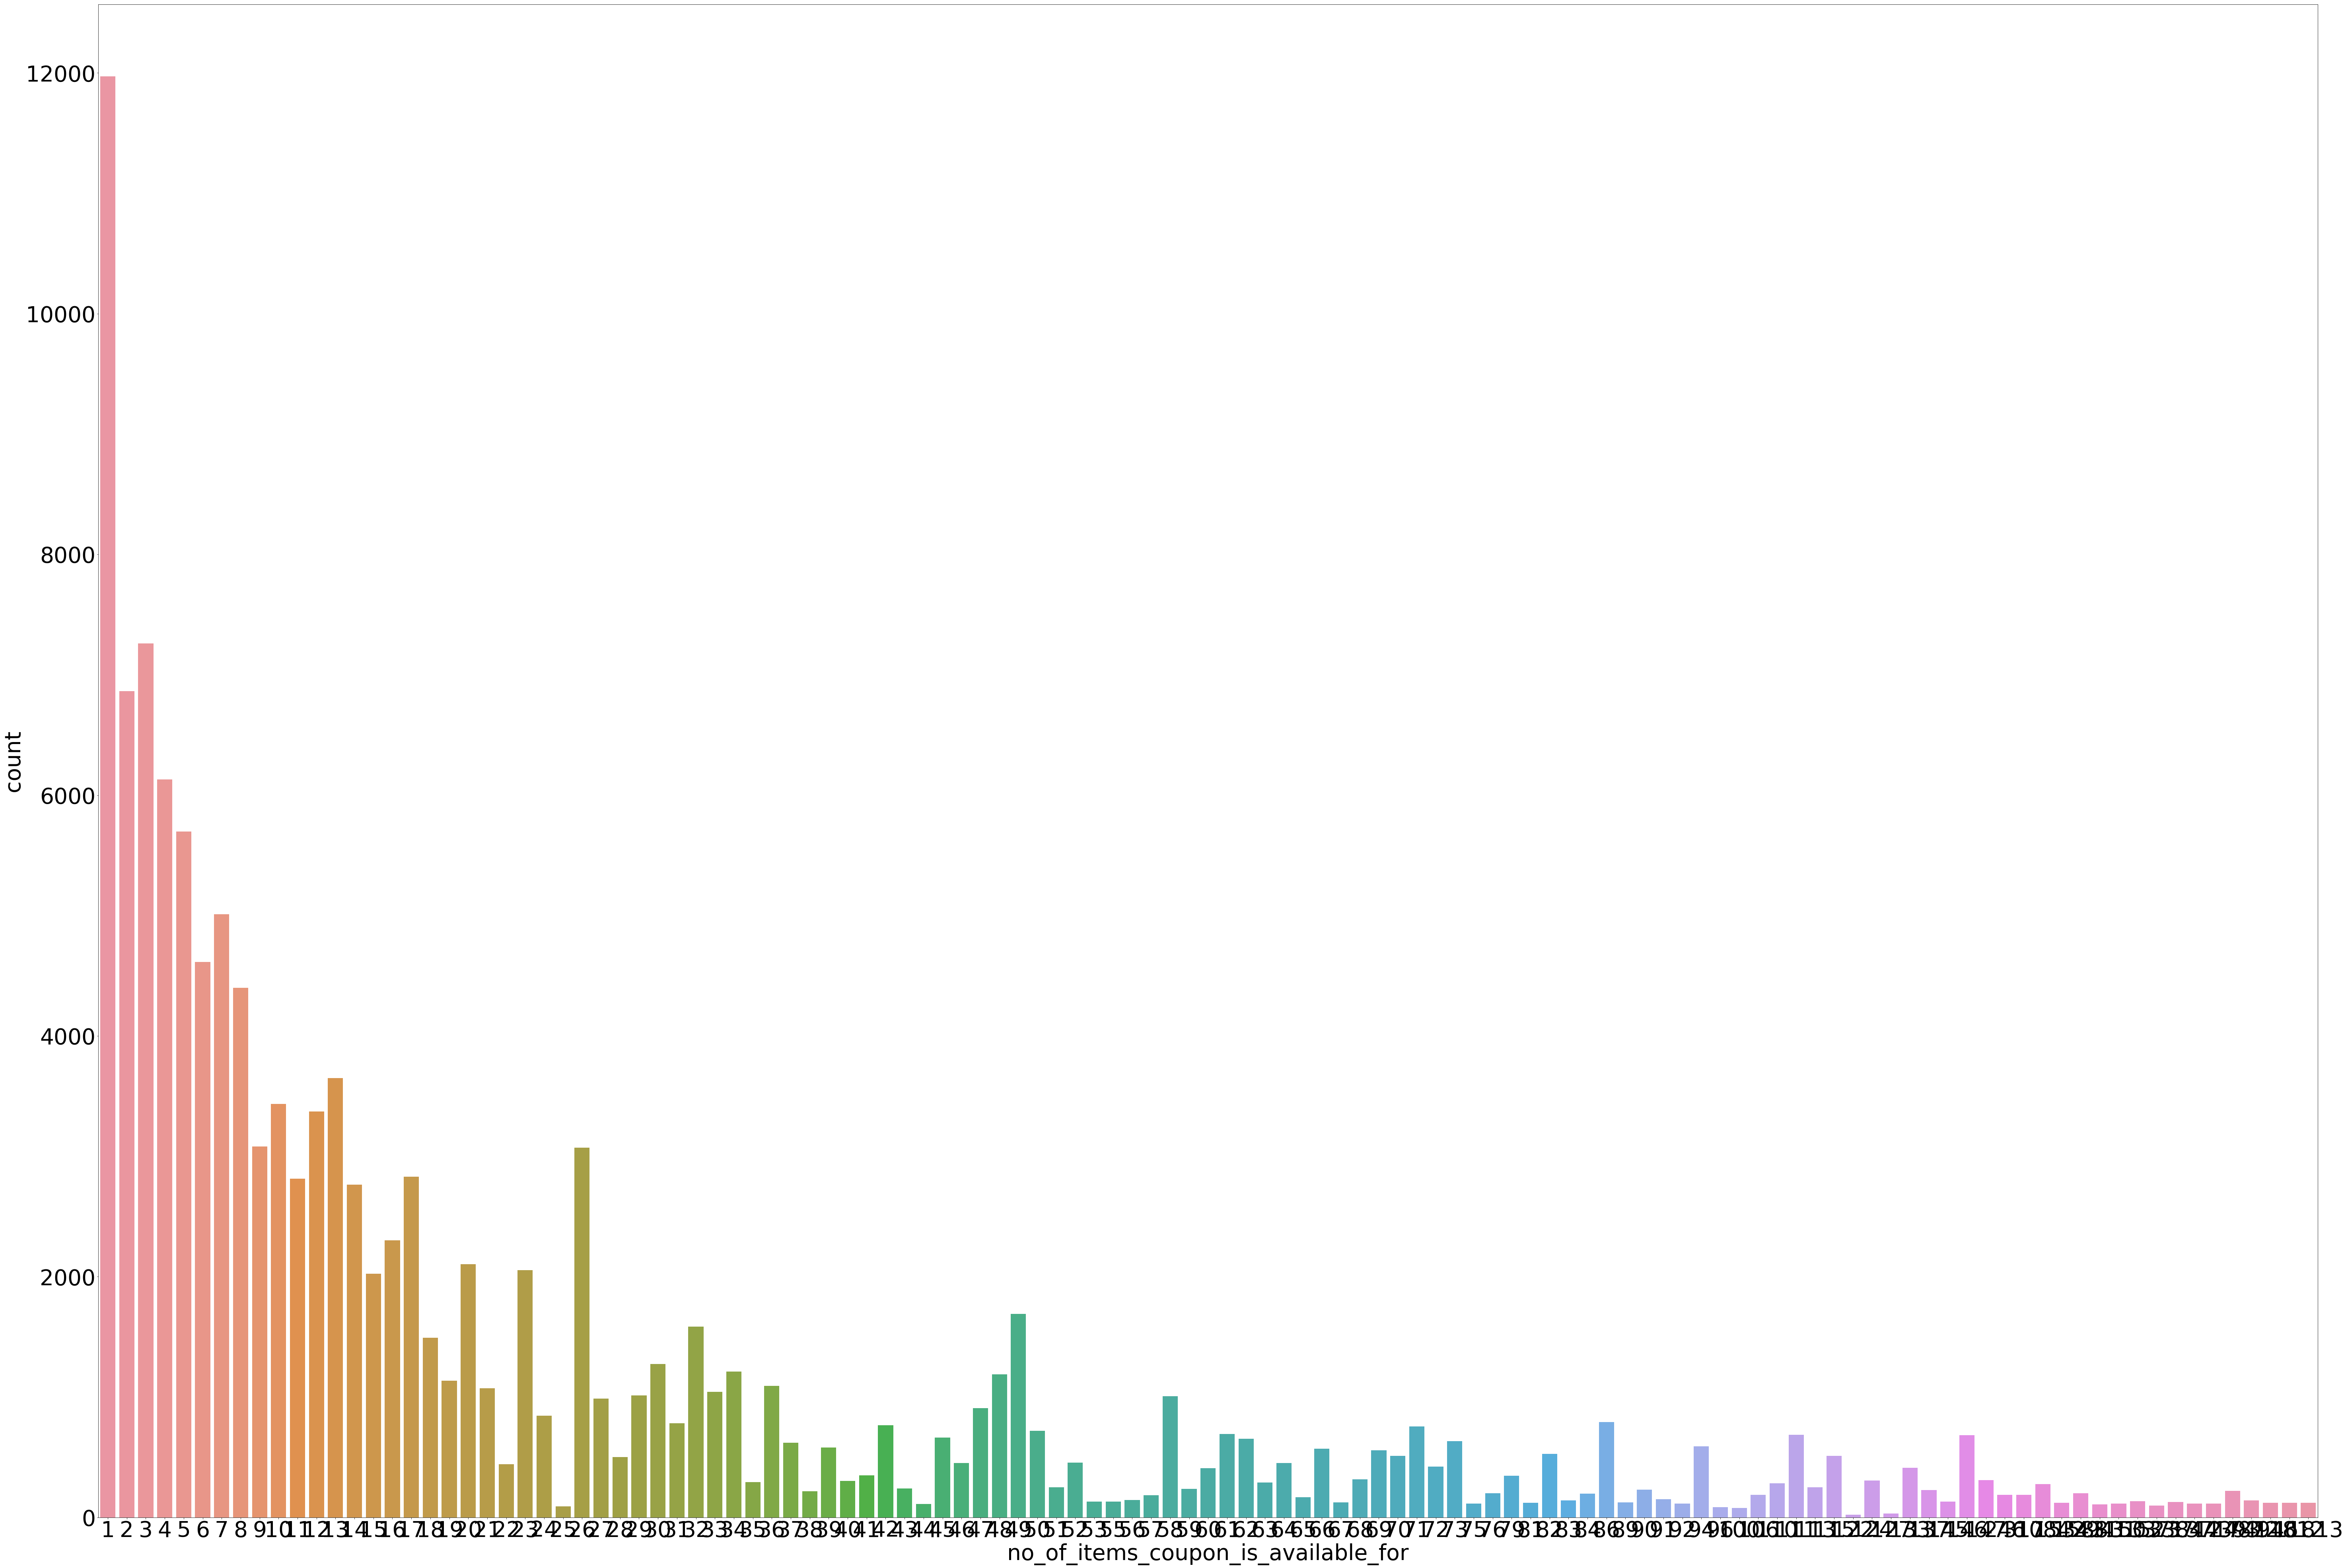

In [208]:
sns.countplot(merged_data['no_of_items_coupon_is_available_for'])

Maximum coupons support only a select few items. 

is_coupon_available_for_multiple_item_ids

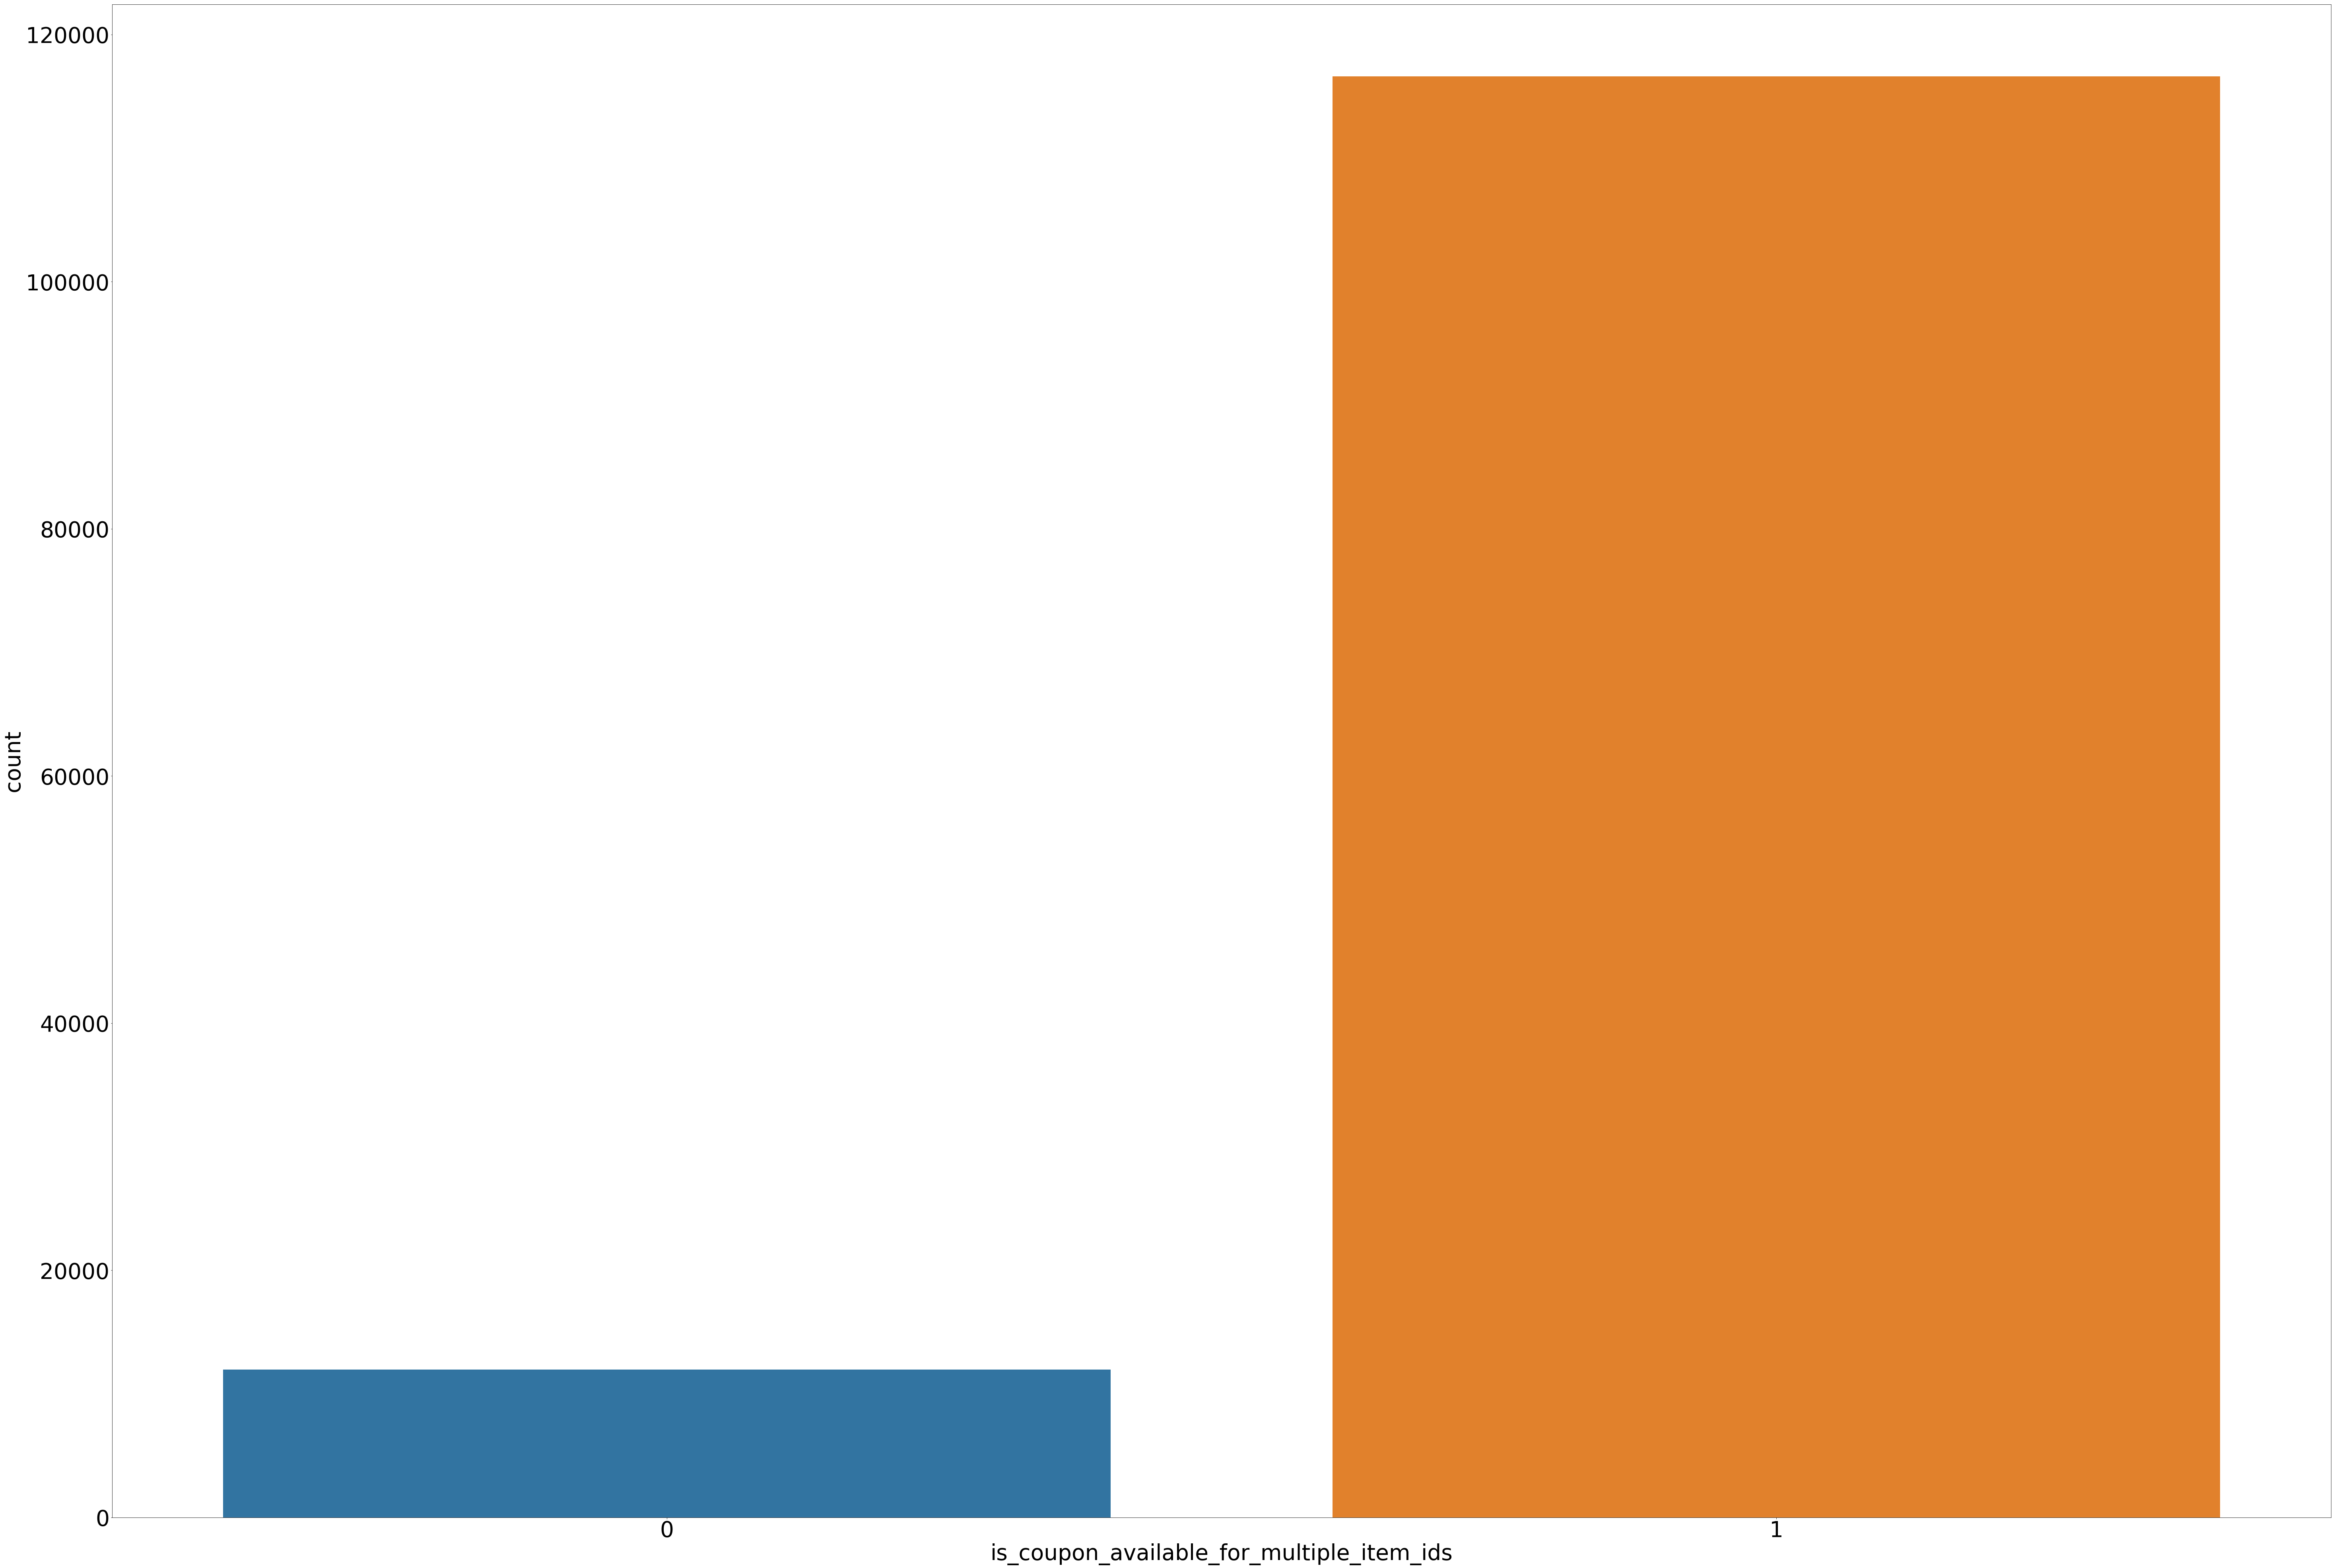

In [209]:
merged_data['is_coupon_available_for_multiple_item_ids'] = 0
merged_data['is_coupon_available_for_multiple_item_ids'] = merged_data['no_of_items_coupon_is_available_for'].apply(lambda x: 1 if(x > 1) else 0)
sns.countplot(merged_data['is_coupon_available_for_multiple_item_ids'])

## Generating features from item_ids about the category of item_ids

Analyzing category

[Text(0,0,'Grocery'),
 Text(0,0,'Miscellaneous'),
 Text(0,0,'Bakery'),
 Text(0,0,'Pharmaceutical'),
 Text(0,0,'Packaged Meat'),
 Text(0,0,'Seafood'),
 Text(0,0,'Natural Products'),
 Text(0,0,'Dairy, Juices & Snacks'),
 Text(0,0,'Prepared Food'),
 Text(0,0,'Skin & Hair Care'),
 Text(0,0,'Meat'),
 Text(0,0,'Travel'),
 Text(0,0,'Flowers & Plants'),
 Text(0,0,'Fuel'),
 Text(0,0,'Salads'),
 Text(0,0,'Alcohol'),
 Text(0,0,'Garden'),
 Text(0,0,'Restauarant'),
 Text(0,0,'Vegetables (cut)')]

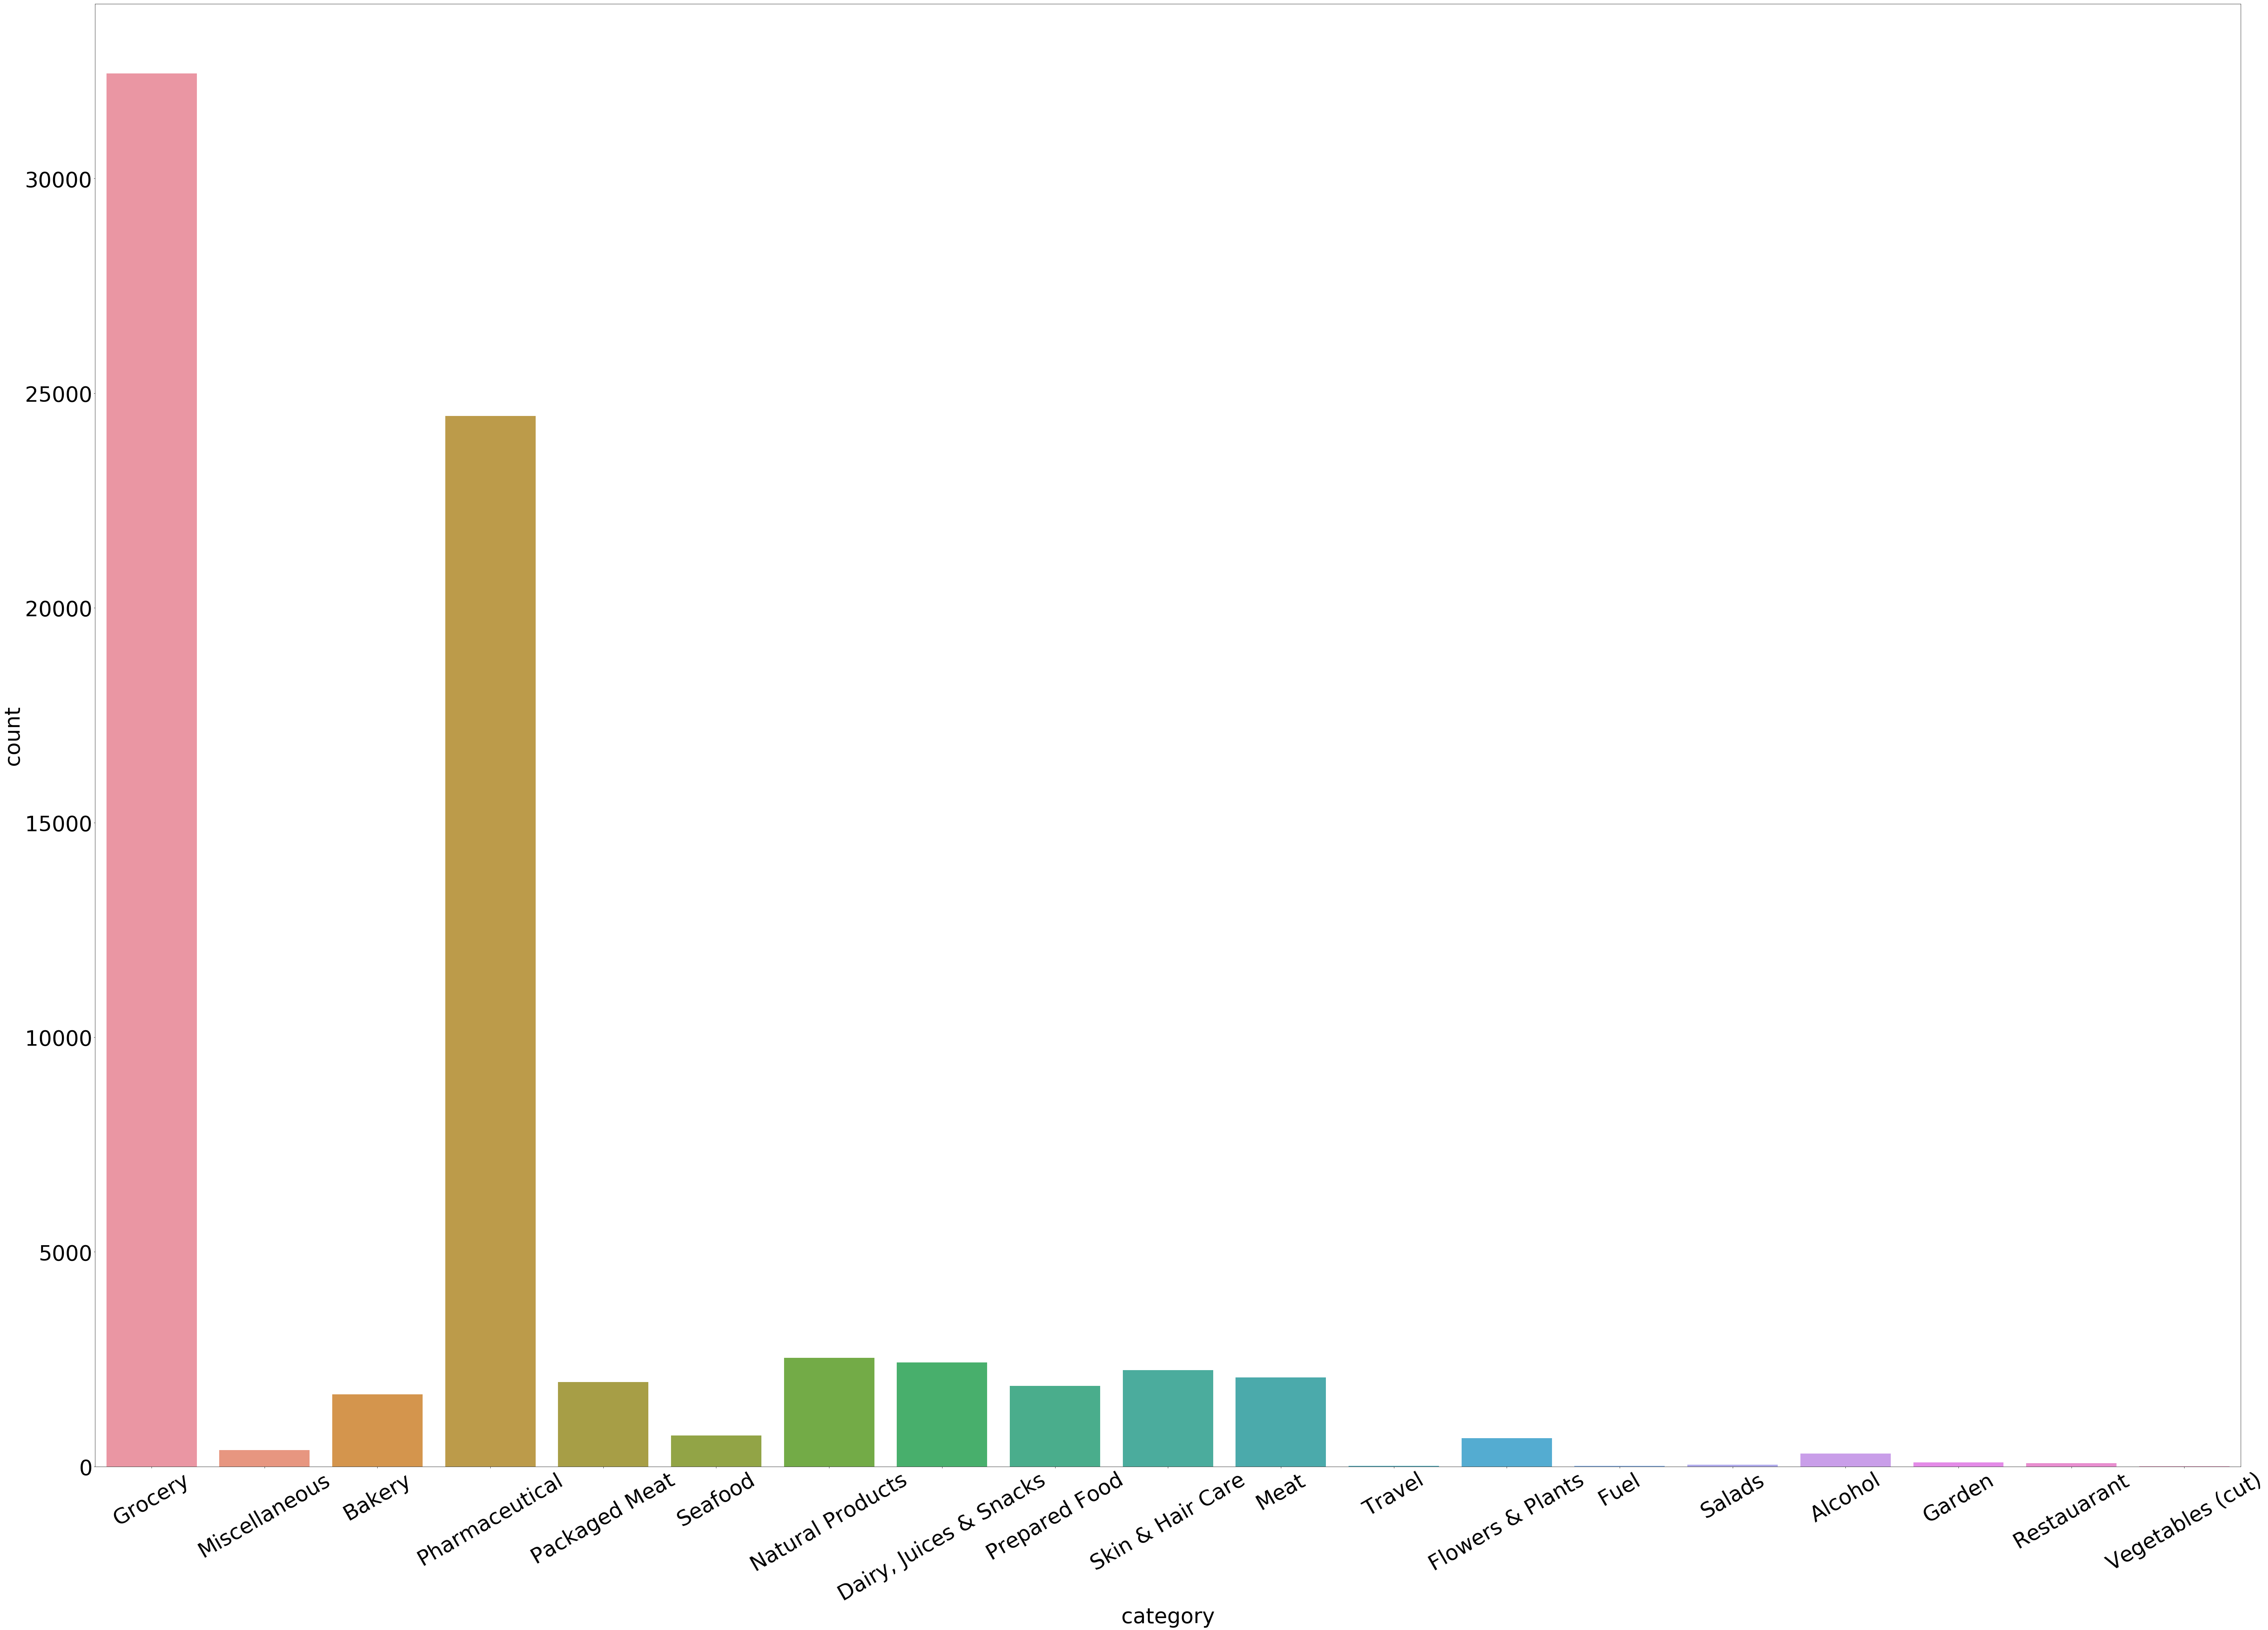

In [210]:
ax = sns.countplot(item_data.category)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

This column has a lot of sparse categories, clubbing them together

[Text(0,0,'Grocery'),
 Text(0,0,'Miscellaneous'),
 Text(0,0,'Bakery'),
 Text(0,0,'Pharmaceutical'),
 Text(0,0,'Meat and poultry'),
 Text(0,0,'Natural Products'),
 Text(0,0,'Dairy, Juices & Snacks'),
 Text(0,0,'Takeouts or Eating out'),
 Text(0,0,'Skin & Hair Care'),
 Text(0,0,'Travel and Fuel'),
 Text(0,0,'Flowers & Plants'),
 Text(0,0,'Alcohol'),
 Text(0,0,'Garden')]

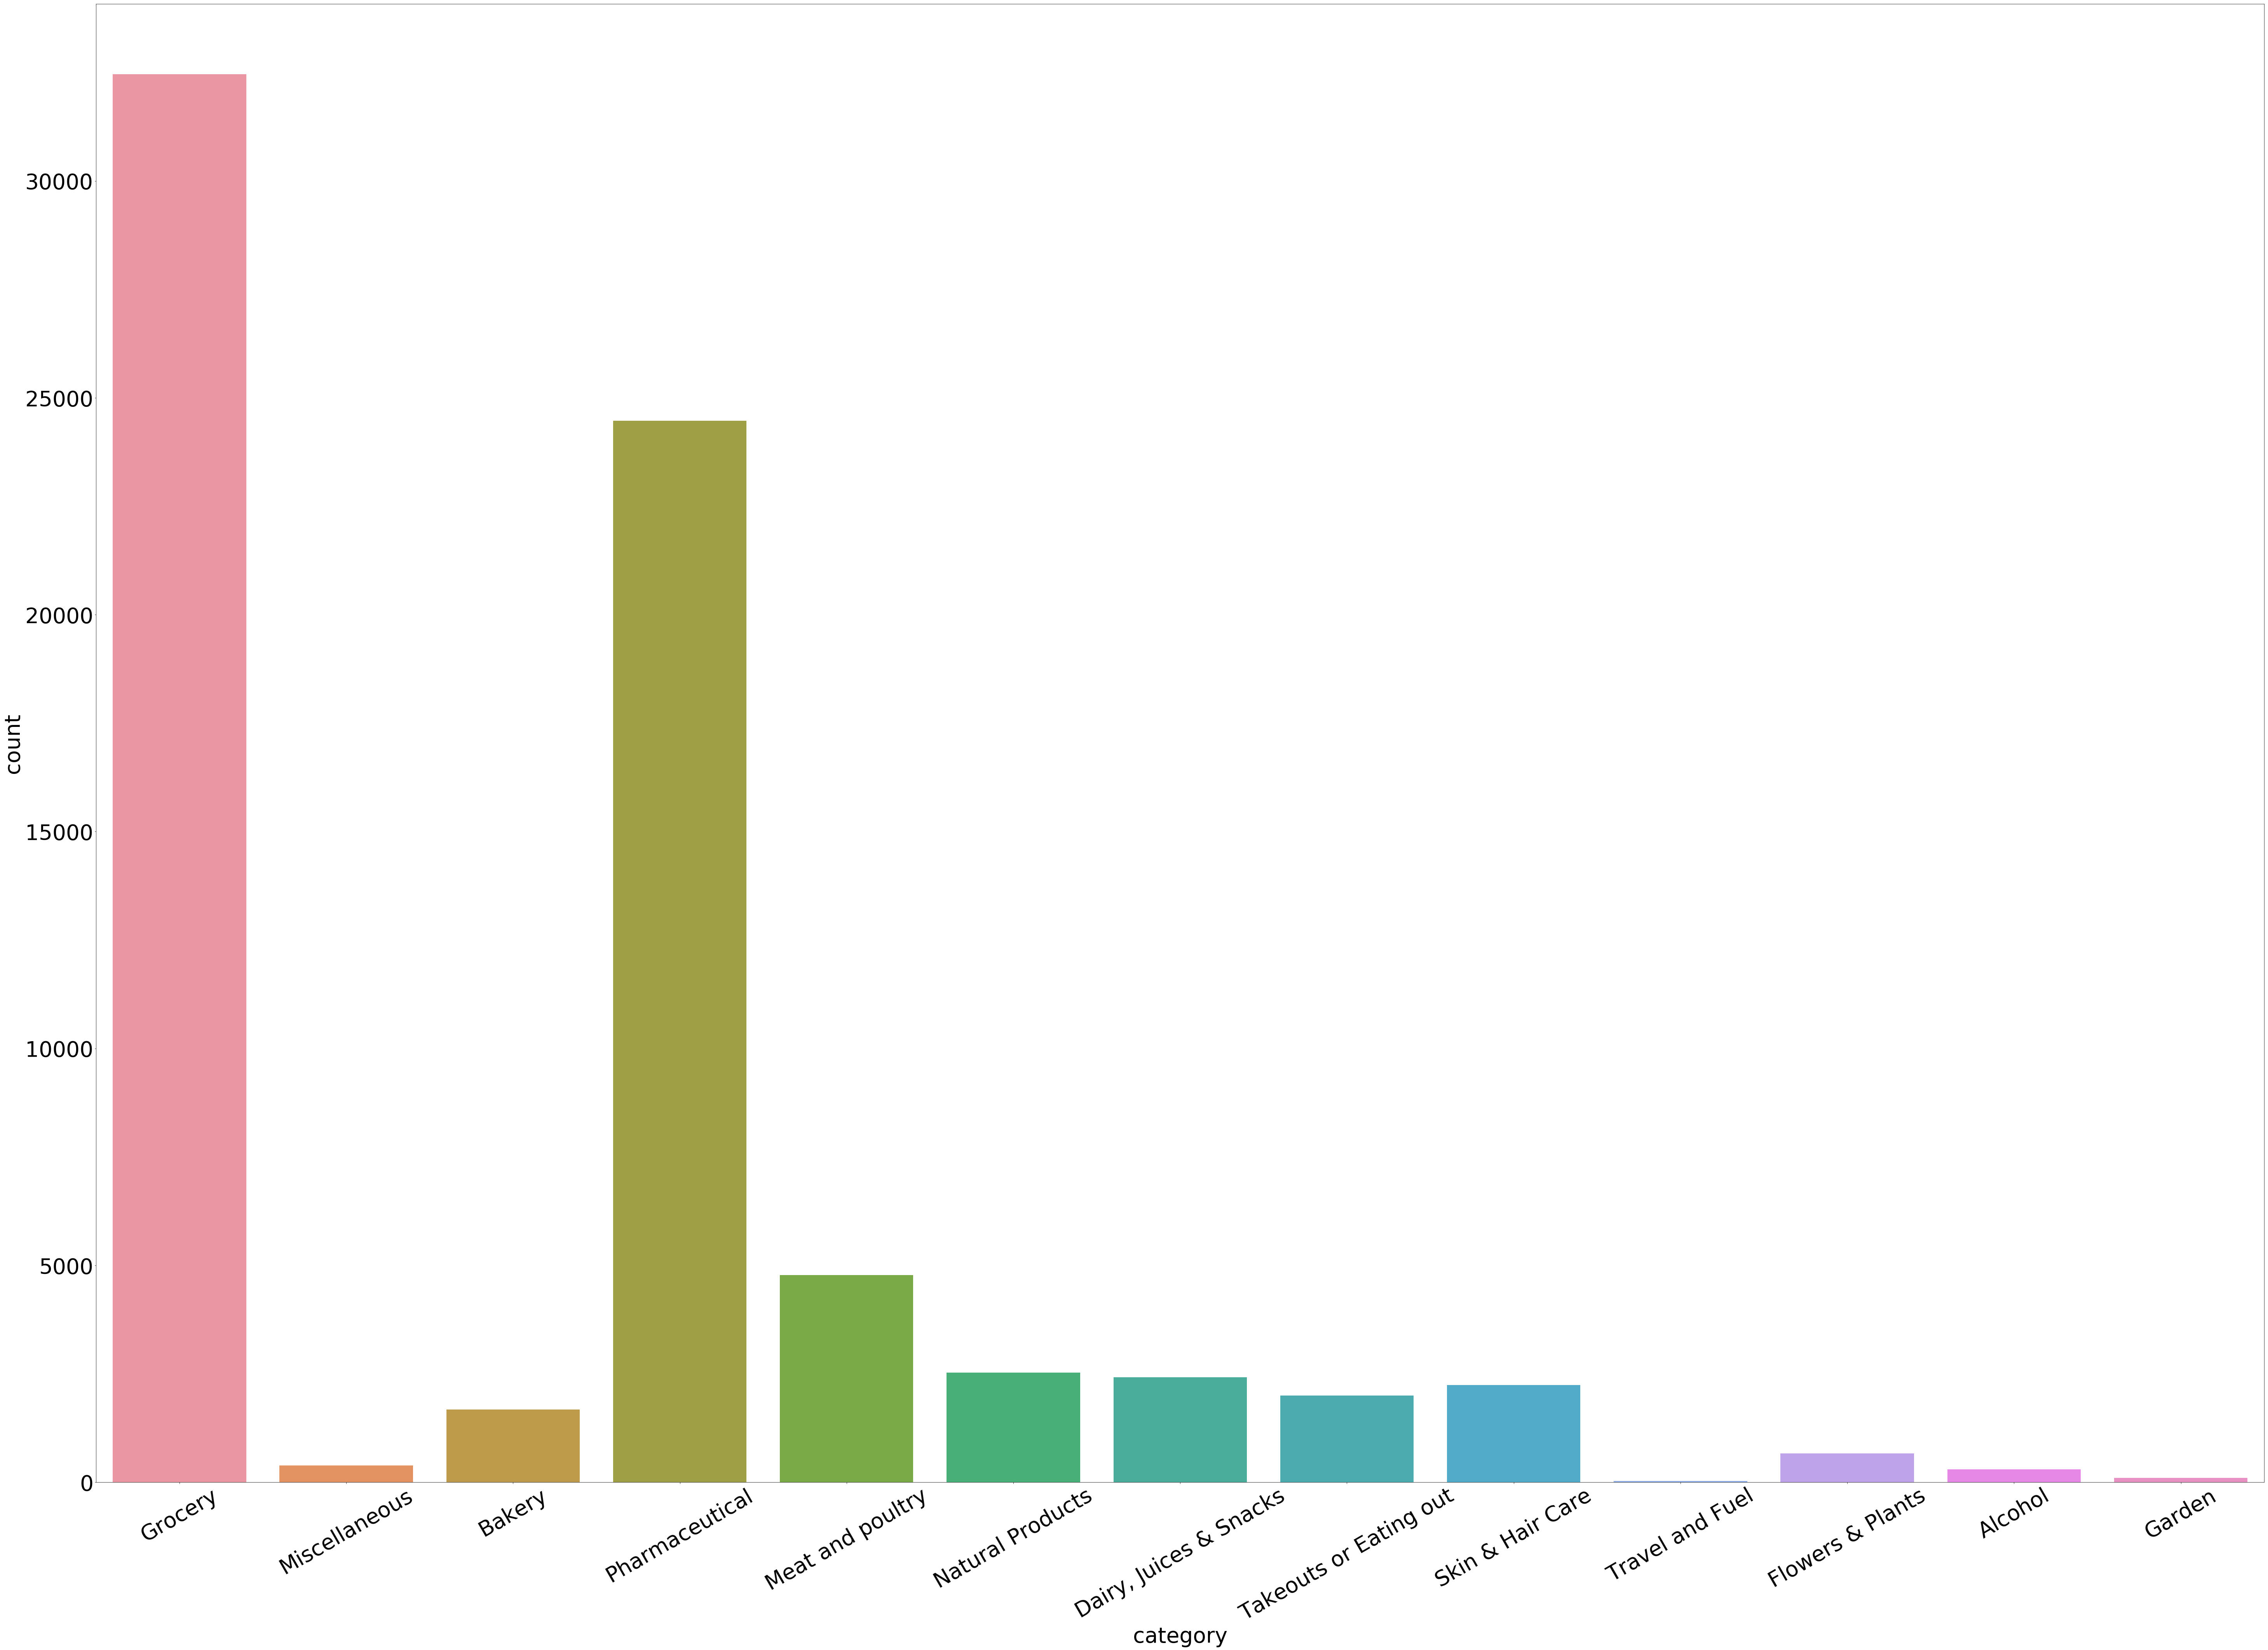

In [211]:
item_data['category'] = item_data['category'].apply(lambda x: 'Meat and poultry' if (x in ['Packaged Meat', 'Seafood', 'Meat']) else x)
item_data['category'] = item_data['category'].apply(lambda x: 'Grocery' if (x in ['Grocery', 'Vegetables (cut)']) else x)
item_data['category'] = item_data['category'].apply(lambda x: 'Takeouts or Eating out' if (x in ['Prepared Food', 'Restauarant', 'Salads']) else x)
item_data['category'] = item_data['category'].apply(lambda x: 'Travel and Fuel' if (x in ['Travel', 'Fuel']) else x)

ax = sns.countplot(item_data['category'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)



Applying the same transformations to customer transaction data

[Text(0,0,'Meat and poultry'),
 Text(0,0,'Grocery'),
 Text(0,0,'Pharmaceutical'),
 Text(0,0,'Dairy, Juices & Snacks'),
 Text(0,0,'Takeouts or Eating out'),
 Text(0,0,'Skin & Hair Care'),
 Text(0,0,'Natural Products'),
 Text(0,0,'Bakery'),
 Text(0,0,'Flowers & Plants'),
 Text(0,0,'Miscellaneous')]

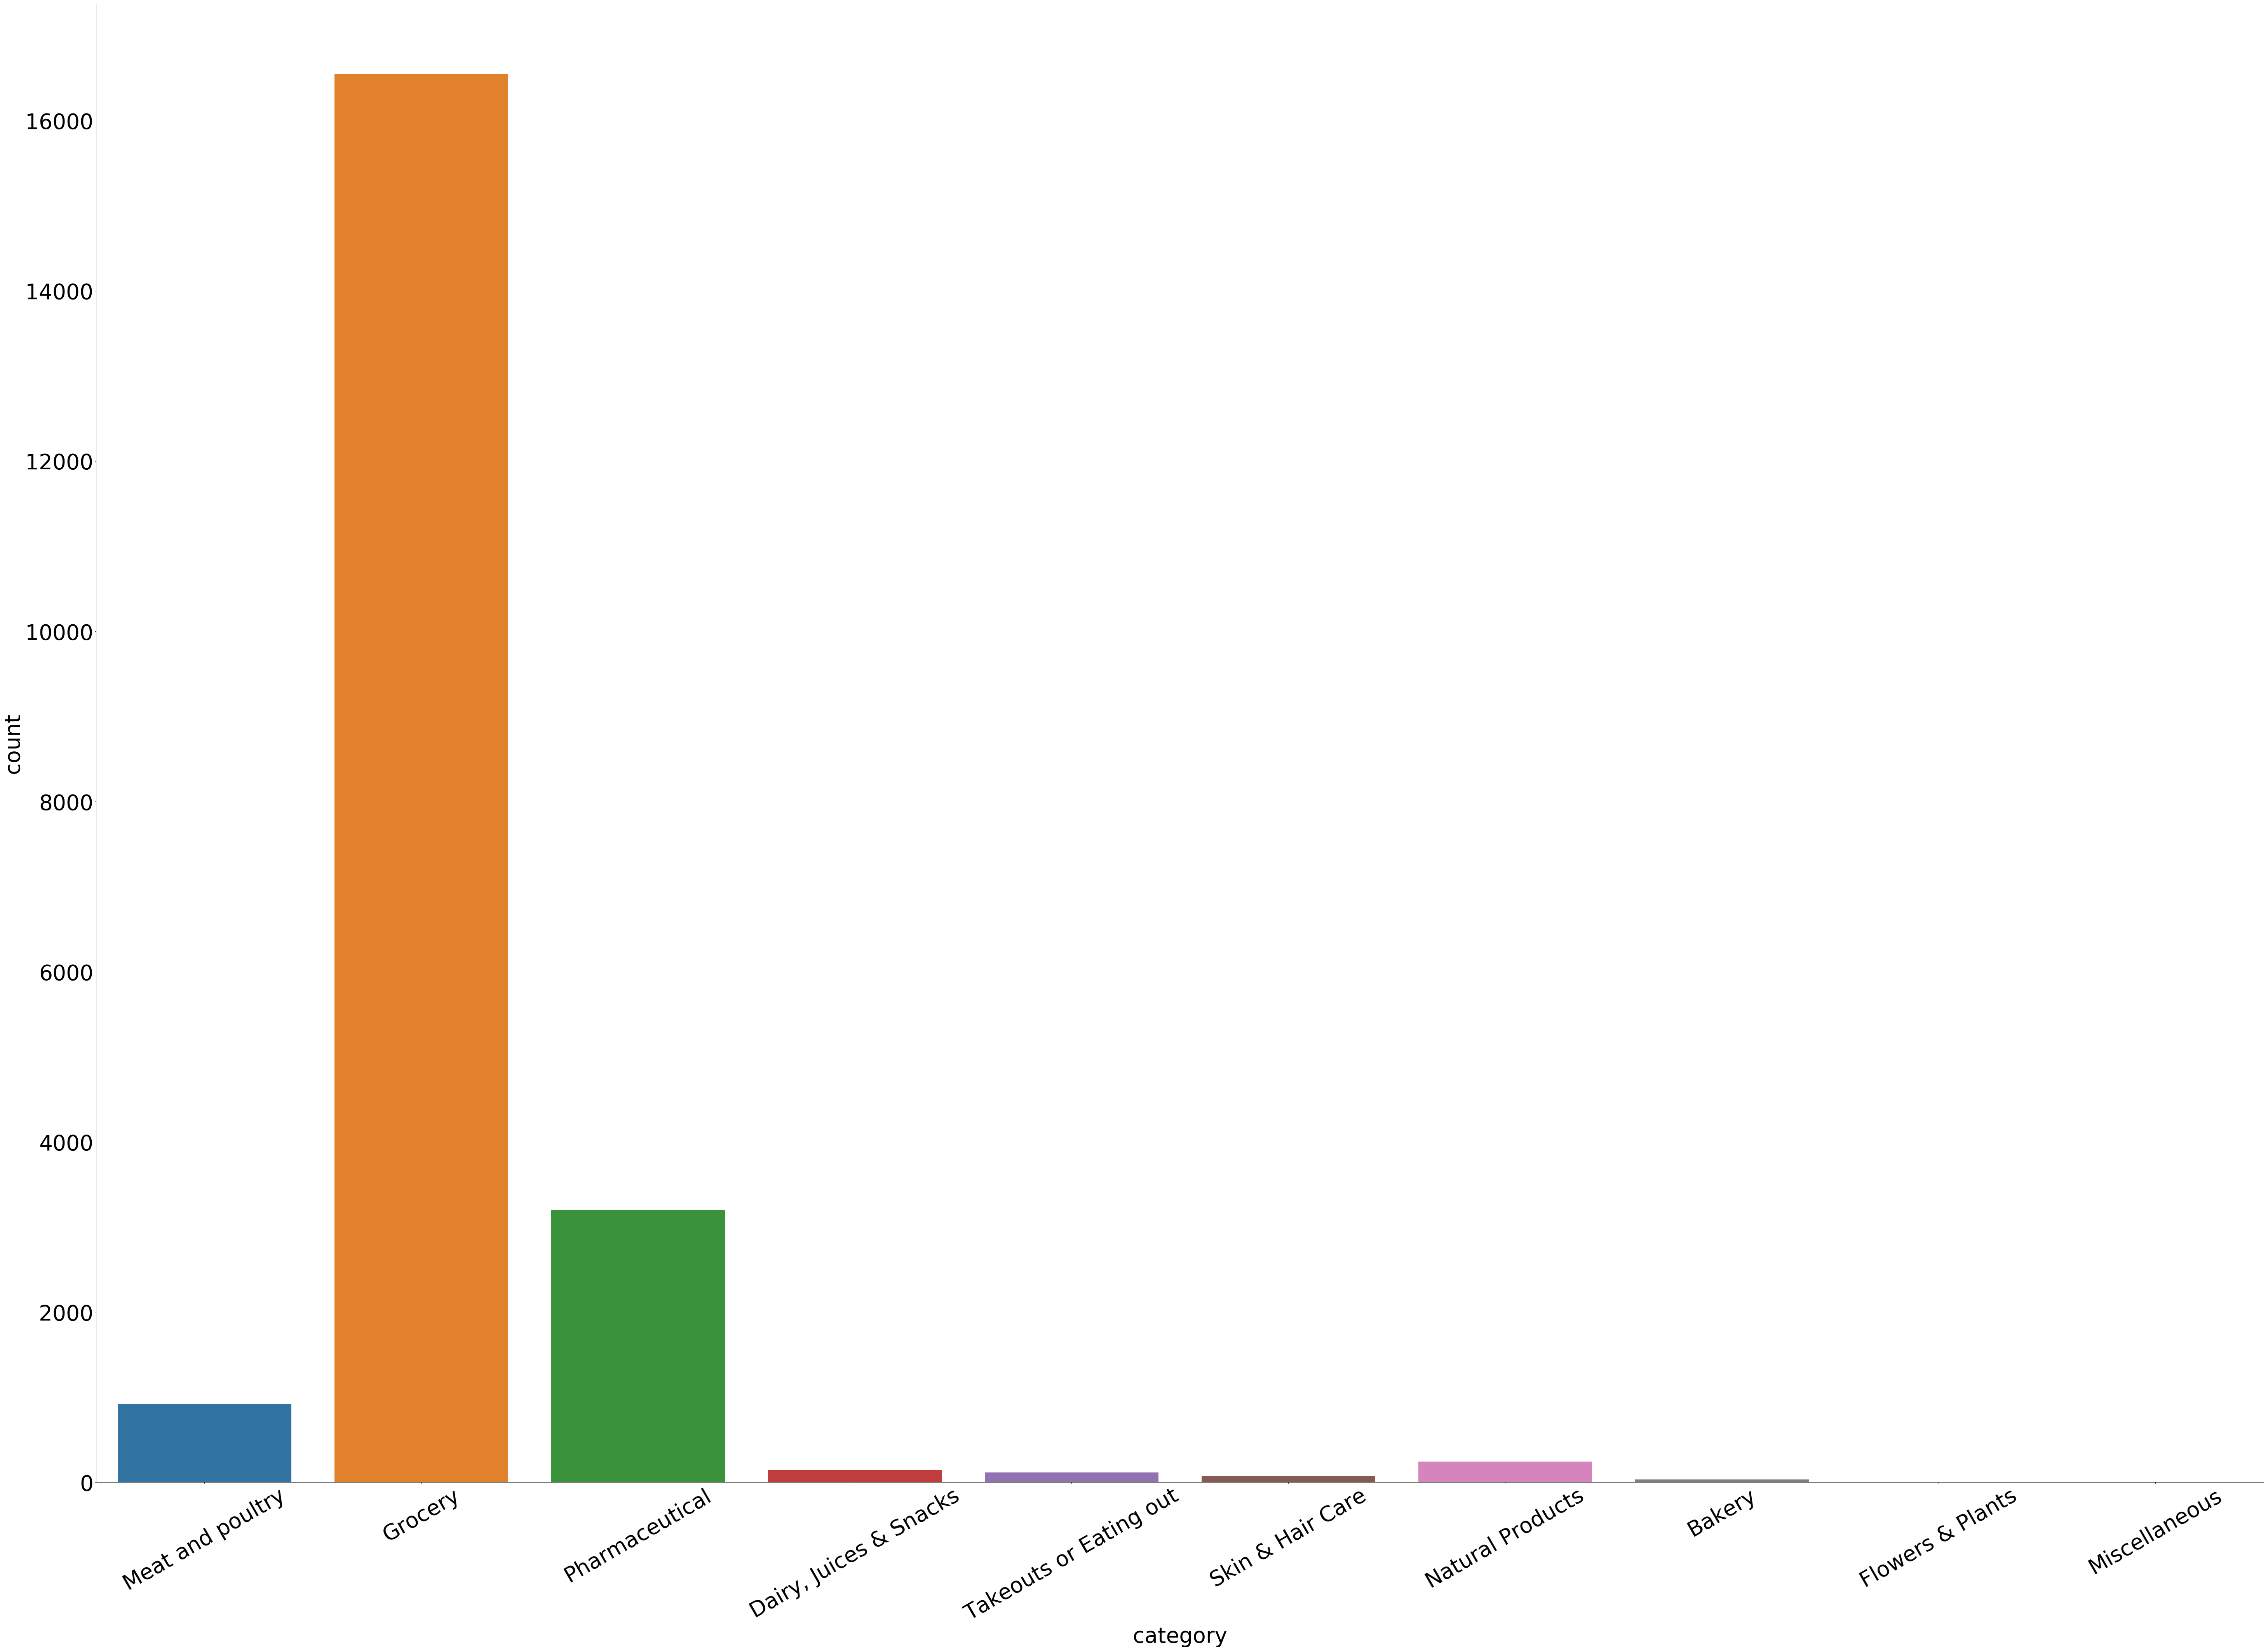

In [212]:
customer_transaction_data_on_coupons['category'] = customer_transaction_data_on_coupons['category'].apply(lambda x: 'Meat and poultry' if (x in ['Packaged Meat', 'Seafood', 'Meat']) else x)
customer_transaction_data_on_coupons['category'] = customer_transaction_data_on_coupons['category'].apply(lambda x: 'Grocery' if (x in ['Grocery', 'Vegetables (cut)']) else x)
customer_transaction_data_on_coupons['category'] = customer_transaction_data_on_coupons['category'].apply(lambda x: 'Takeouts or Eating out' if (x in ['Prepared Food', 'Restauarant', 'Salads']) else x)
customer_transaction_data_on_coupons['category'] = customer_transaction_data_on_coupons['category'].apply(lambda x: 'Travel and Fuel' if (x in ['Travel', 'Fuel']) else x)

ax = sns.countplot(customer_transaction_data_on_coupons['category'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)




[Text(0,0,'Natural Products'),
 Text(0,0,'Grocery'),
 Text(0,0,'Meat and poultry'),
 Text(0,0,'Pharmaceutical'),
 Text(0,0,'Takeouts or Eating out'),
 Text(0,0,'Bakery'),
 Text(0,0,'Dairy, Juices & Snacks'),
 Text(0,0,'Flowers & Plants'),
 Text(0,0,'Alcohol'),
 Text(0,0,'Skin & Hair Care'),
 Text(0,0,'Miscellaneous'),
 Text(0,0,'Garden'),
 Text(0,0,'Travel and Fuel')]

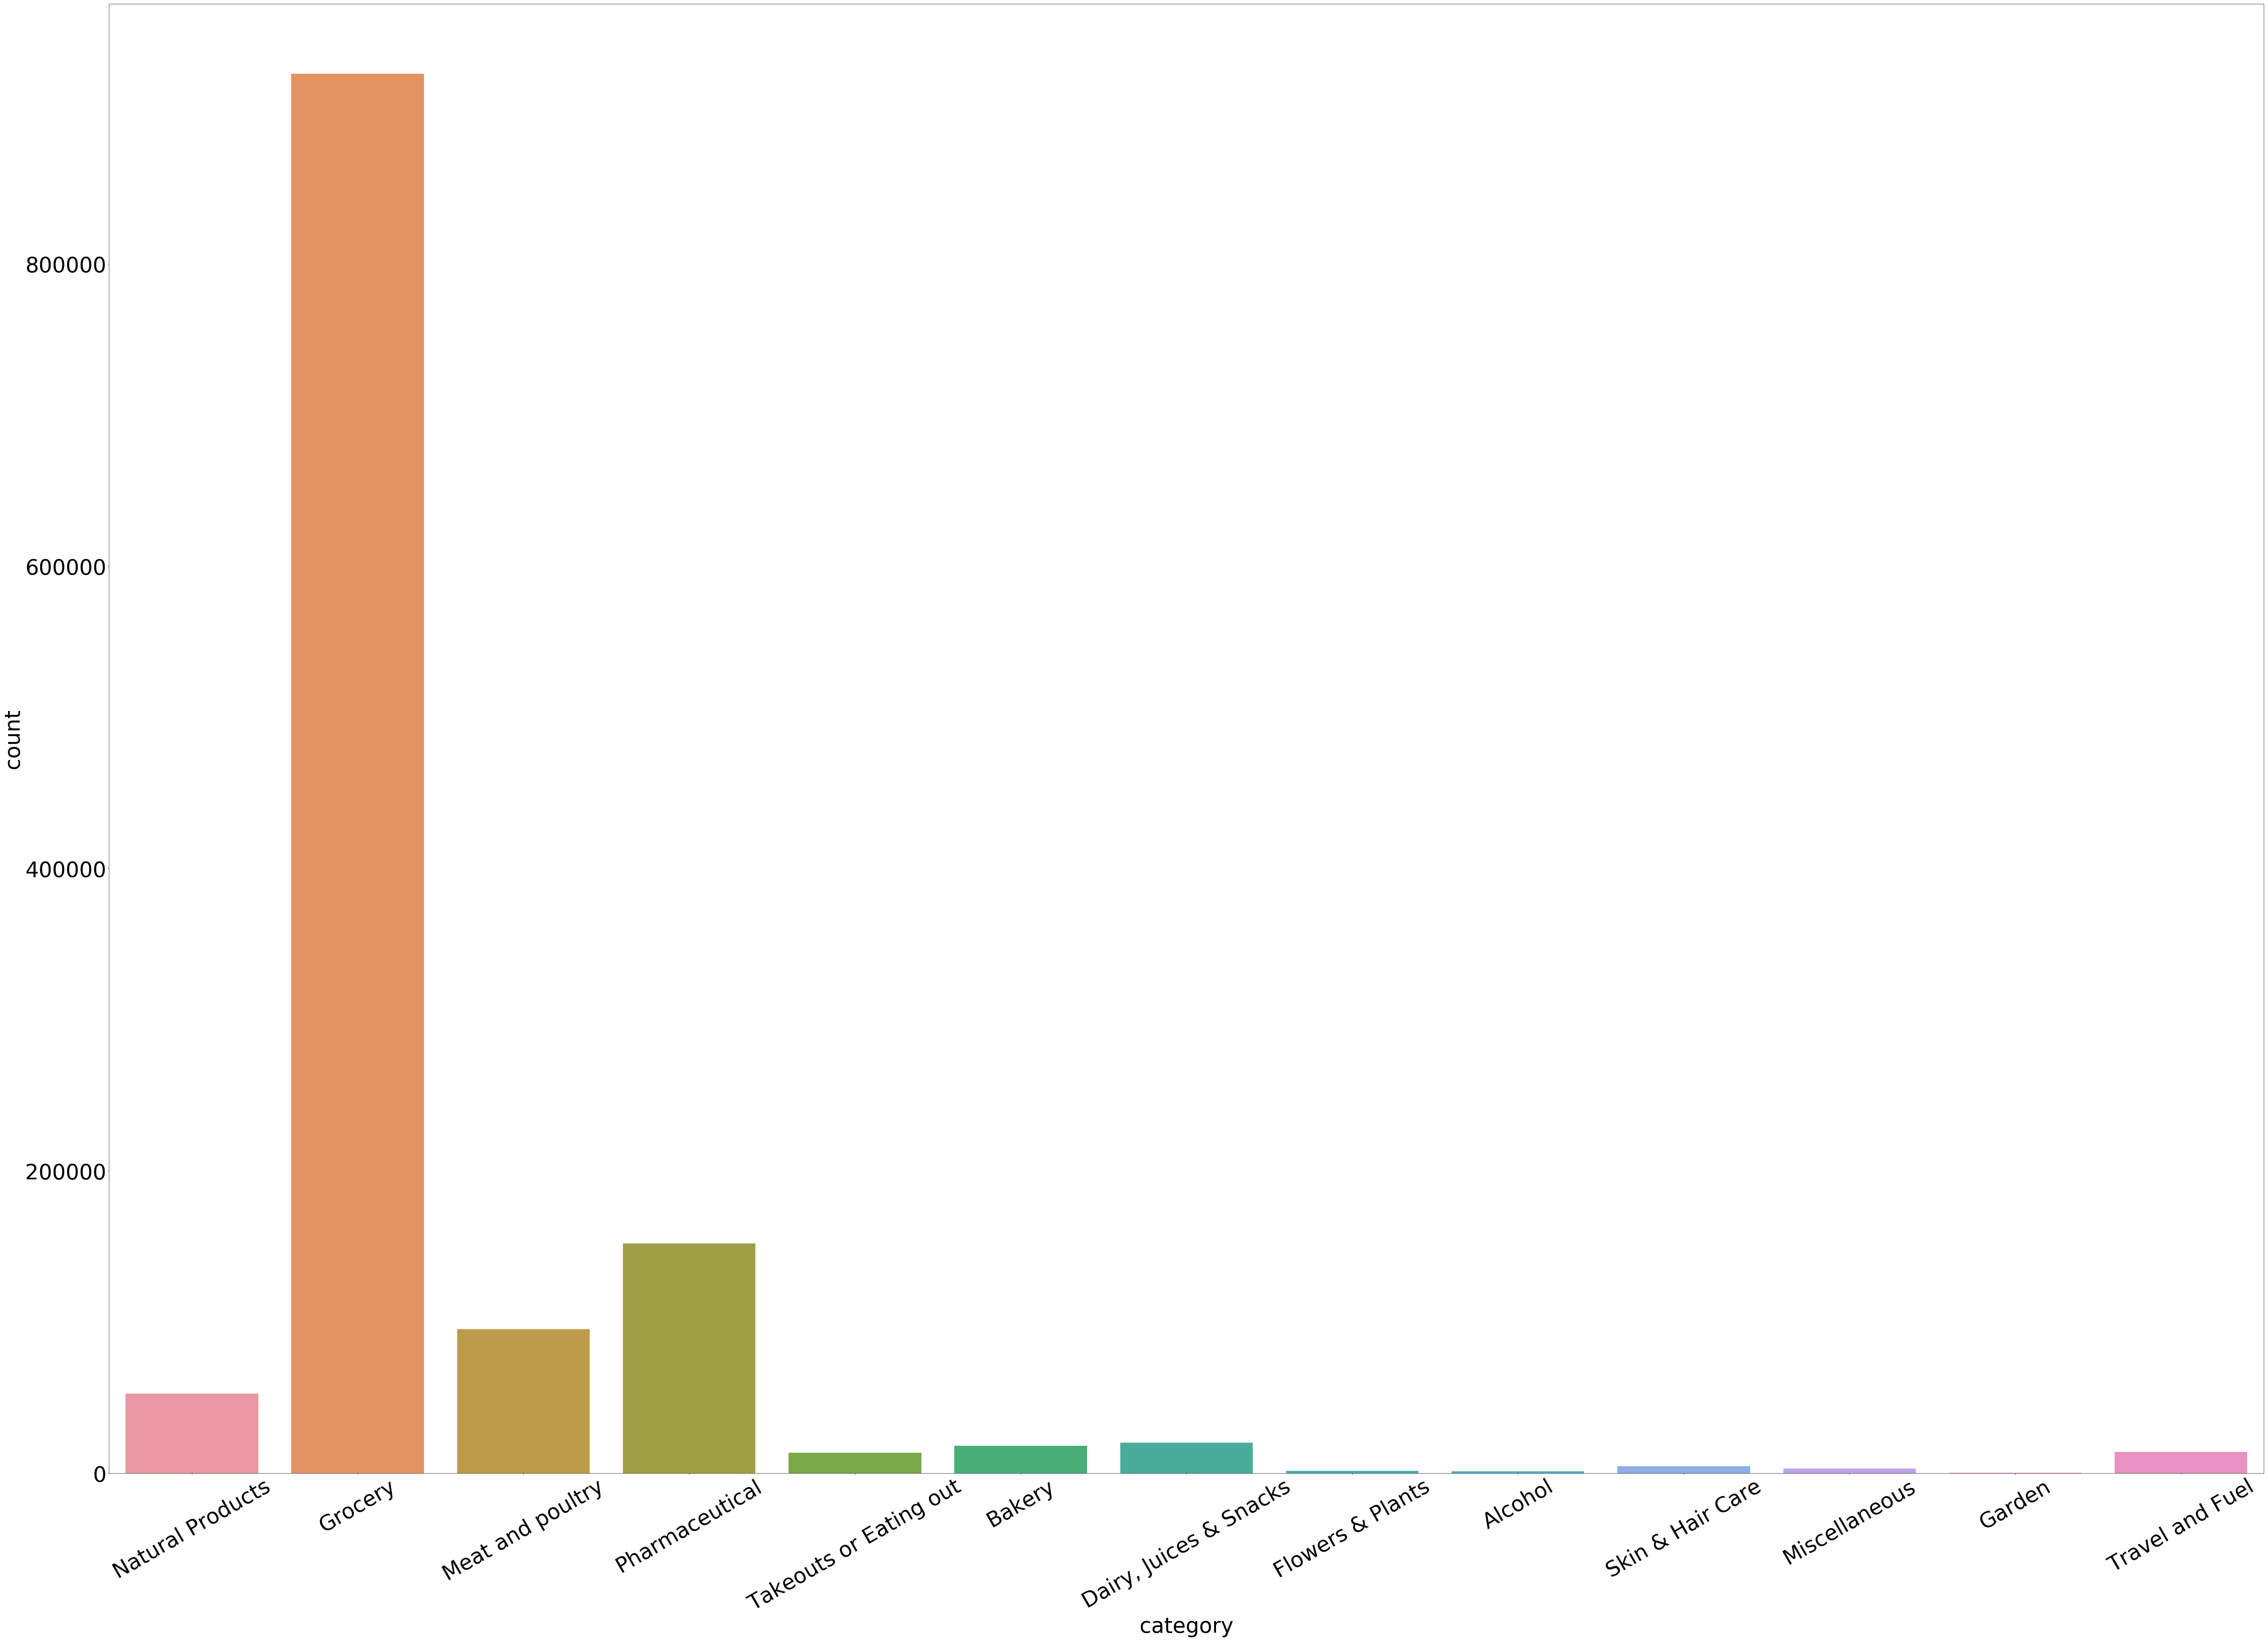

In [213]:
customer_transaction_data_without_coupons['category'] = customer_transaction_data_without_coupons['category'].apply(lambda x: 'Meat and poultry' if (x in ['Packaged Meat', 'Seafood', 'Meat']) else x)
customer_transaction_data_without_coupons['category'] = customer_transaction_data_without_coupons['category'].apply(lambda x: 'Grocery' if (x in ['Grocery', 'Vegetables (cut)']) else x)
customer_transaction_data_without_coupons['category'] = customer_transaction_data_without_coupons['category'].apply(lambda x: 'Takeouts or Eating out' if (x in ['Prepared Food', 'Restauarant', 'Salads']) else x)
customer_transaction_data_without_coupons['category'] = customer_transaction_data_without_coupons['category'].apply(lambda x: 'Travel and Fuel' if (x in ['Travel', 'Fuel']) else x)

ax = sns.countplot(customer_transaction_data_without_coupons['category'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)





no_of_categories_of_items_available_under_coupon

In [214]:
%%time
def get_categorie_counts (x):
    list_of_item_ids = x.split(",")
    list_of_unique_category_of_items = set(item_data[item_data.item_id.isin(list_of_item_ids)].category.to_list())
    unique_categories = len(list_of_unique_category_of_items)
    
    if (unique_categories > 2):
        return (3)
    else:
        return (unique_categories)
    




merged_data['no_of_categories_of_items_available_under_coupon'] = merged_data['coupon_available_on_item_ids'].apply(get_categorie_counts)


CPU times: user 6min 23s, sys: 1.98 s, total: 6min 25s
Wall time: 8min 38s


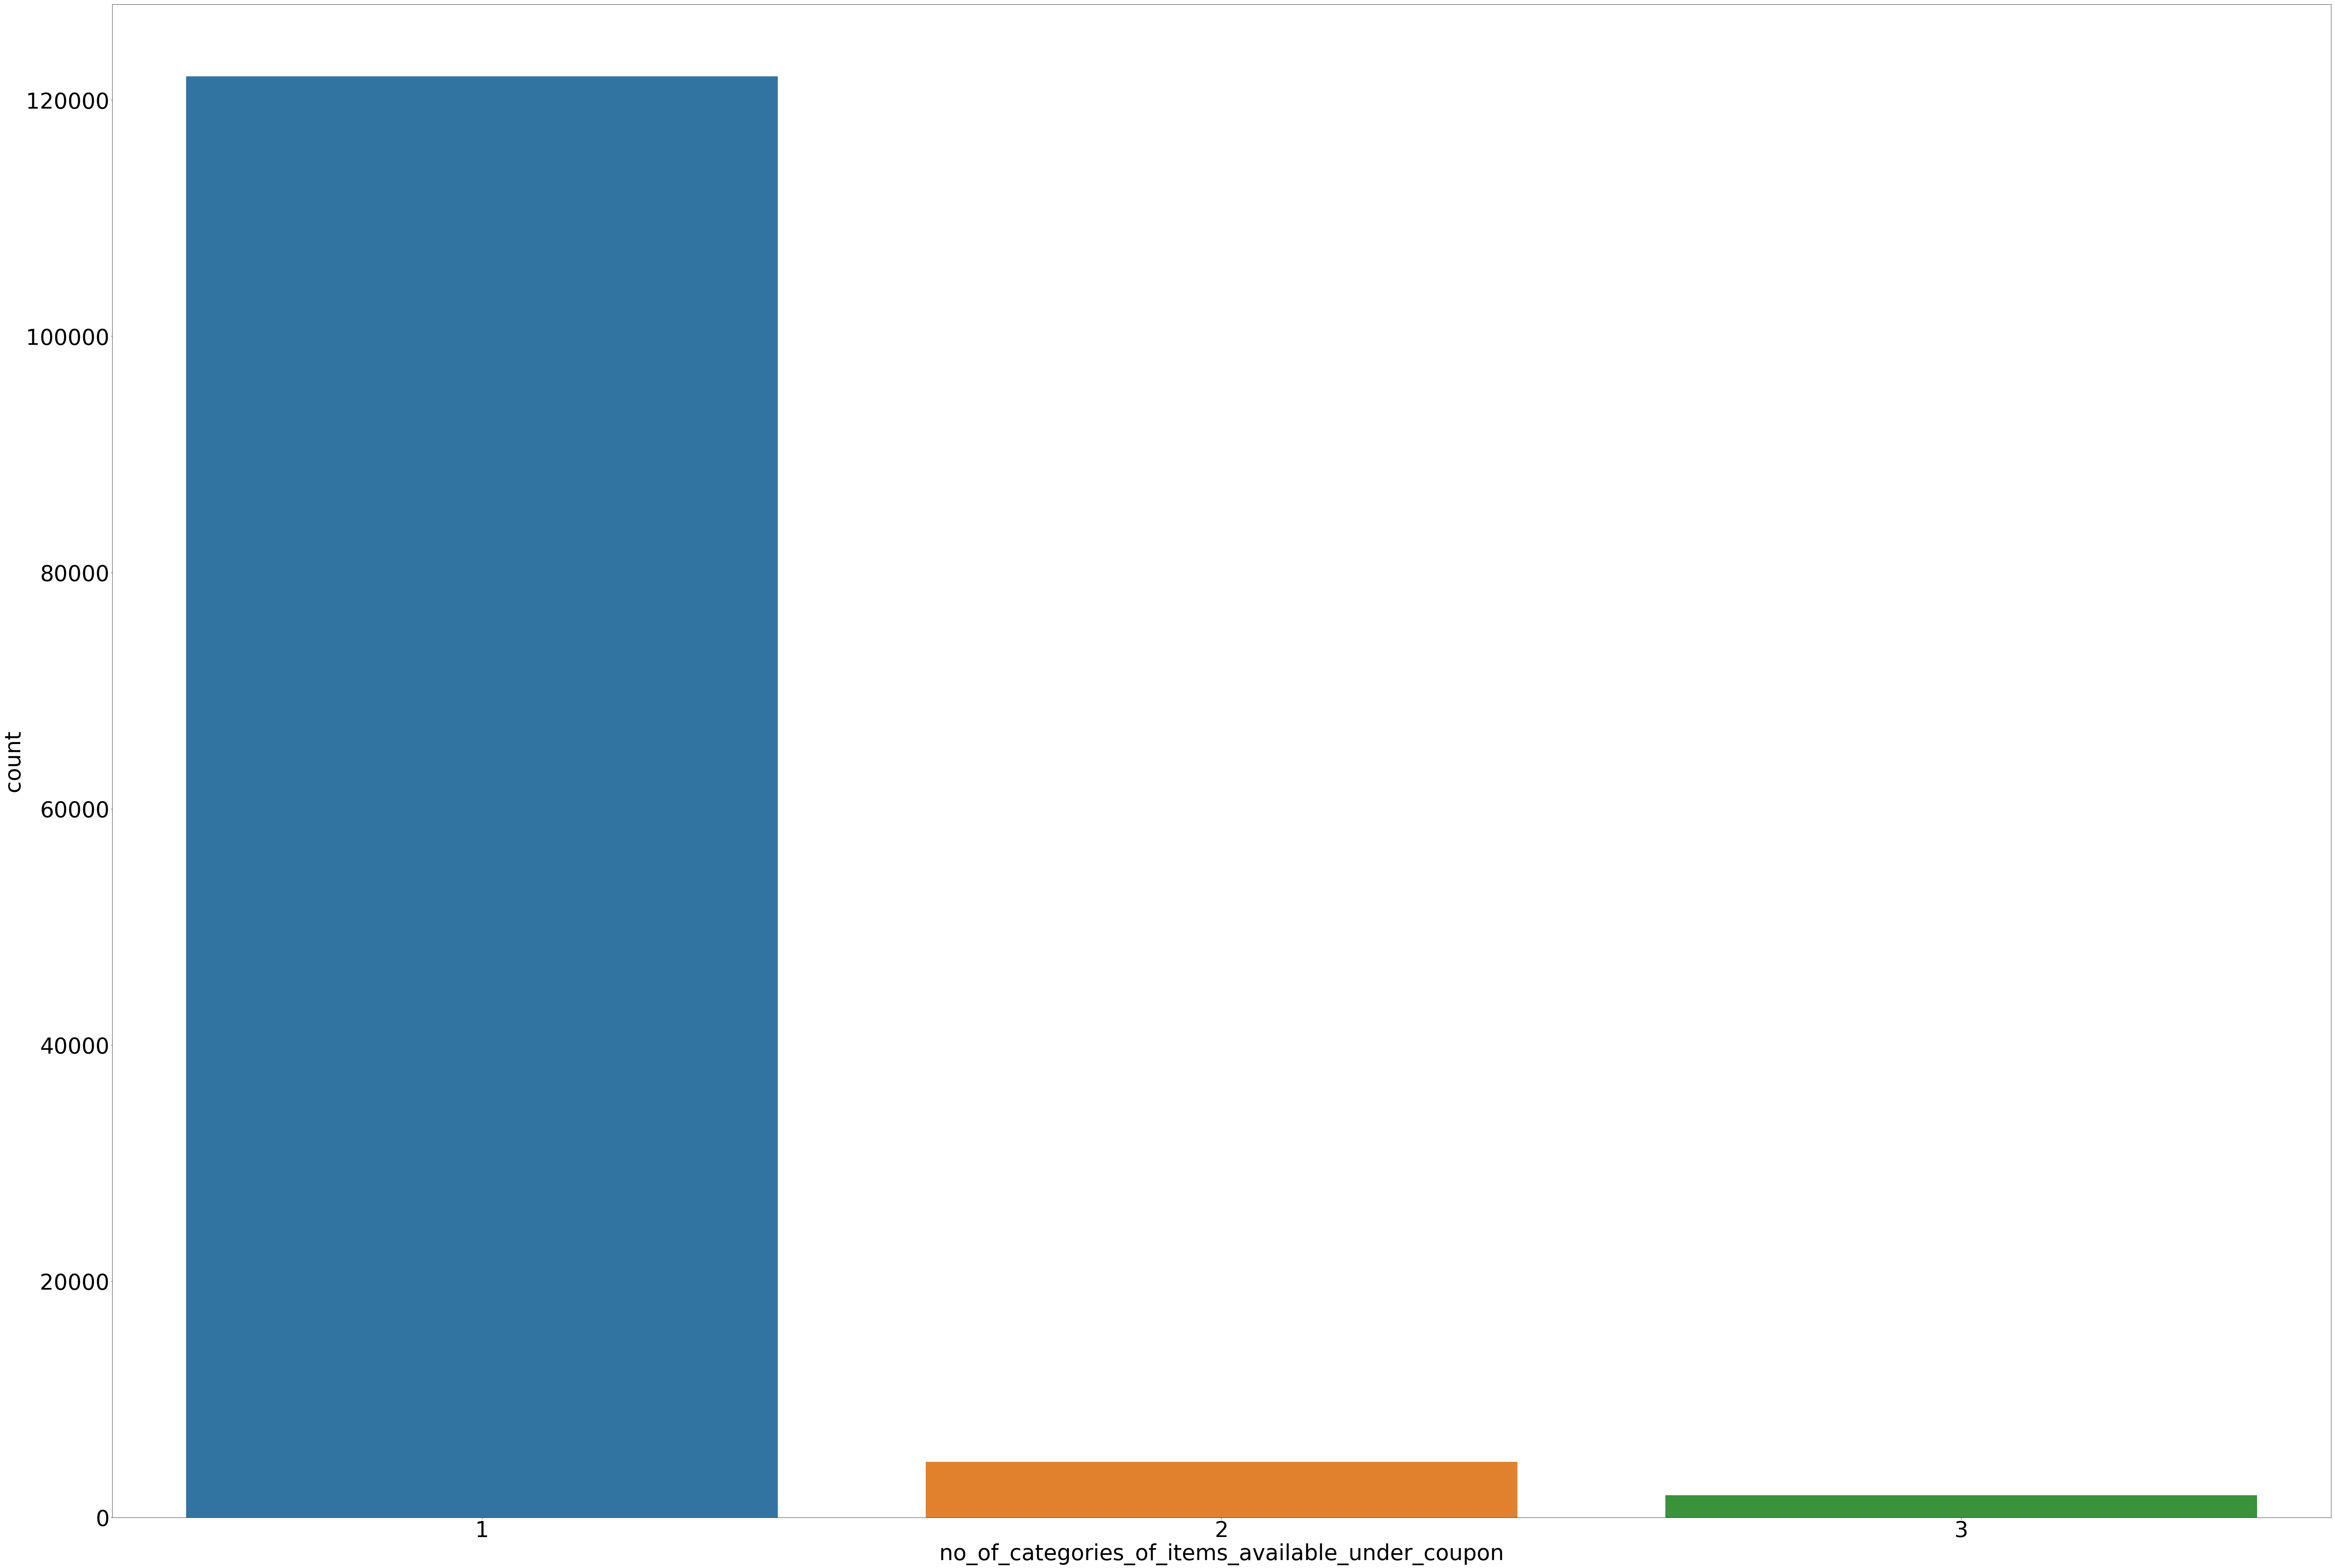

In [215]:
sns.countplot(merged_data['no_of_categories_of_items_available_under_coupon'])

coupon_available_on_category_1

In [216]:
%%time

def get_most_common_category (x):
    list_of_item_ids = x.split(",")
    list_of_category_of_items = item_data[item_data.item_id.isin(list_of_item_ids)].category.to_list()
    c = Counter(list_of_category_of_items)
    return (c.most_common(1)[0][0])

merged_data['coupon_available_on_category_1'] = merged_data['coupon_available_on_item_ids'].apply(get_most_common_category)



CPU times: user 6min 15s, sys: 1.79 s, total: 6min 17s
Wall time: 8min 30s


[Text(0,0,'Grocery'),
 Text(0,0,'Pharmaceutical'),
 Text(0,0,'Bakery'),
 Text(0,0,'Meat and poultry'),
 Text(0,0,'Dairy, Juices & Snacks'),
 Text(0,0,'Takeouts or Eating out'),
 Text(0,0,'Natural Products'),
 Text(0,0,'Flowers & Plants'),
 Text(0,0,'Skin & Hair Care')]

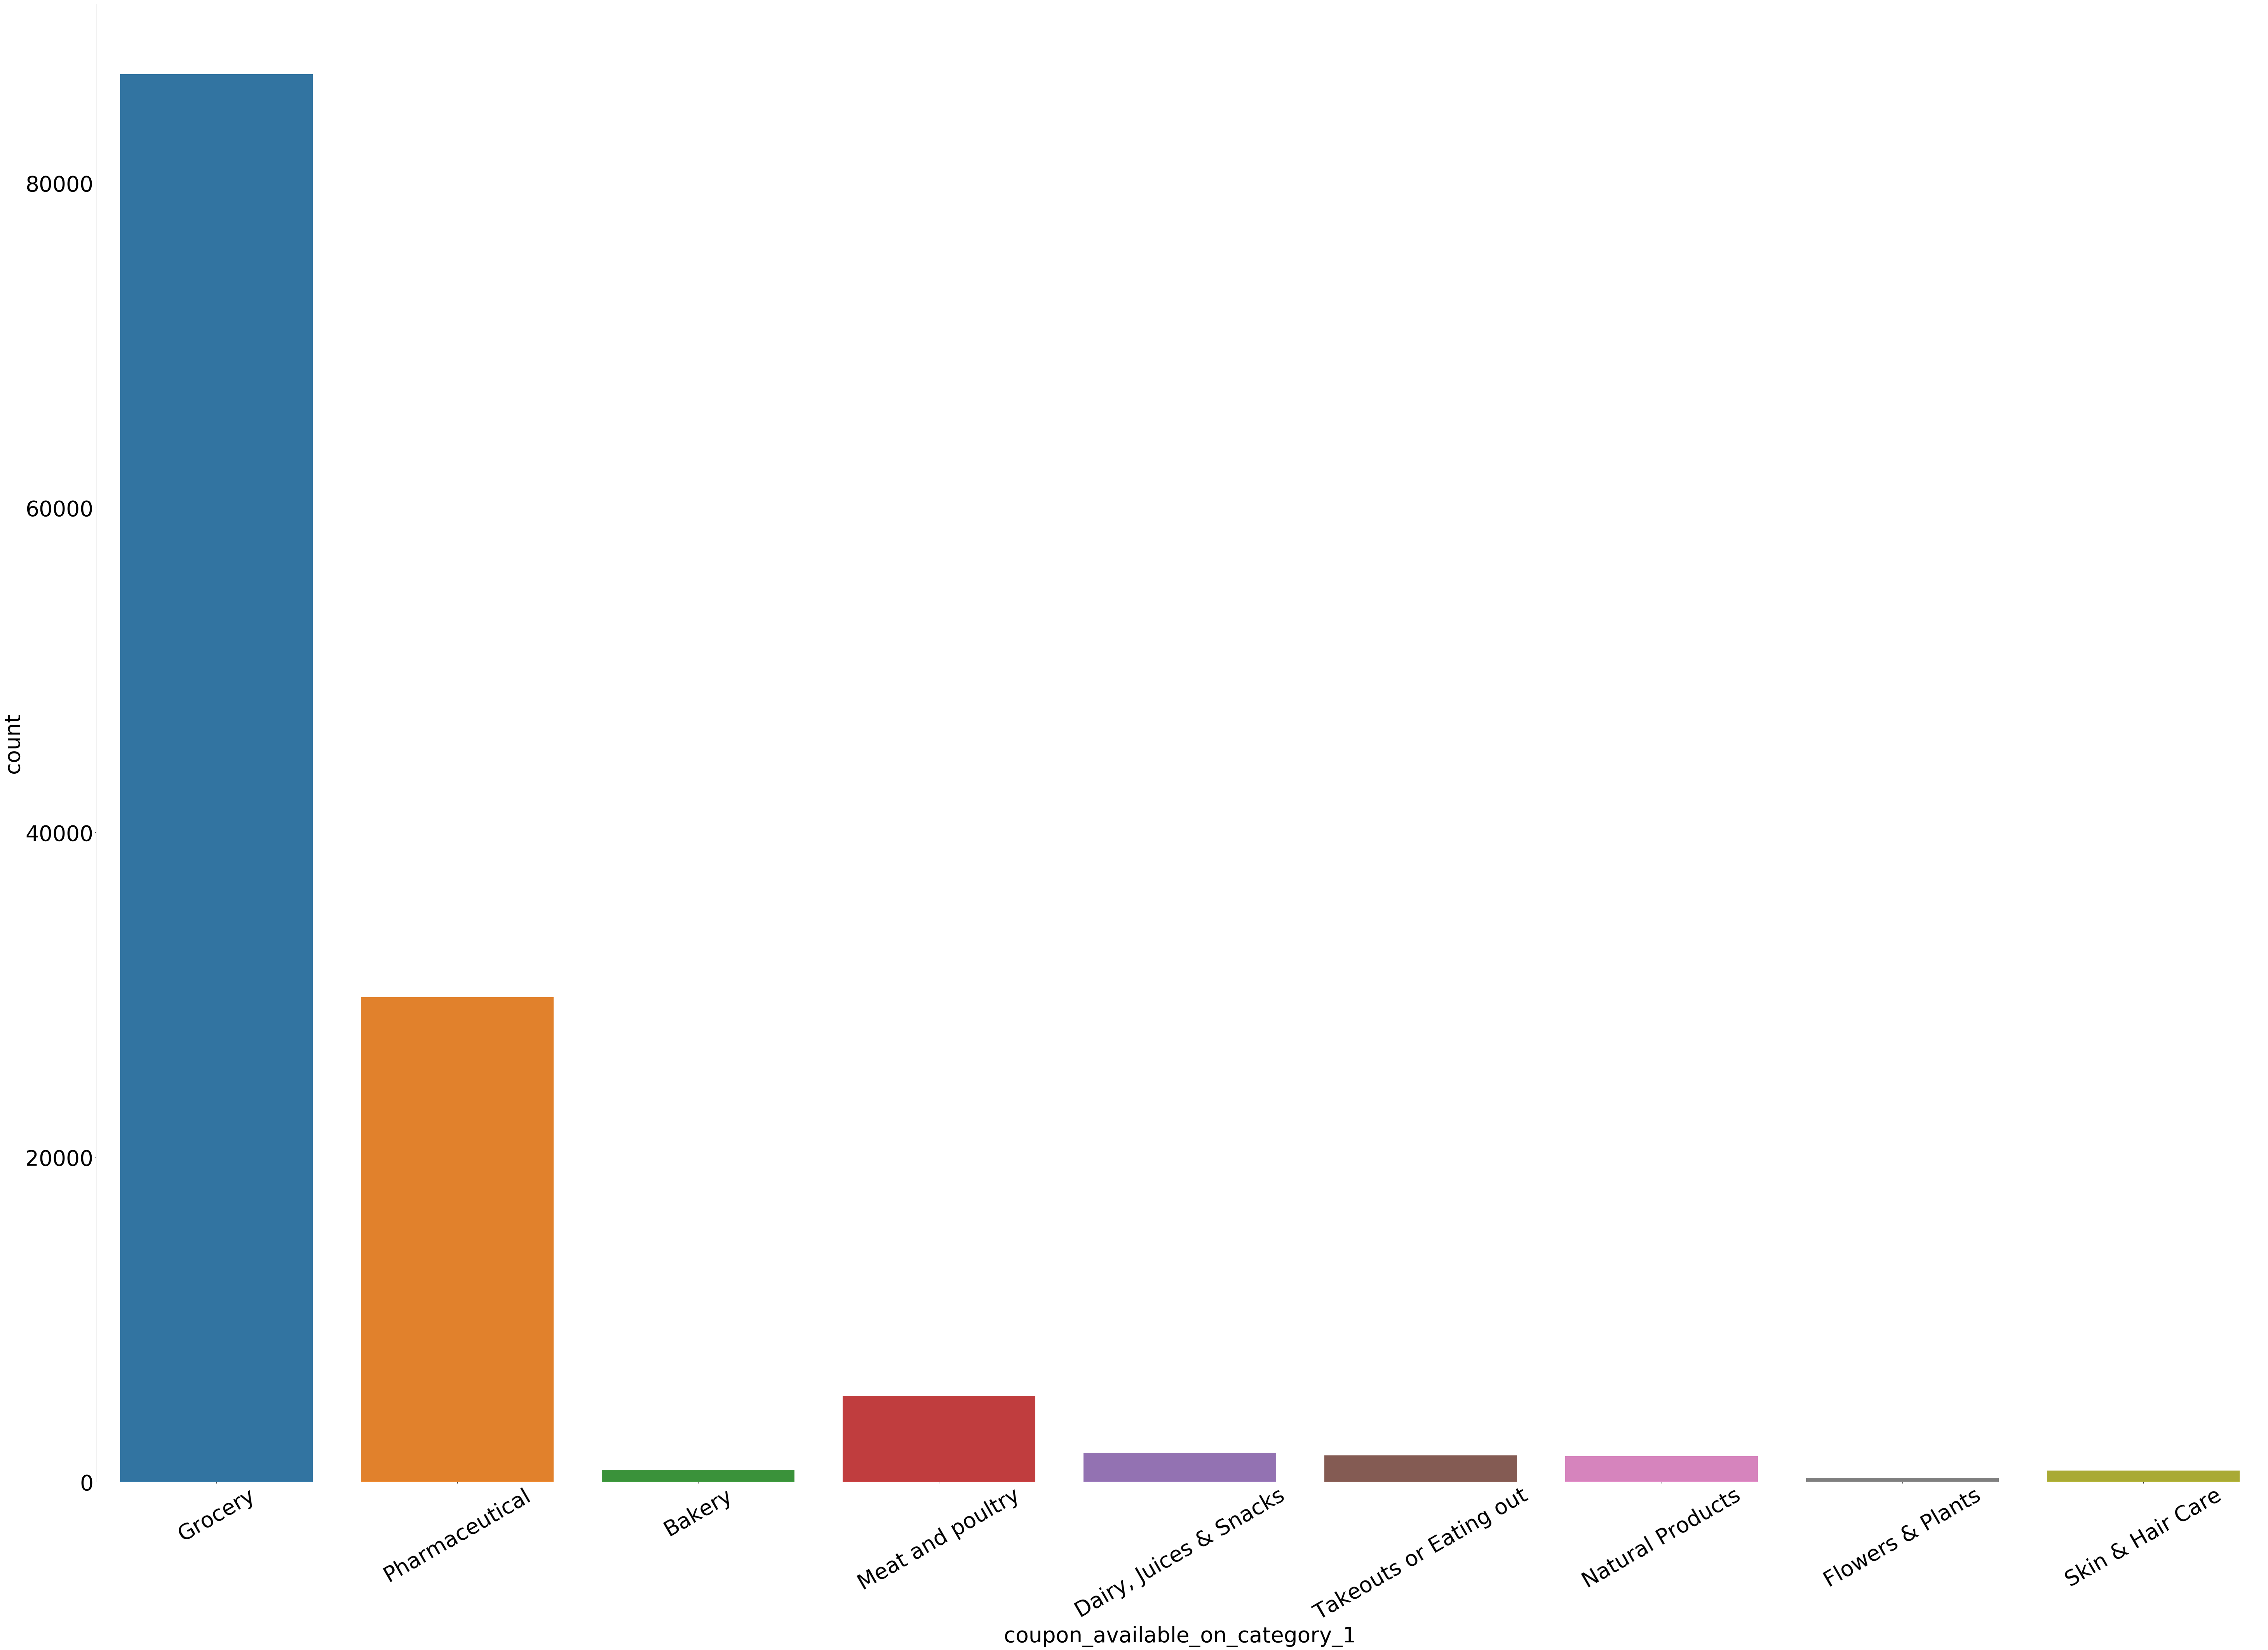

In [217]:
ax = sns.countplot(merged_data['coupon_available_on_category_1'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

coupon_available_on_category_2

In [218]:
%%time

def get_second_most_common_category (x):
    list_of_item_ids = x.split(",")
    list_of_category_of_items = item_data[item_data.item_id.isin(list_of_item_ids)].category.to_list()
    c = Counter(list_of_category_of_items)

    if (len(c.most_common(2)) >1):
        return (c.most_common(2)[1][0])
    else:
        return str(-1)

merged_data['coupon_available_on_category_2'] = merged_data['coupon_available_on_item_ids'].apply(get_second_most_common_category)




CPU times: user 6min 27s, sys: 4.1 s, total: 6min 31s
Wall time: 11min 39s


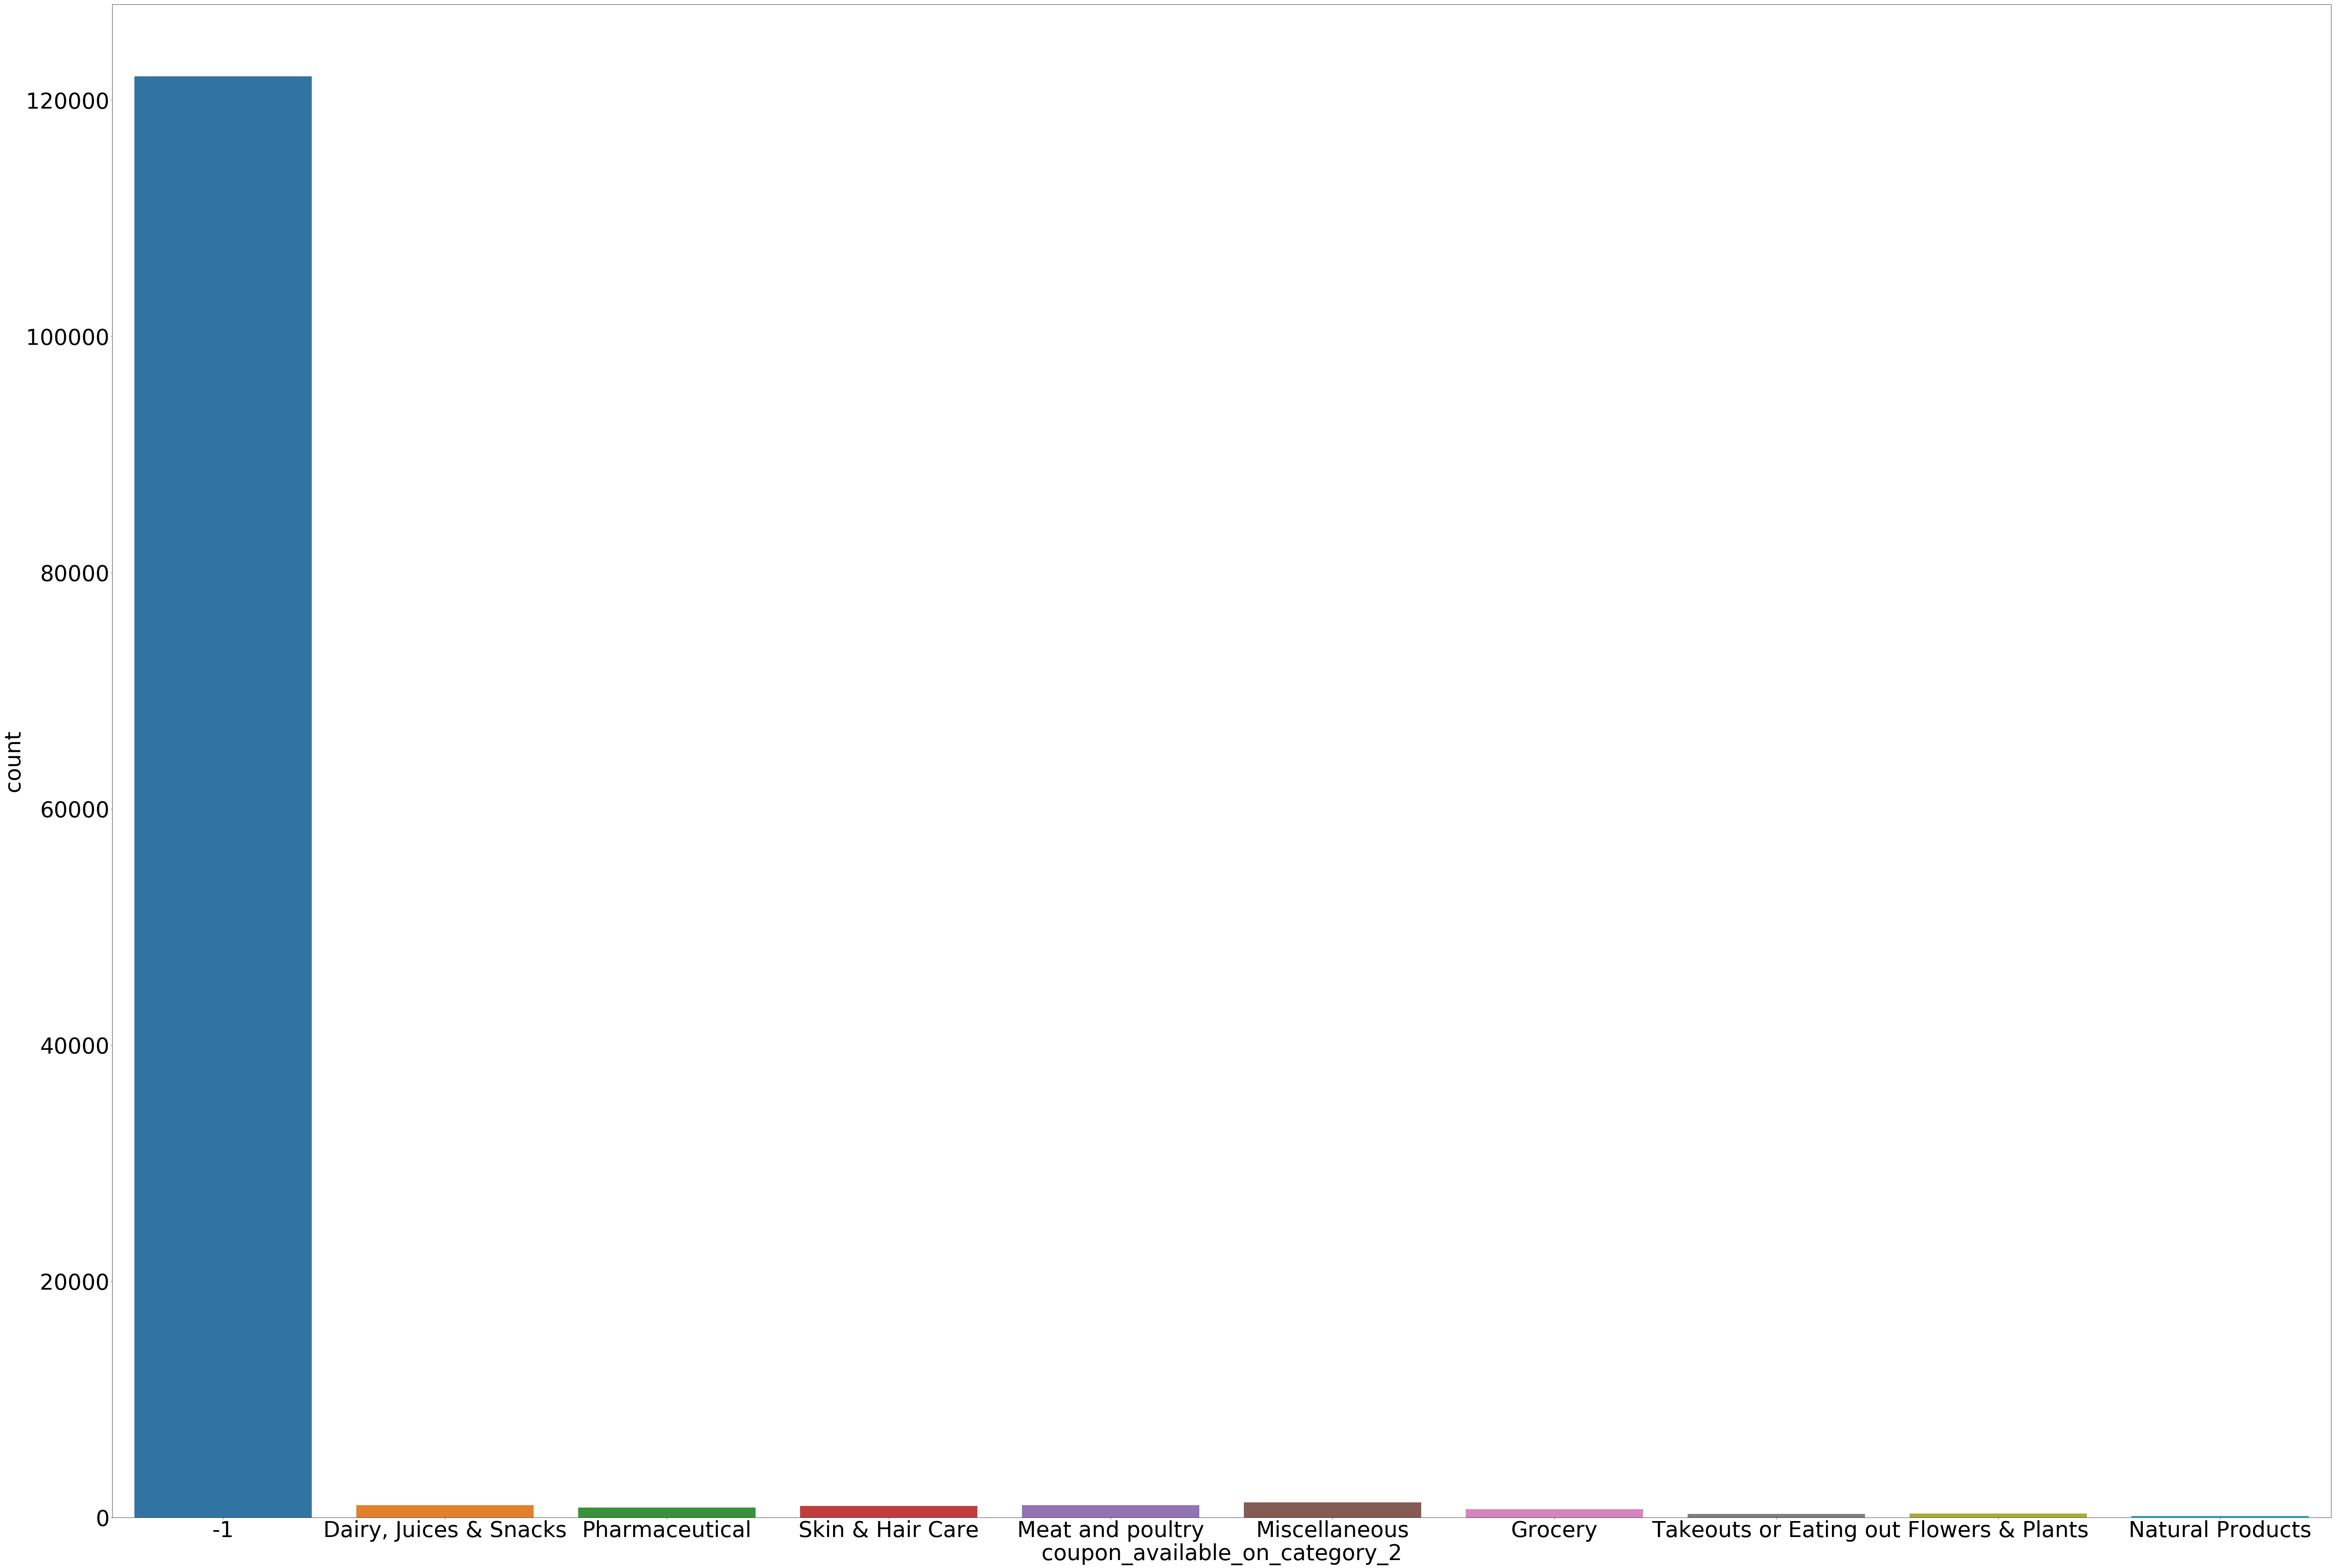

In [219]:
sns.countplot(merged_data['coupon_available_on_category_2'])

## Generating features from item_ids about the brands of item_ids

coupon_available_on_brand_1

In [220]:
%%time

def get_most_common_brand (x):
    list_of_item_ids = x.split(",")
    list_of_brand_of_items = item_data[item_data.item_id.isin(list_of_item_ids)].brand.to_list()
    c = Counter(list_of_brand_of_items)

    return (c.most_common(2)[0][0])

merged_data['coupon_available_on_brand_1'] = merged_data['coupon_available_on_item_ids'].apply(get_most_common_brand)

merged_data['coupon_available_on_brand_1']


CPU times: user 6min 28s, sys: 3.4 s, total: 6min 31s
Wall time: 11min 6s


[Text(0,0,'1'),
 Text(0,0,'5'),
 Text(0,0,'11'),
 Text(0,0,'17'),
 Text(0,0,'25'),
 Text(0,0,'40'),
 Text(0,0,'49'),
 Text(0,0,'53'),
 Text(0,0,'56'),
 Text(0,0,'57'),
 Text(0,0,'58'),
 Text(0,0,'63'),
 Text(0,0,'64'),
 Text(0,0,'67'),
 Text(0,0,'89'),
 Text(0,0,'101'),
 Text(0,0,'105'),
 Text(0,0,'112'),
 Text(0,0,'115'),
 Text(0,0,'119'),
 Text(0,0,'124'),
 Text(0,0,'132'),
 Text(0,0,'133'),
 Text(0,0,'141'),
 Text(0,0,'145'),
 Text(0,0,'147'),
 Text(0,0,'152'),
 Text(0,0,'158'),
 Text(0,0,'162'),
 Text(0,0,'167'),
 Text(0,0,'172'),
 Text(0,0,'178'),
 Text(0,0,'183'),
 Text(0,0,'189'),
 Text(0,0,'190'),
 Text(0,0,'201'),
 Text(0,0,'204'),
 Text(0,0,'206'),
 Text(0,0,'207'),
 Text(0,0,'209'),
 Text(0,0,'218'),
 Text(0,0,'224'),
 Text(0,0,'232'),
 Text(0,0,'233'),
 Text(0,0,'234'),
 Text(0,0,'235'),
 Text(0,0,'238'),
 Text(0,0,'240'),
 Text(0,0,'241'),
 Text(0,0,'244'),
 Text(0,0,'248'),
 Text(0,0,'255'),
 Text(0,0,'261'),
 Text(0,0,'278'),
 Text(0,0,'280'),
 Text(0,0,'281'),
 Text(0,0

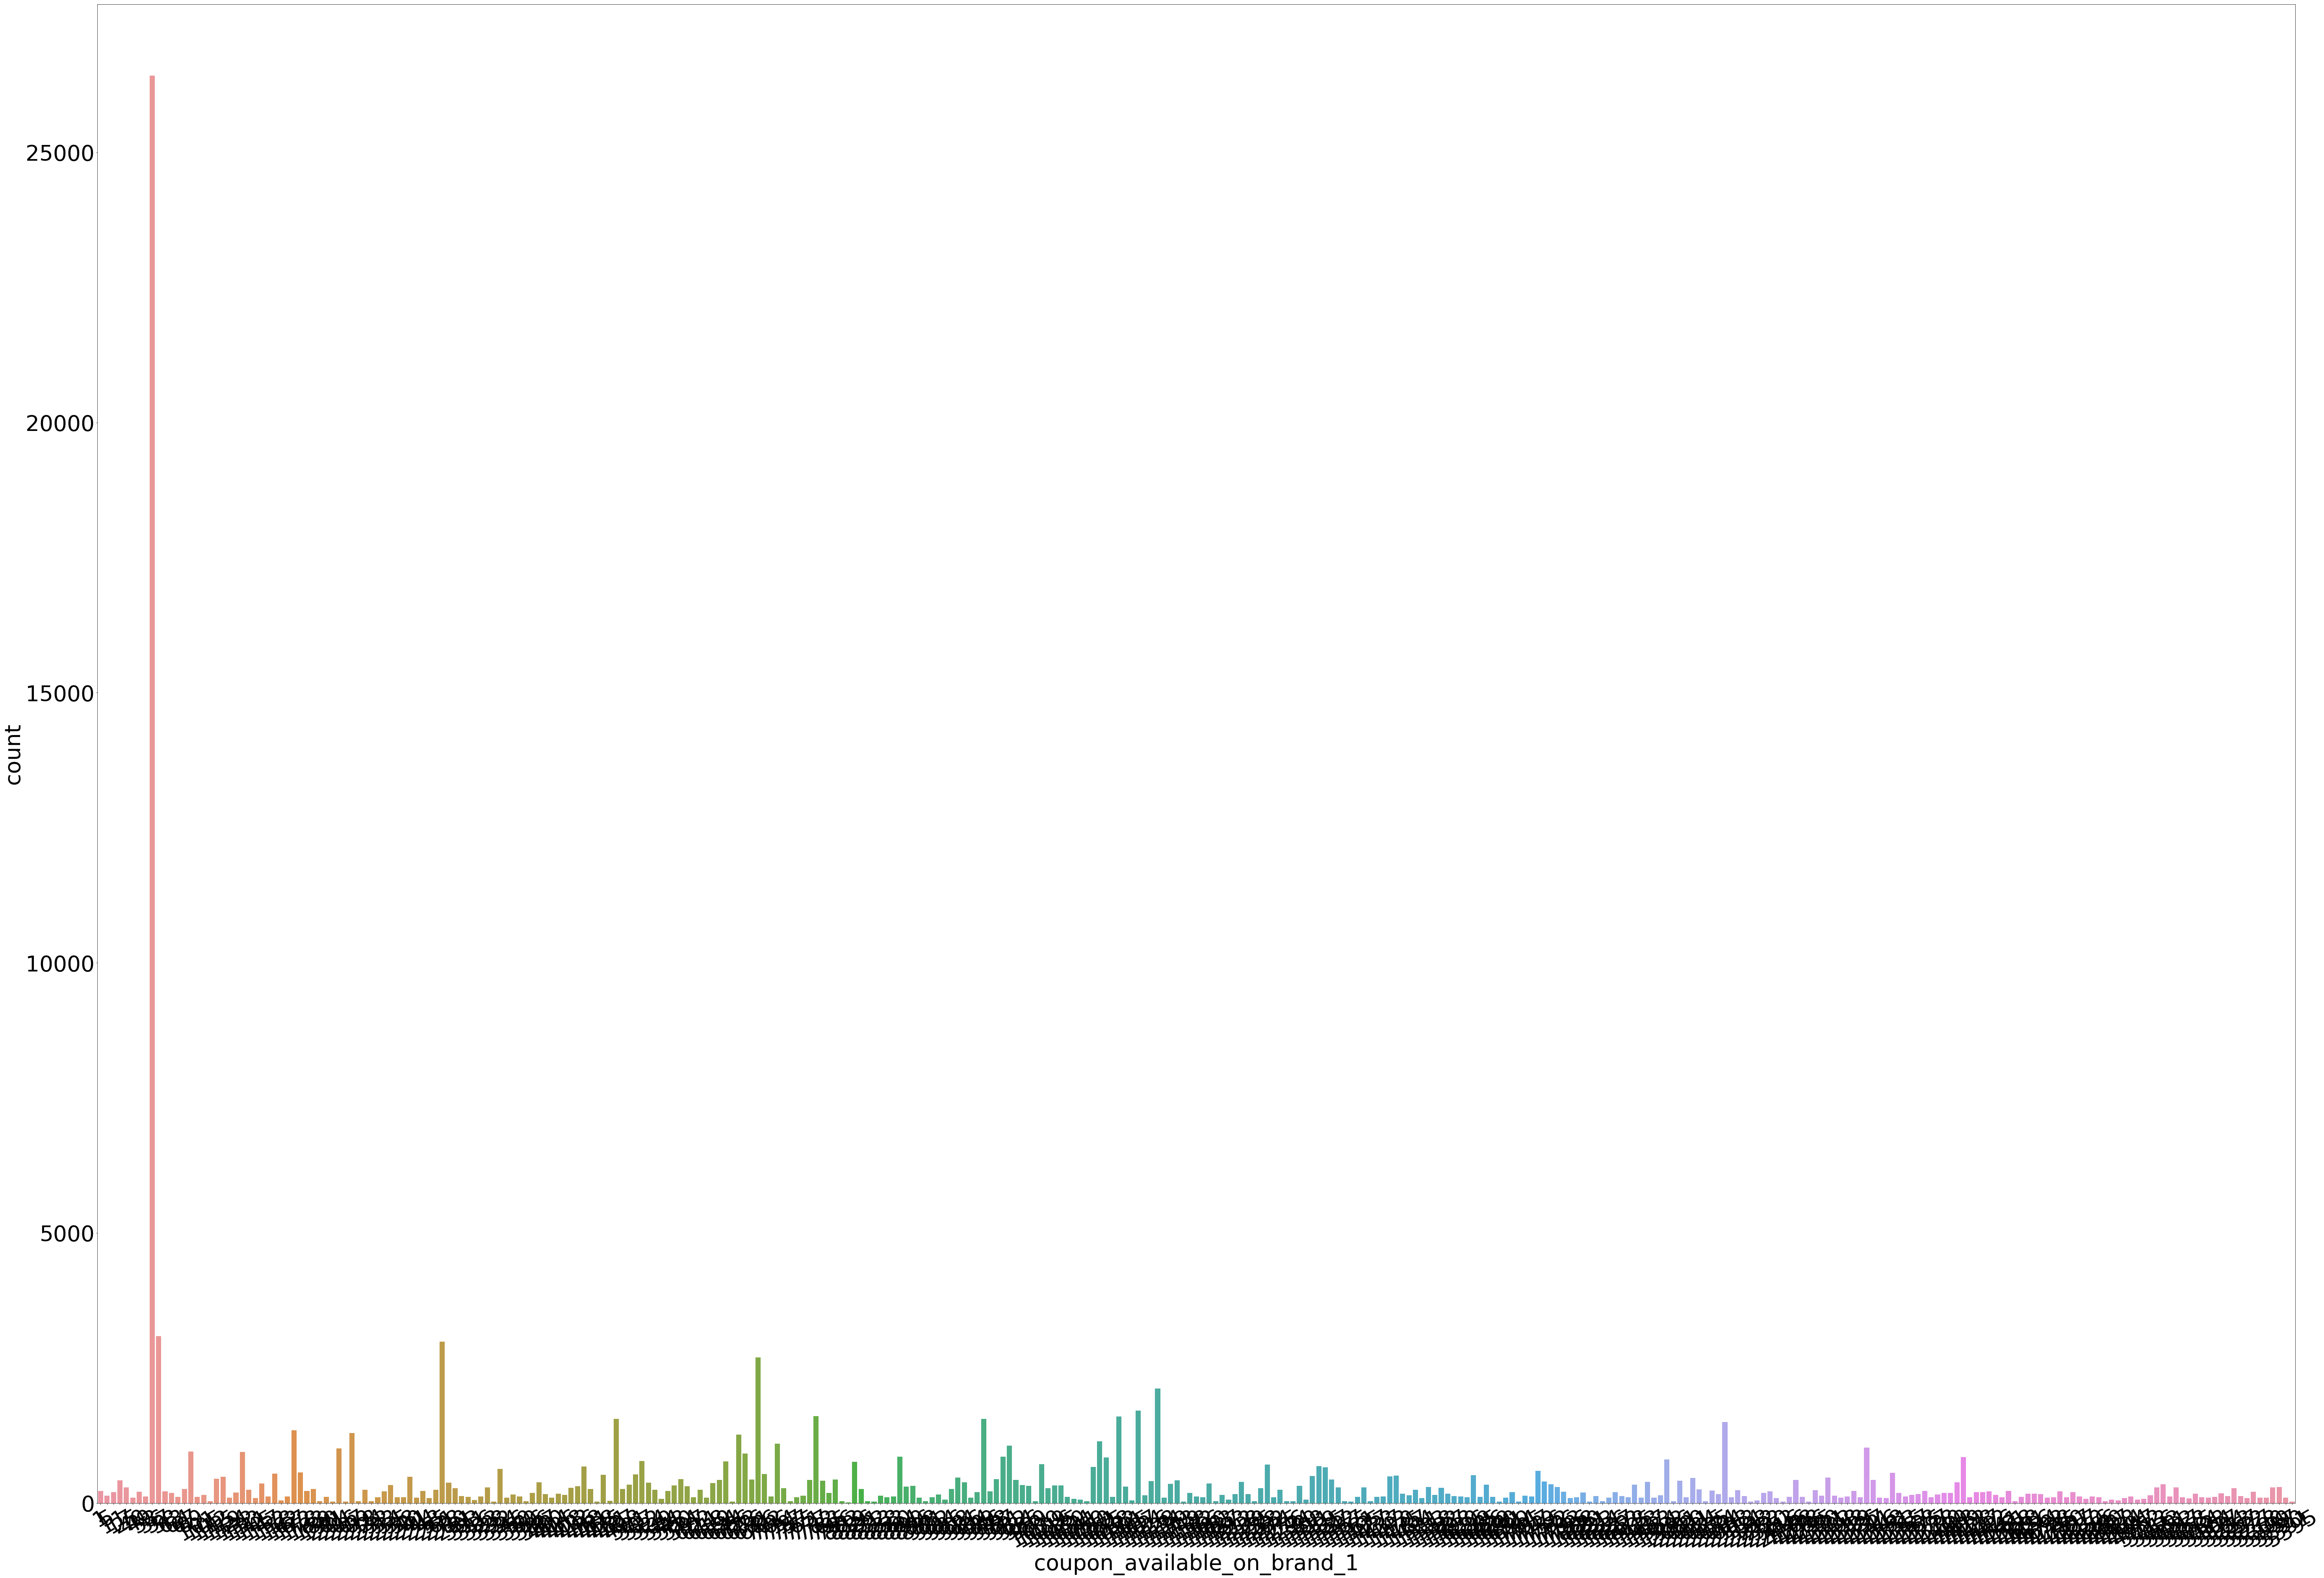

In [221]:
ax = sns.countplot(merged_data['coupon_available_on_brand_1'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

coupon_available_on_brand_2

In [222]:
%%time

def get_second_most_common_brand (x):
    list_of_item_ids = x.split(",")
    list_of_brand_of_items = item_data[item_data.item_id.isin(list_of_item_ids)].brand.to_list()
    c = Counter(list_of_brand_of_items)
    
    if (len(c.most_common(2)) > 1):
        return (c.most_common(2)[1][0])
    else:
        return -1
    

merged_data['coupon_available_on_brand_2'] = merged_data['coupon_available_on_item_ids'].apply(get_second_most_common_brand)

merged_data['coupon_available_on_brand_2']



CPU times: user 6min 32s, sys: 3.57 s, total: 6min 36s
Wall time: 11min 22s


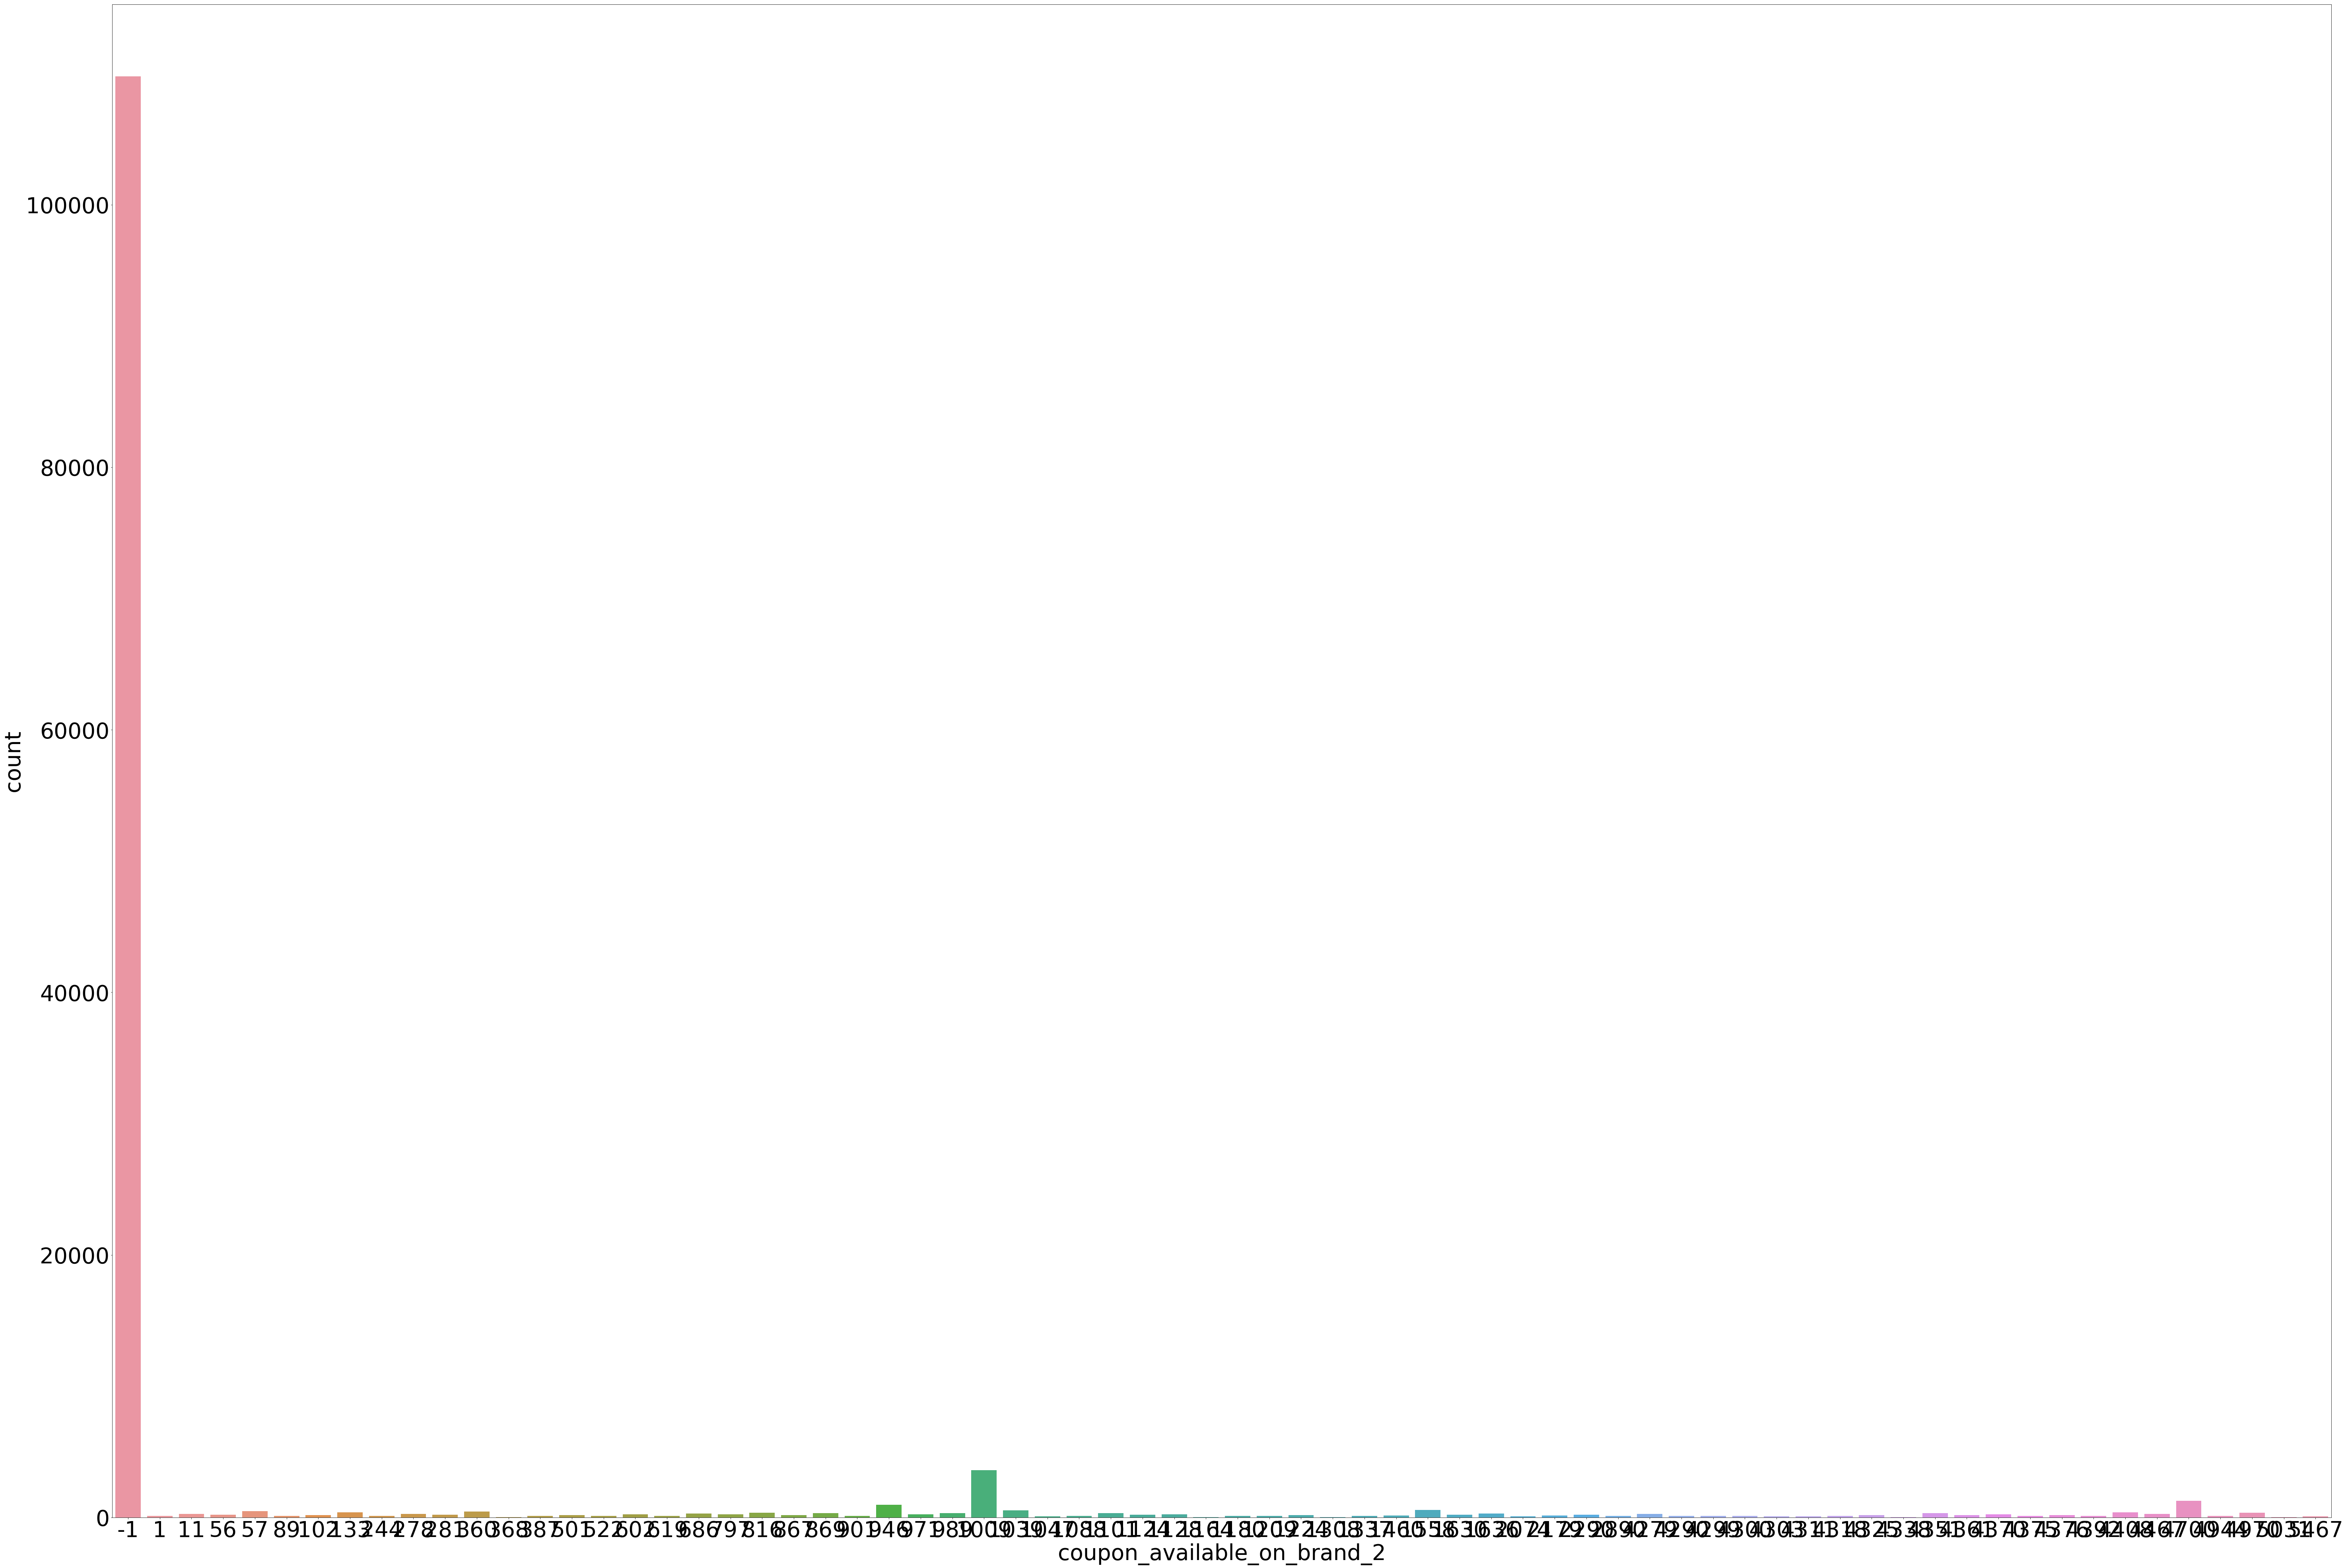

In [223]:
sns.countplot(merged_data['coupon_available_on_brand_2'])

coupon_more_focussed_on_brand_type

In [224]:
%%time

def get_established_brand_focus (x):
    list_of_item_ids = x.split(",")
    list_of_brand_type_of_items = item_data[item_data.item_id.isin(list_of_item_ids)].brand_type.to_list()
    c = Counter(list_of_brand_type_of_items)
    
    return (c.most_common(2)[0][0])
    

merged_data['coupon_more_focussed_on_brand_type'] = merged_data['coupon_available_on_item_ids'].apply(get_established_brand_focus)

merged_data['coupon_more_focussed_on_brand_type']



CPU times: user 6min 31s, sys: 3.29 s, total: 6min 34s
Wall time: 10min 32s


popularity_of_category1

In [225]:
size_of_transactions_on_coupons = customer_transaction_data_on_coupons.groupby(by='category').size()
size_of_transactions_without_coupons = customer_transaction_data_without_coupons.groupby(by='category').size()


In [226]:
%%time 
size_of_transactions_on_coupons['Bakery'] + size_of_transactions_without_coupons['Bakery']

CPU times: user 220 µs, sys: 19 µs, total: 239 µs
Wall time: 248 µs


18218

In [227]:
%%time

total_buys = customer_transaction_data_on_coupons.shape[0]+customer_transaction_data_without_coupons.shape[0]
def find_popularity_fraction_category1 (x):
    total_buys_on_category1 = size_of_transactions_on_coupons[x]+size_of_transactions_without_coupons[x]
    
    return total_buys_on_category1/total_buys

merged_data['popularity_of_category1'] = merged_data['coupon_available_on_category_1'].apply(find_popularity_fraction_category1)

CPU times: user 4.99 s, sys: 91.7 ms, total: 5.08 s
Wall time: 7.78 s


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


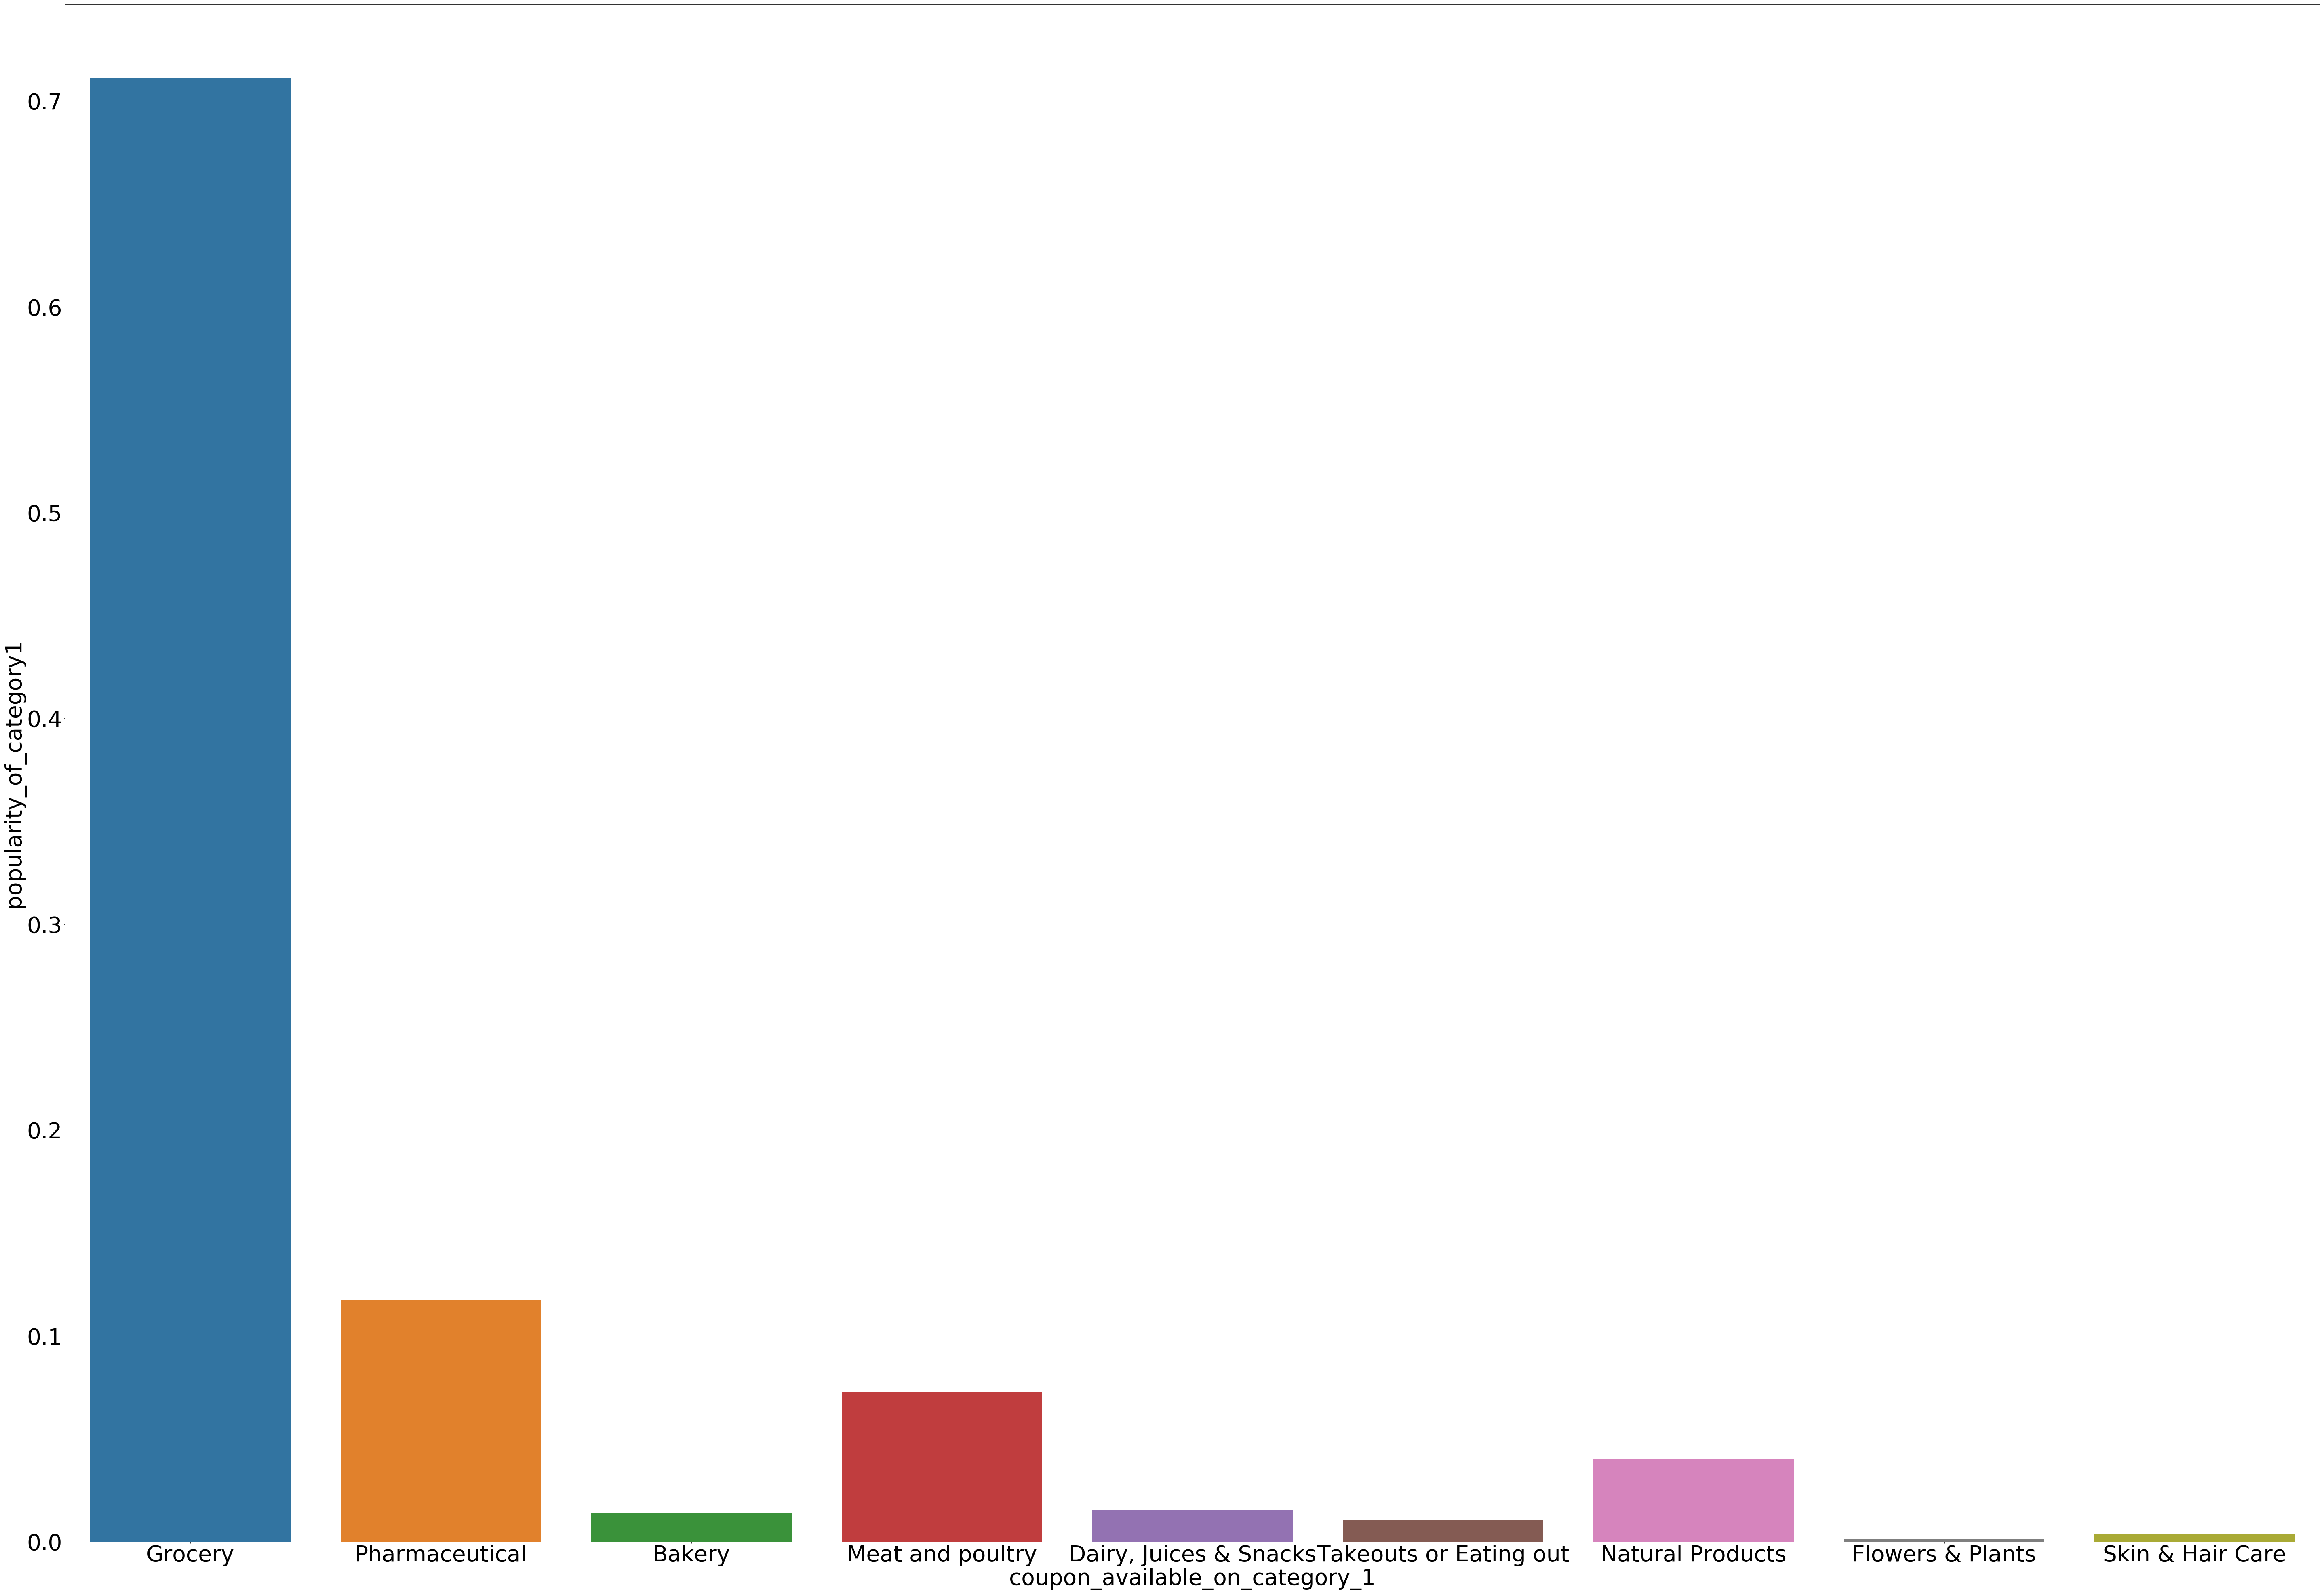

In [228]:
sns.barplot(x='coupon_available_on_category_1', y='popularity_of_category1', data=merged_data)

popularity_of_category2

In [229]:
%%time
def find_popularity_fraction_category2 (x):
    try:
        total_buys_on_category2 =  size_of_transactions_on_coupons[x]+size_of_transactions_without_coupons[x]
        return (total_buys_on_category2/total_buys)
    except:
        return 0
merged_data['popularity_of_category2'] = merged_data['coupon_available_on_category_2'].apply(find_popularity_fraction_category2)

CPU times: user 5.85 s, sys: 56 ms, total: 5.91 s
Wall time: 8.92 s


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


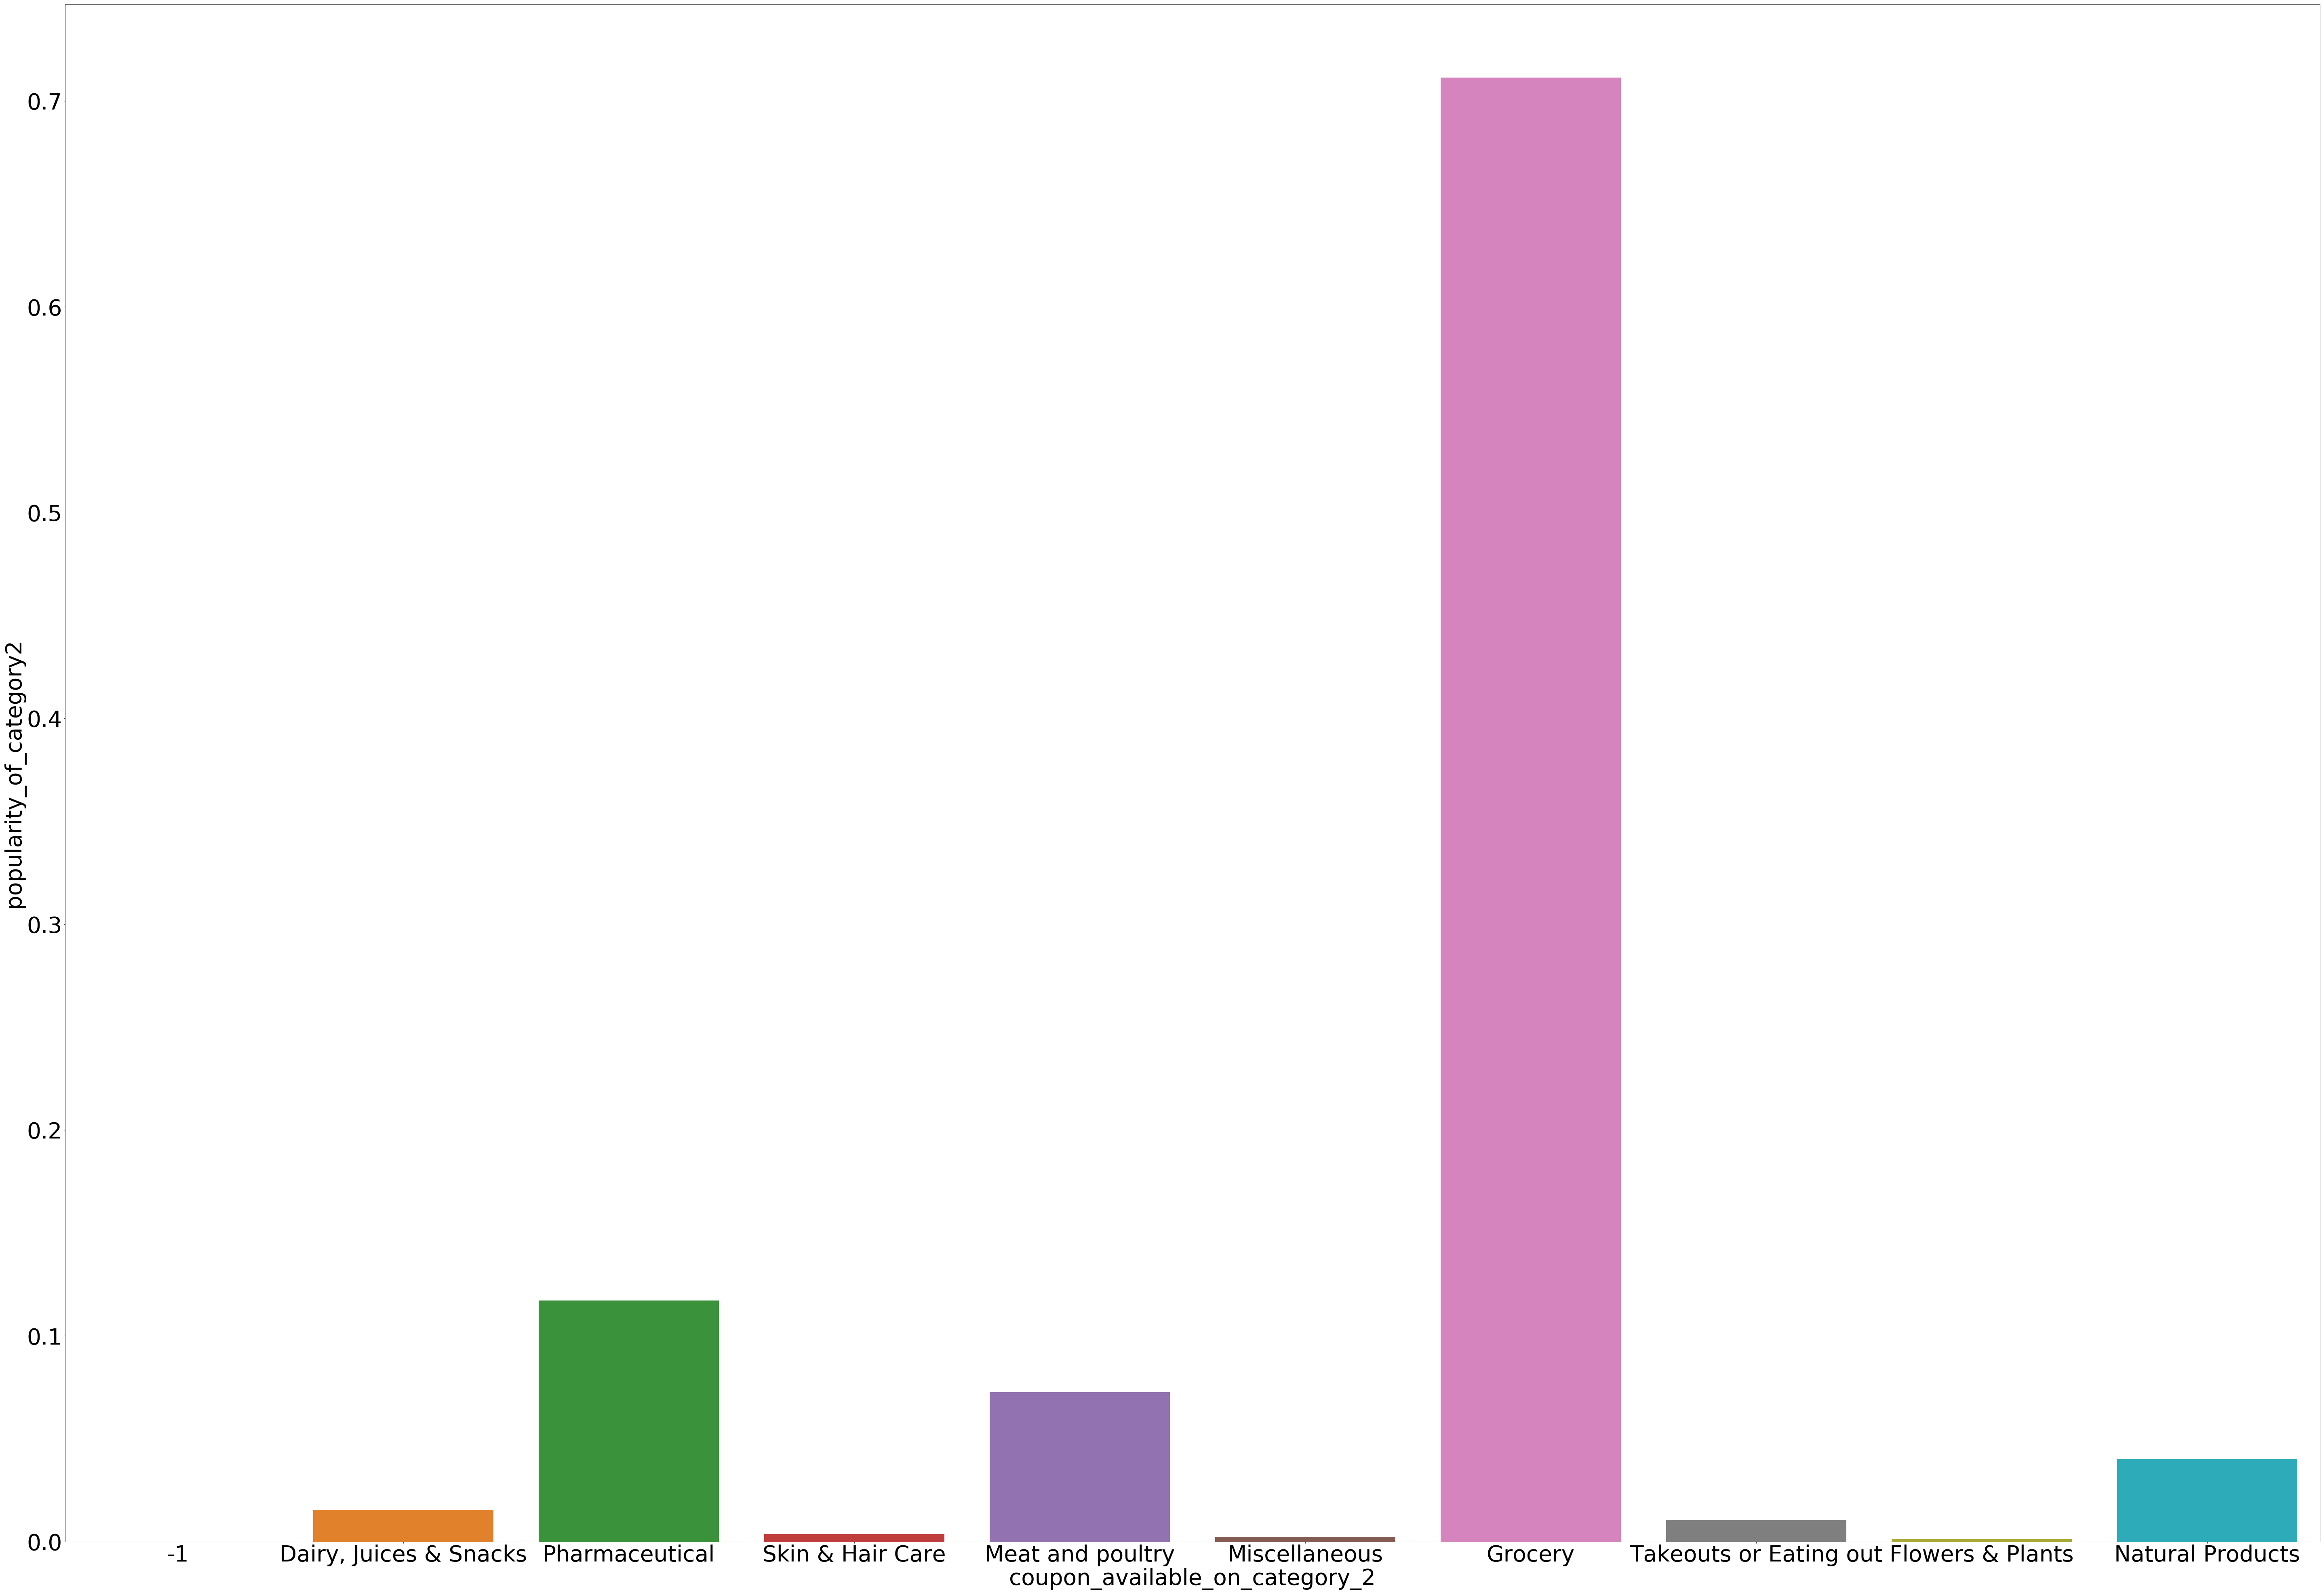

In [230]:
sns.barplot(x='coupon_available_on_category_2', y='popularity_of_category2', data=merged_data)

popularity_of_brand1

In [231]:
size_of_transactions_on_coupons = customer_transaction_data_on_coupons.groupby(by='brand').size()
size_of_transactions_without_coupons = customer_transaction_data_without_coupons.groupby(by='brand').size()


In [232]:
%%time


total_buys = customer_transaction_data_on_coupons.shape[0]+customer_transaction_data_without_coupons.shape[0]

def find_popularity_fraction_brand1 (x):
    try:
        total_buys_on_brand1 = size_of_transactions_on_coupons[x]+size_of_transactions_without_coupons[x]
        return total_buys_on_brand1/total_buys
    except:
        #Since all brands may not have transaction data
        return 0
merged_data['popularity_of_brand1'] = merged_data['coupon_available_on_brand_1'].apply(find_popularity_fraction_brand1)

CPU times: user 5.91 s, sys: 51.2 ms, total: 5.96 s
Wall time: 9.04 s


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


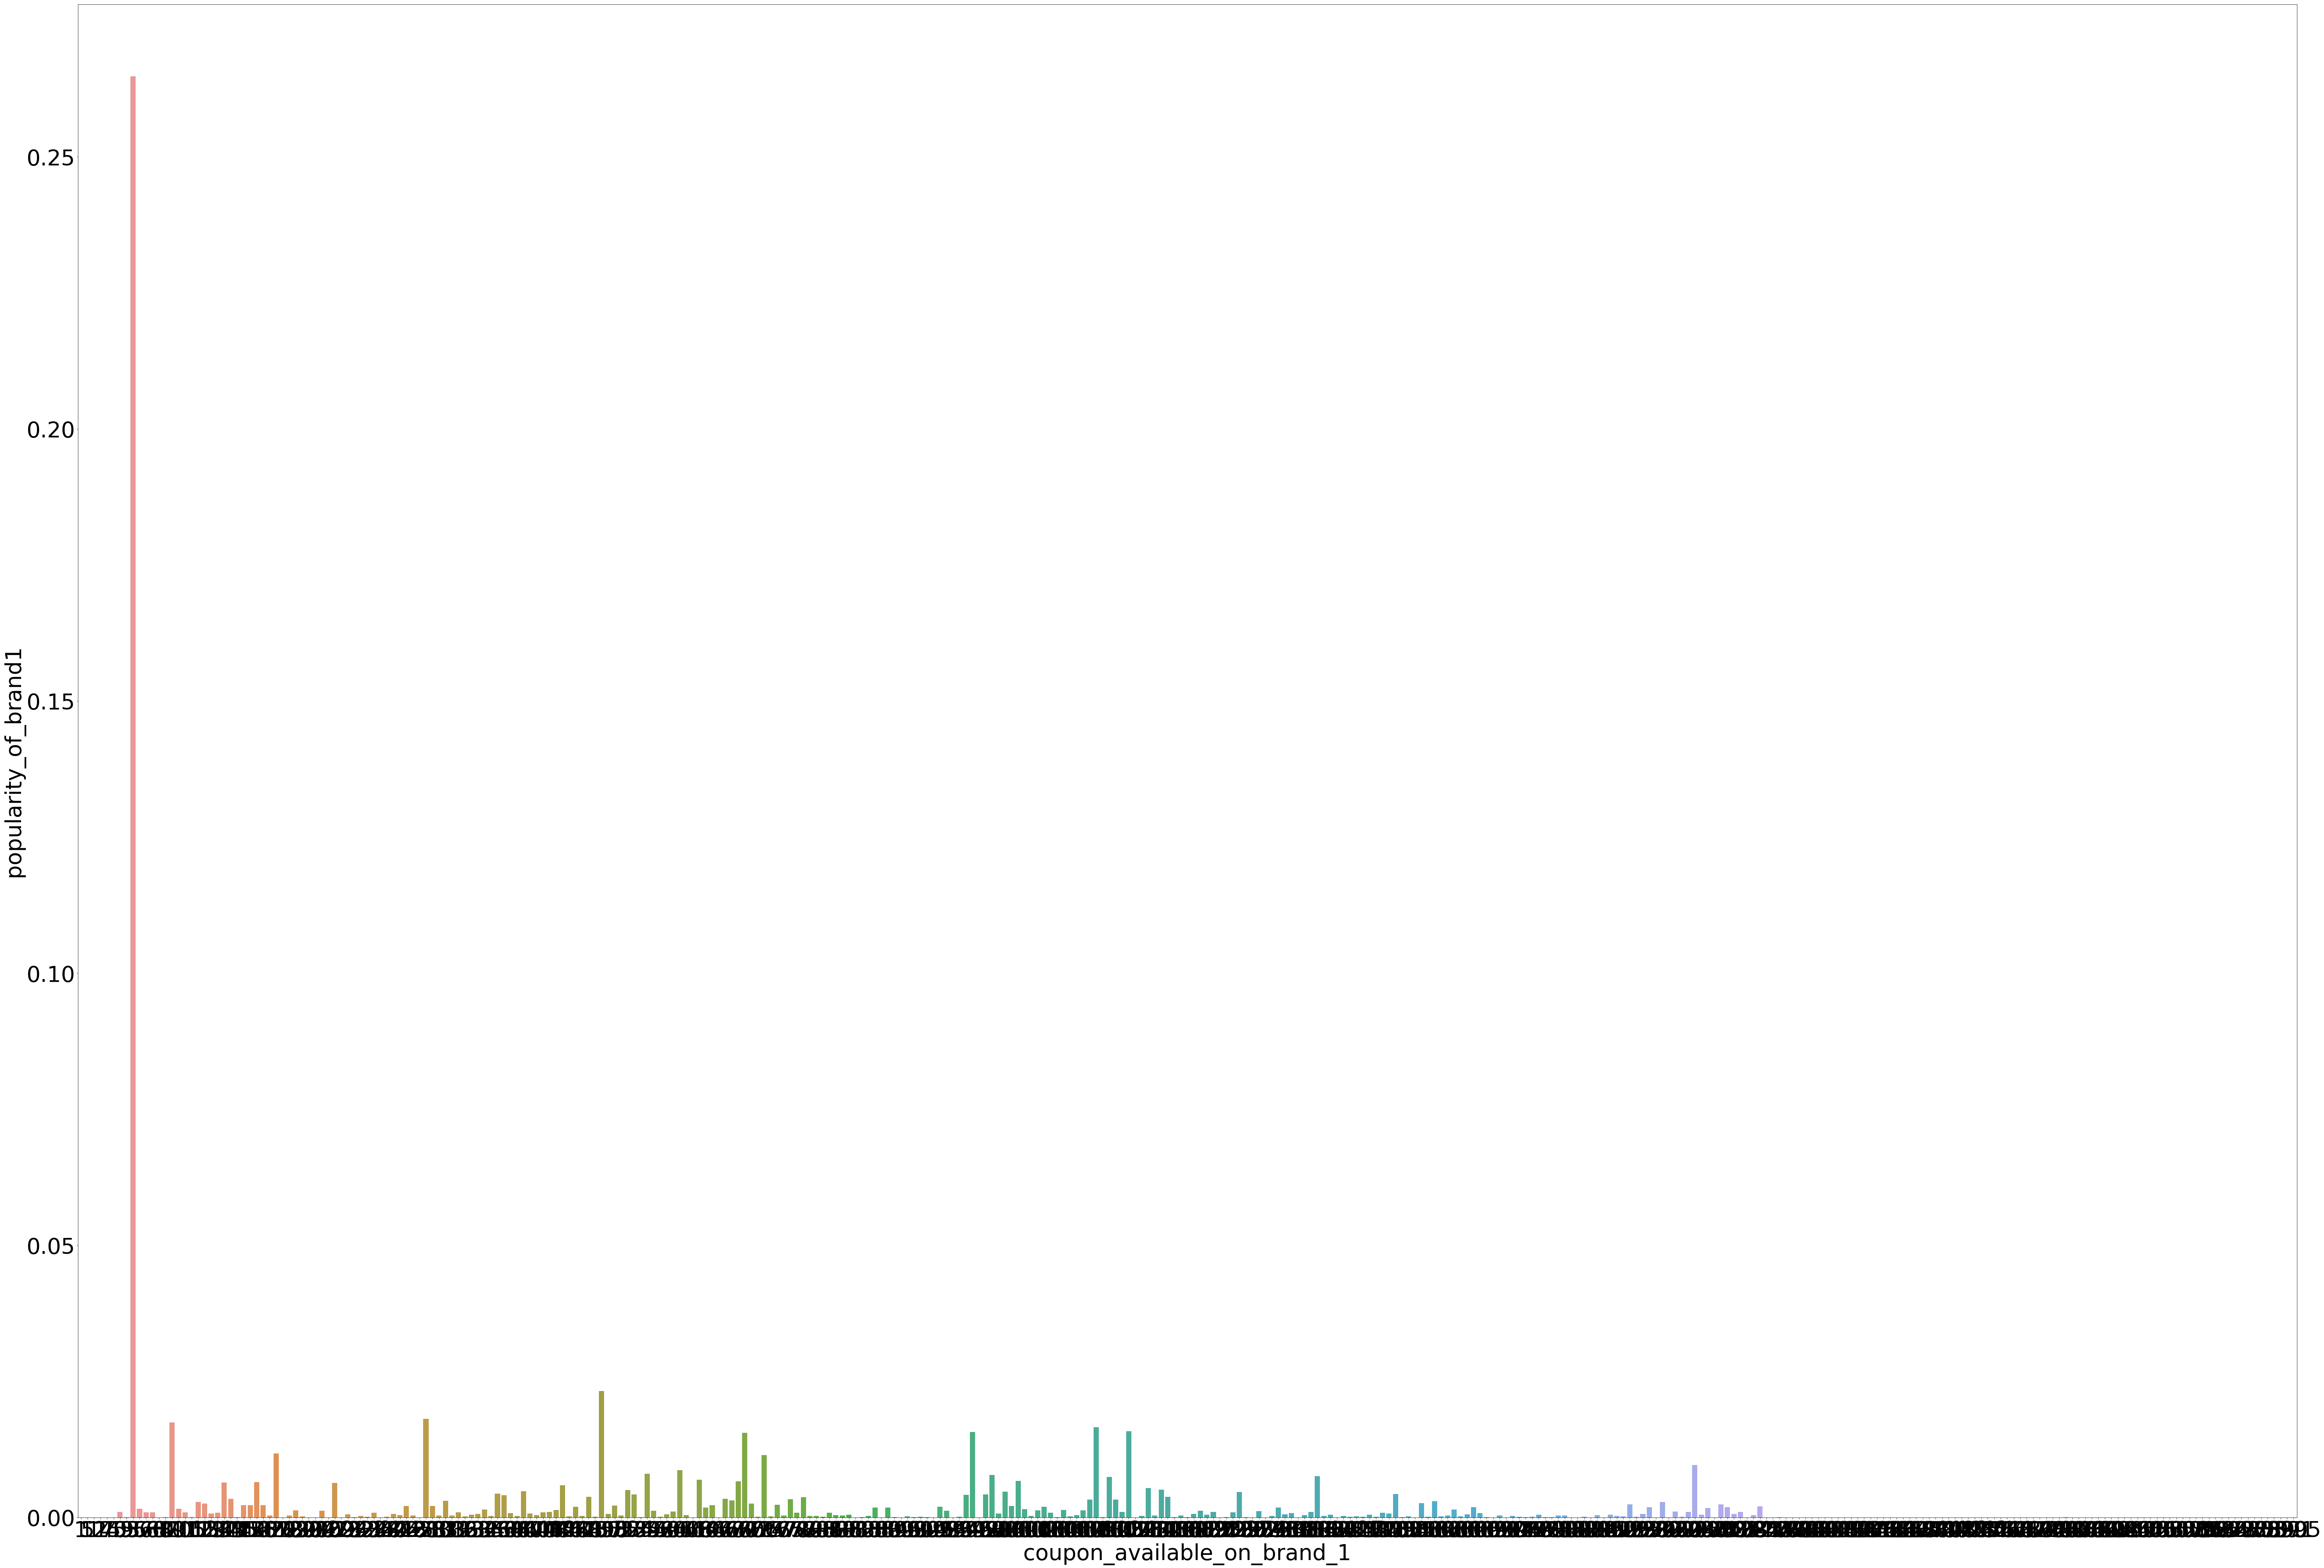

In [233]:
sns.barplot(x='coupon_available_on_brand_1', y='popularity_of_brand1', data=merged_data)

popularity_of_brand2

In [234]:
%%time
def find_popularity_fraction_brand2 (x):
    try:
        total_buys_on_brand2 = size_of_transactions_on_coupons[x]+size_of_transactions_without_coupons[x]
    except:
        return 0
    
    if (x == '-1'):
        return 0
    else:
        return (total_buys_on_brand2/total_buys)
merged_data['popularity_of_brand2'] = merged_data['coupon_available_on_brand_2'].apply(find_popularity_fraction_brand2)

CPU times: user 5.91 s, sys: 45.2 ms, total: 5.95 s
Wall time: 9.02 s


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


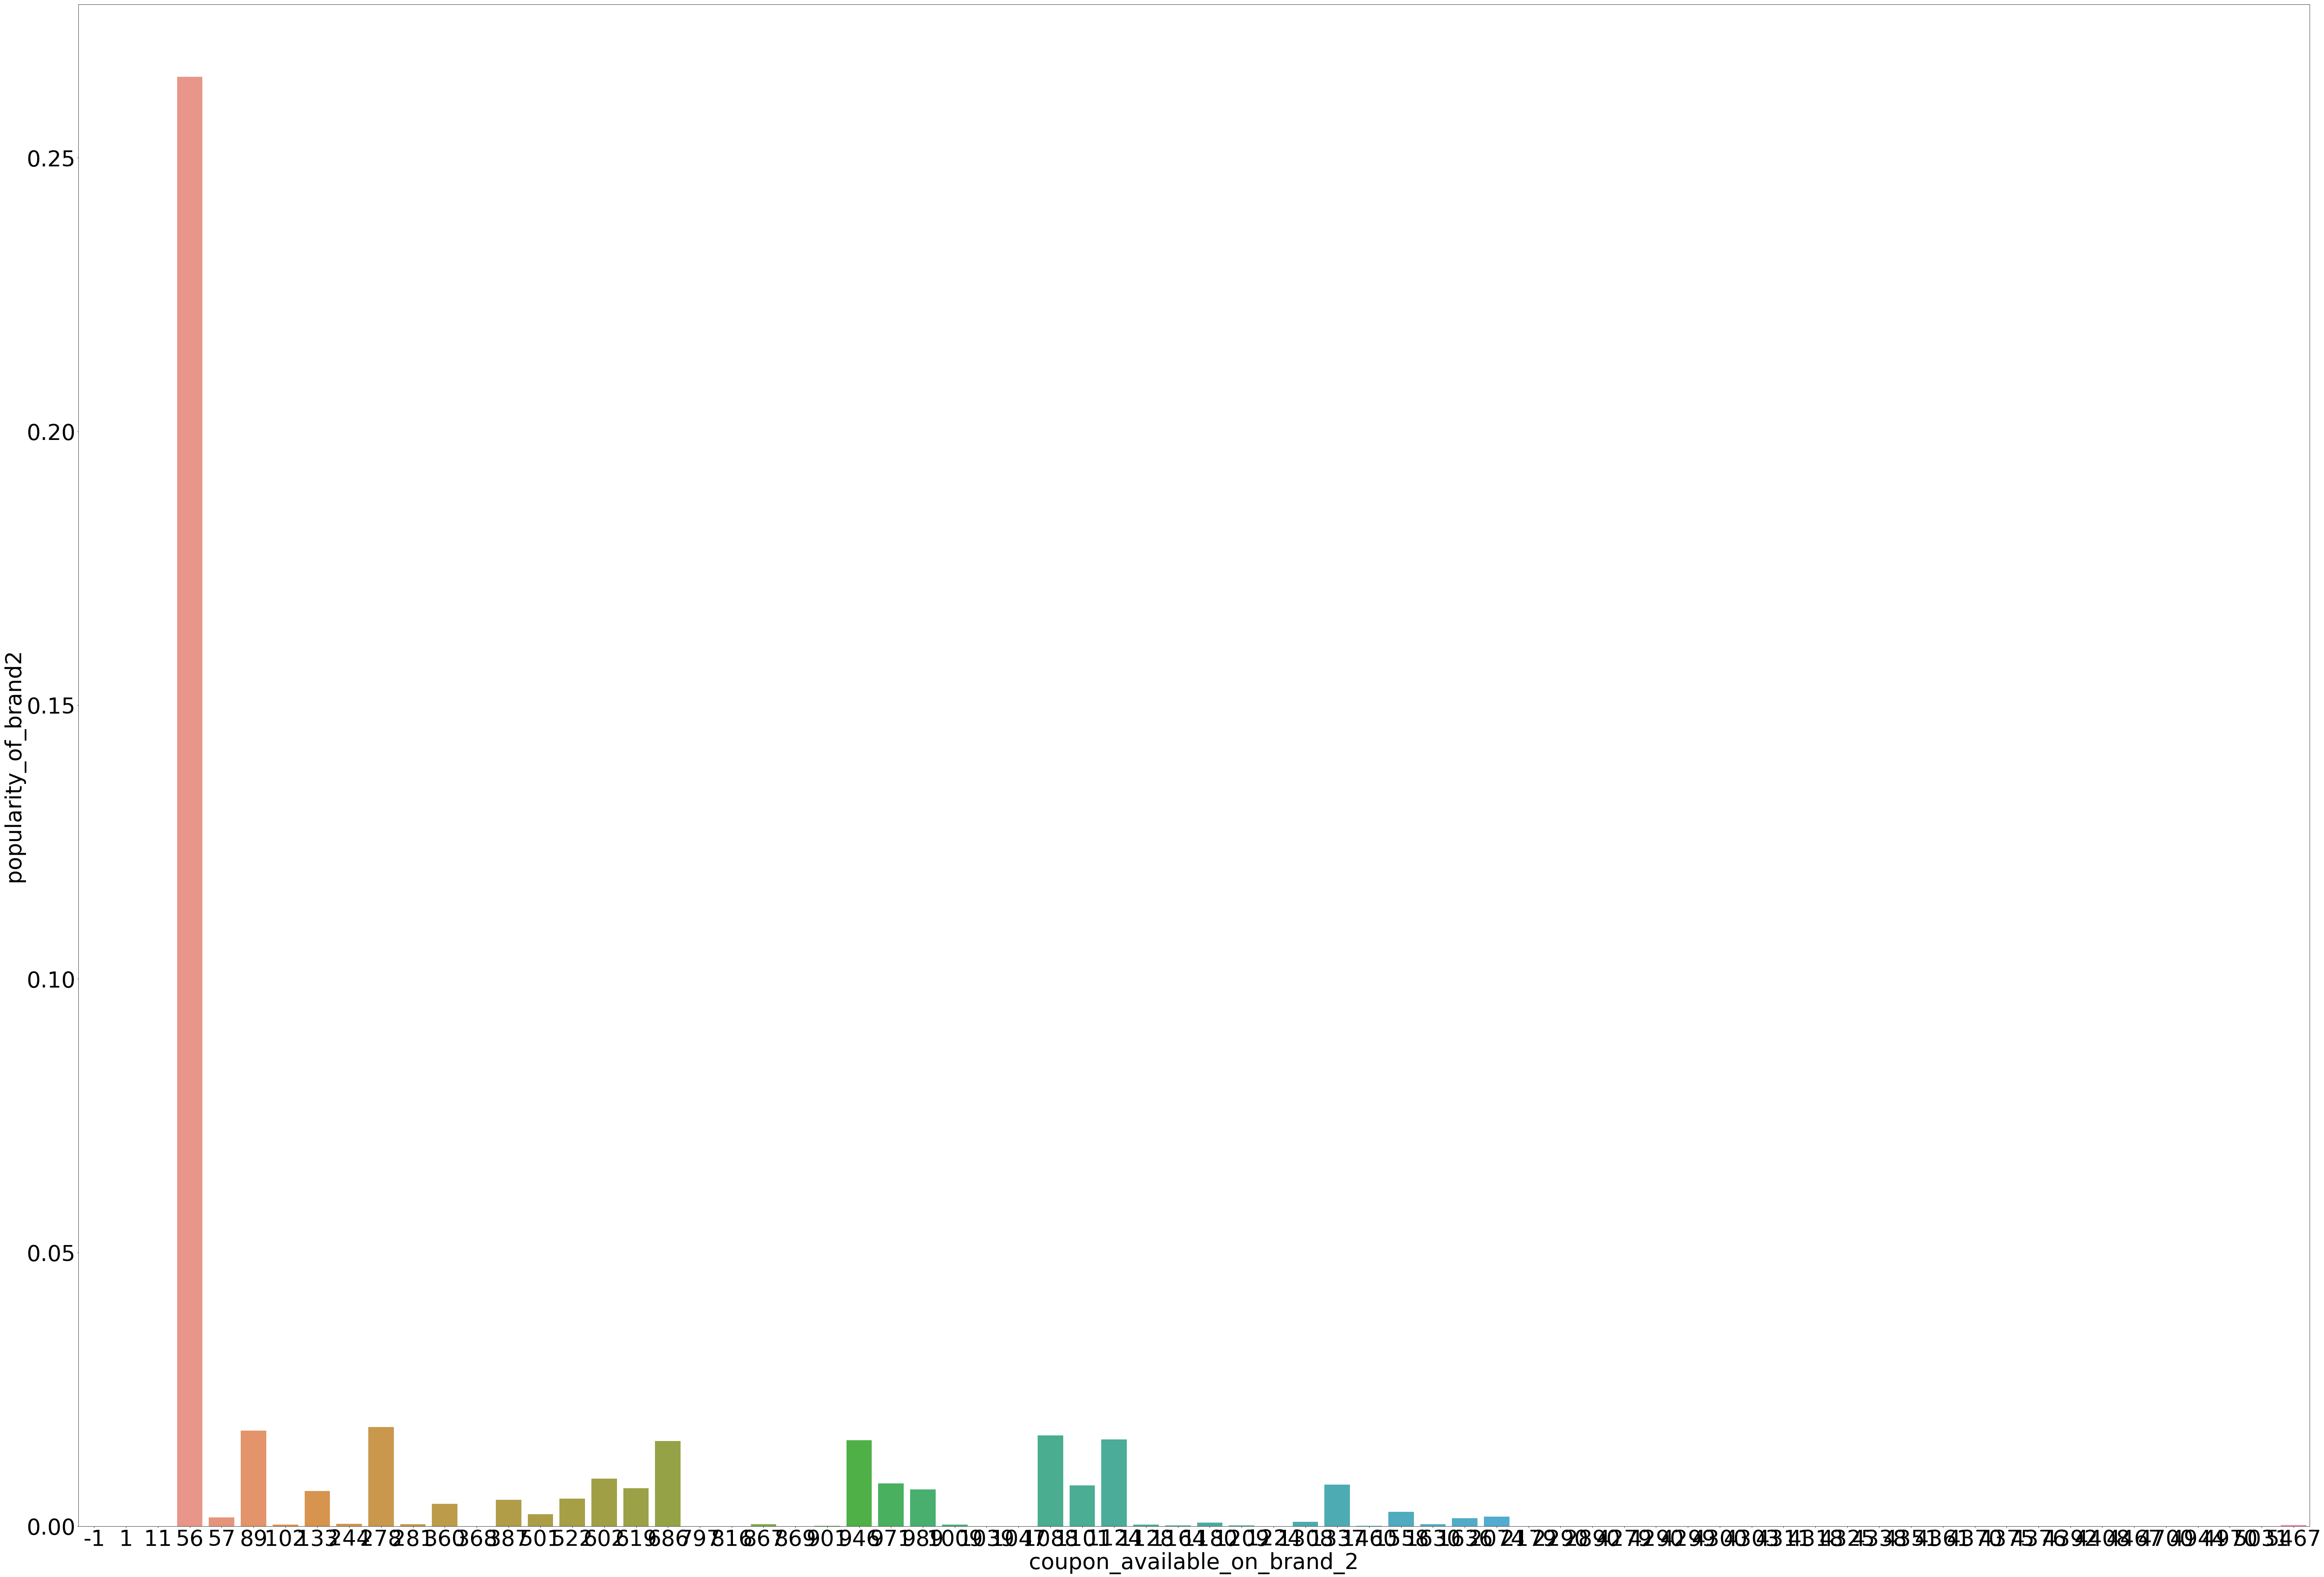

In [235]:
sns.barplot(x='coupon_available_on_brand_2', y='popularity_of_brand2', data=merged_data)

mean_discount_on_category1

In [236]:
customer_transaction_data = customer_transaction_data_without_coupons.append(customer_transaction_data_on_coupons)
customer_transaction_data['total_discount'] = -1*(customer_transaction_data['other_discount']+customer_transaction_data['coupon_discount'])
customer_transaction_data['total_discount_percentage'] = (customer_transaction_data['total_discount']/customer_transaction_data['selling_price'])*100
customer_transaction_data

date  customer_id  item_id  quantity  selling_price  \
0      2012-01-02         1501    26830         1          35.26   
1      2012-01-02         1501    54253         1          53.43   
2      2012-01-02         1501    31962         1         106.50   
3      2012-01-02         1501    33647         1          67.32   
4      2012-01-02         1501    48199         1          71.24   
...           ...          ...      ...       ...            ...   
21281  2013-07-03          384    12071         1          53.43   
21282  2013-07-03          384    22269         1          53.43   
21283  2013-07-03          384    33382         2         106.86   
21284  2013-07-03         1303    69686         1          78.36   
21285  2013-07-03          621    72243         1         138.56   

       other_discount  coupon_discount  brand   brand_type          category  \
0              -10.69             0.00     56        Local  Natural Products   
1              -13.89             0.00     56        Local  Natural Products   
2              -14.25             0.00    524  Established           Grocery   
3                0.00             0.00   1134  Established           Grocery   
4              -28.14             0.00    524  Established           Grocery   
...               ...              ...    ...          ...               ...   
21281          -26.71           -17.81   1105  Established           Grocery   
21282          -26.71           -17.81   1105  Established           Grocery   
21283          -53.43           -35.62   1105  Established           Grocery   
21284            0.00           -35.62    522  Established           Grocery   
21285            0.00           -35.62   2134  Established    Pharmaceutical   

       total_discount  total_discount_percentage  
0               10.69                  30.317640  
1               13.89                  25.996631  
2               14.25                  13.380282  
3               -0.00                  -0.000000  
4               28.14                  39.500281  
...               ...                        ...  
21281           44.52                  83.323975  
21282           44.52                  83.323975  
21283           89.05                  83.333333  
21284           35.62                  45.456866  
21285           35.62                  25.707275  

[1324566 rows x 12 columns]

In [237]:
s =customer_transaction_data.groupby(by='category').agg('mean')['total_discount_percentage']
s

category
Alcohol                    0.000000
Bakery                    10.946670
Dairy, Juices & Snacks    15.867442
Flowers & Plants           1.347863
Garden                     5.326877
Grocery                   22.507003
Meat and poultry          27.890491
Miscellaneous              2.868119
Natural Products           9.795598
Pharmaceutical            11.490816
Skin & Hair Care          26.034393
Takeouts or Eating out     9.722822
Travel and Fuel            3.331234
Name: total_discount_percentage, dtype: float64

In [238]:
%%time
merged_data['mean_discount_on_category1'] = merged_data['coupon_available_on_category_1'].apply(lambda x: s[x])

CPU times: user 2.36 s, sys: 35.2 ms, total: 2.39 s
Wall time: 3.17 s


In [239]:
merged_data['mean_discount_on_category1'].value_counts()

22.507003    86685
11.490816    29867
27.890491     5289
15.867442     1811
9.722822      1637
9.795598      1589
10.946670      758
26.034393      702
1.347863       257
Name: mean_discount_on_category1, dtype: int64

mean_discount_on_category2

In [240]:
%%time
def mean_discount_on_category2 (x):
    try:
        return s[x]
    except:
        return 0
merged_data['mean_discount_on_category2'] = merged_data['coupon_available_on_category_2'].apply(mean_discount_on_category2)

CPU times: user 5.41 s, sys: 23.3 ms, total: 5.44 s
Wall time: 7.1 s


In [241]:
merged_data['mean_discount_on_category2'].value_counts()

0.000000     122007
2.868119       1268
15.867442      1039
27.890491      1028
26.034393       985
11.490816       832
22.507003       695
1.347863        335
9.722822        286
9.795598        120
Name: mean_discount_on_category2, dtype: int64

mean_discount_on_brand1

In [242]:
s =customer_transaction_data.groupby(by='brand').agg('mean')['total_discount_percentage']
s

brand
1        6.880394
2        0.000000
3        0.000000
4        0.000000
5       13.511845
          ...    
5524     0.000000
5525     0.000000
5526    11.127847
5527     0.000000
5528     0.000000
Name: total_discount_percentage, Length: 5528, dtype: float64

CPU times: user 3.93 s, sys: 69.4 ms, total: 4 s
Wall time: 5.21 s


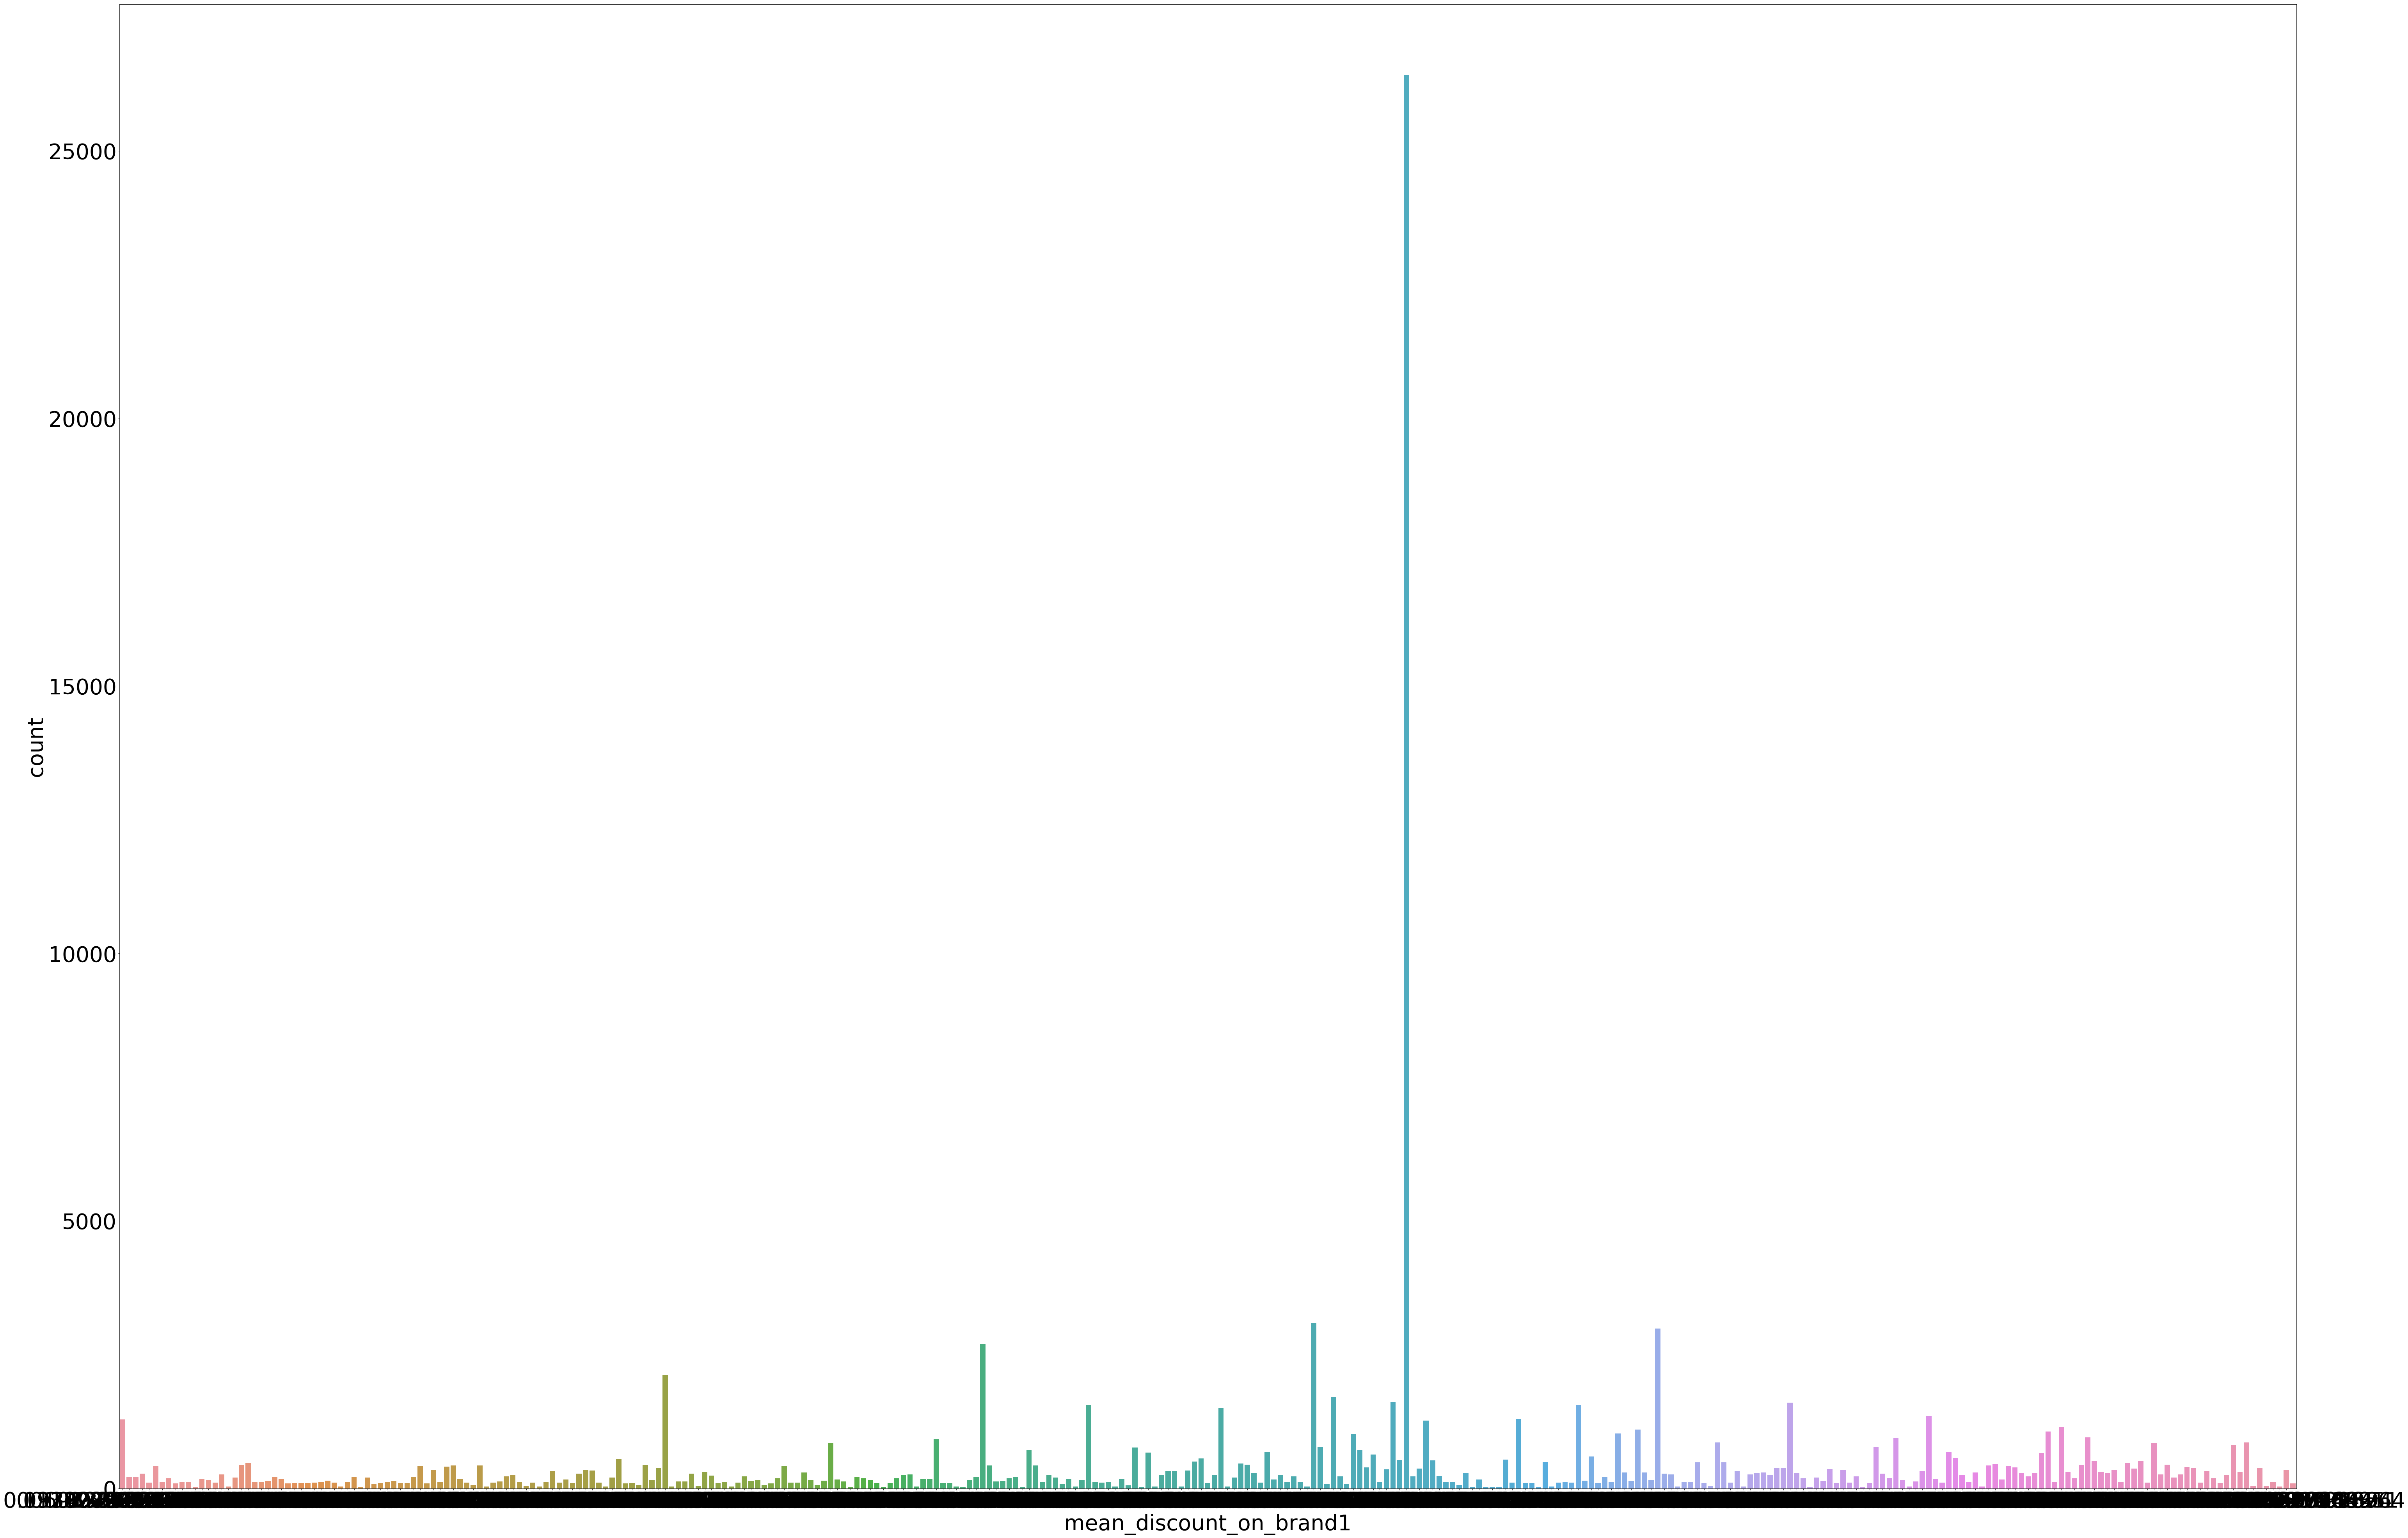

In [243]:
%%time
merged_data['mean_discount_on_brand1'] = merged_data['coupon_available_on_brand_1'].apply(lambda x: s[x])
sns.countplot(merged_data['mean_discount_on_brand1'])

CPU times: user 5.48 s, sys: 24.3 ms, total: 5.5 s
Wall time: 7.05 s


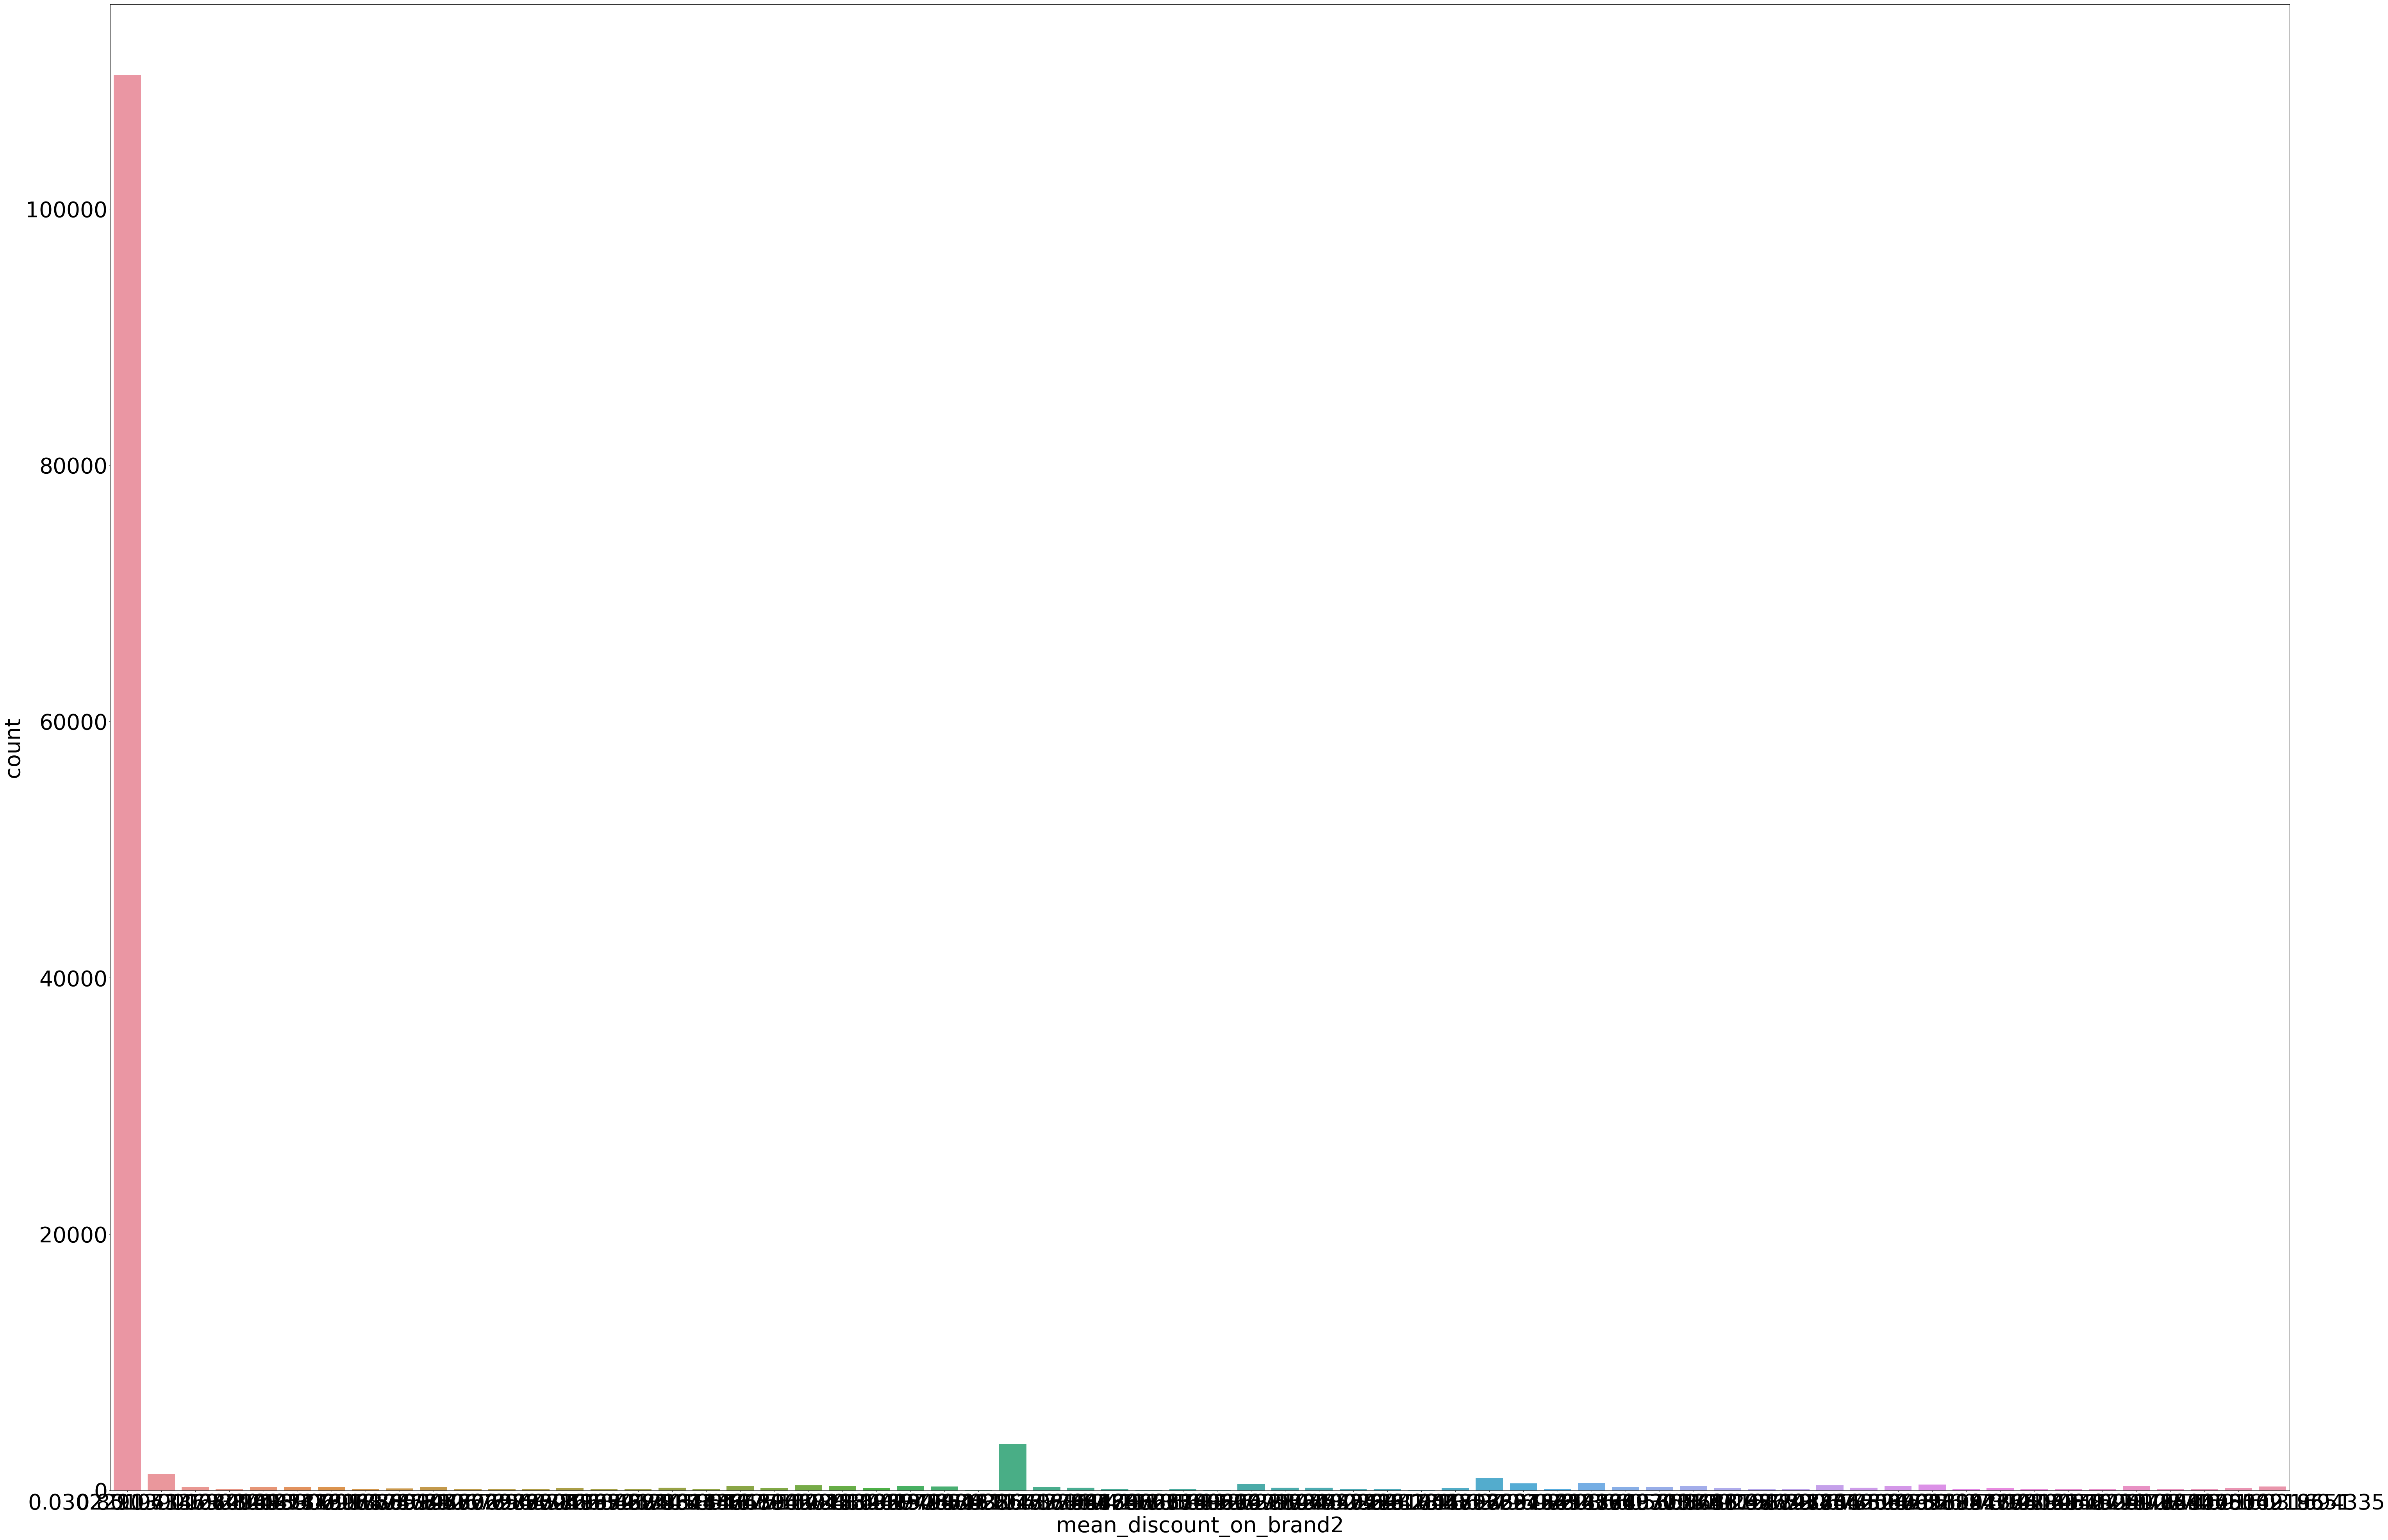

In [244]:
%%time
def get_mean_discount_on_brand2(x):
    try:
        return s[x]
    except:
        return 0
merged_data['mean_discount_on_brand2'] = merged_data['coupon_available_on_brand_2'].apply(get_mean_discount_on_brand2)
sns.countplot(merged_data['mean_discount_on_brand2'])

no_of_times_customer_bought_category1

In [245]:
s1 = customer_transaction_data.groupby(by=['customer_id', 'category'])['category'].agg('count')
s1

customer_id  category              
1            Bakery                     26
             Dairy, Juices & Snacks     14
             Grocery                   774
             Meat and poultry           82
             Natural Products           14
                                      ... 
1582         Natural Products           19
             Pharmaceutical            198
             Skin & Hair Care            3
             Takeouts or Eating out      3
             Travel and Fuel            10
Name: category, Length: 14130, dtype: int64

In [246]:

def get_customer_buying_category1(row):
    try:
        return s1[row.customer_id, row.coupon_available_on_category_1]
    except:
        return 0
merged_data['no_of_times_customer_bought_category1'] = merged_data.apply(get_customer_buying_category1, axis=1)

merged_data['no_of_times_customer_bought_category1'].value_counts()

0       795
1       471
2       463
881     438
523     392
       ... 
527       9
1061      3
494       2
1146      2
1140      2
Name: no_of_times_customer_bought_category1, Length: 1002, dtype: int64

no_of_times_customer_bought_category2

In [247]:

def get_customer_buying_category2(row):
    try:
        return s1[row.customer_id, row.coupon_available_on_category_2]
    except:
        return 0
merged_data['no_of_times_customer_bought_category2'] = merged_data.apply(get_customer_buying_category2, axis=1)

merged_data['no_of_times_customer_bought_category2'].value_counts()

0       123346
1          630
2          412
3          243
4          170
         ...  
784          1
298          1
592          1
554          1
1599         1
Name: no_of_times_customer_bought_category2, Length: 647, dtype: int64

no_of_times_customer_bought_brand1

In [248]:
s1 = customer_transaction_data.groupby(by=['customer_id', 'brand'])['brand'].agg('count')
s1

customer_id  brand
1            1        11
             11        4
             49        3
             56       86
             57        4
                      ..
1582         5079      1
             5101      1
             5218      1
             5357      1
             5467      2
Name: brand, Length: 250232, dtype: int64

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


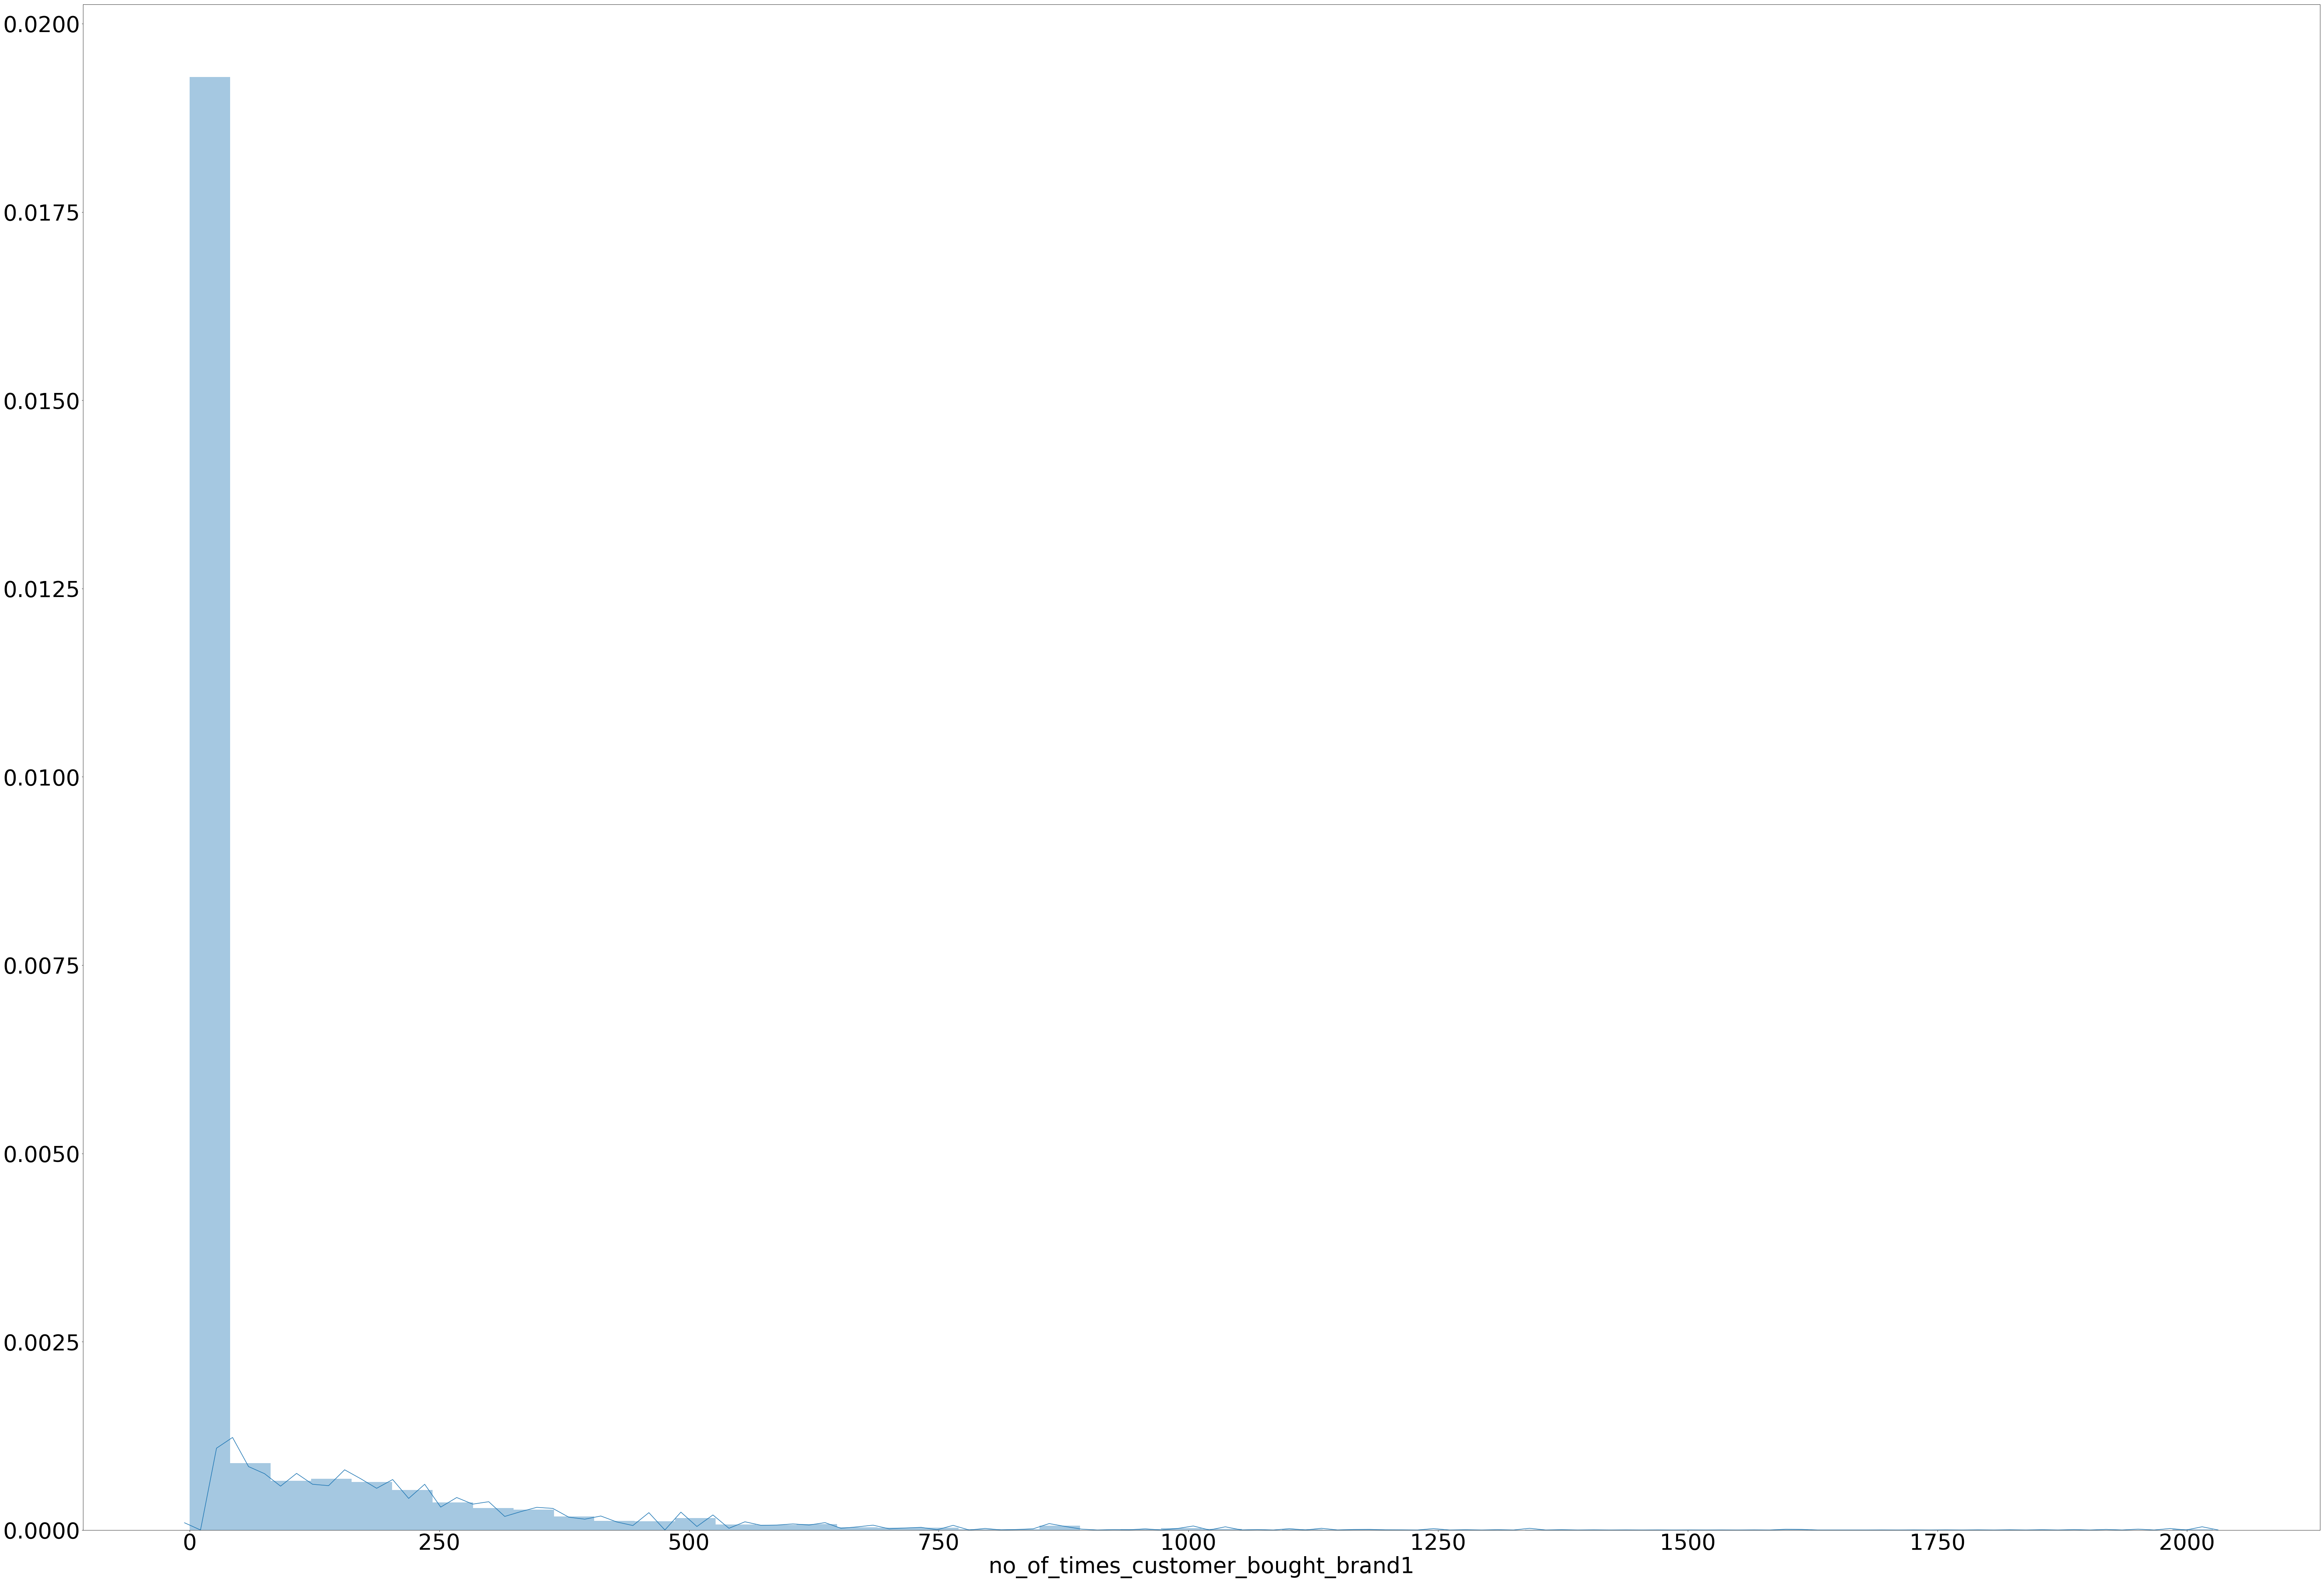

In [249]:
def get_customer_buying_brand1(row):
    try:
        return s1[row.customer_id, row.coupon_available_on_brand_1]
    except:
        return 0
merged_data['no_of_times_customer_bought_brand1'] = merged_data.apply(get_customer_buying_brand1, axis=1)

sns.distplot(merged_data['no_of_times_customer_bought_brand1'])

no_of_times_customer_bought_brand2

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


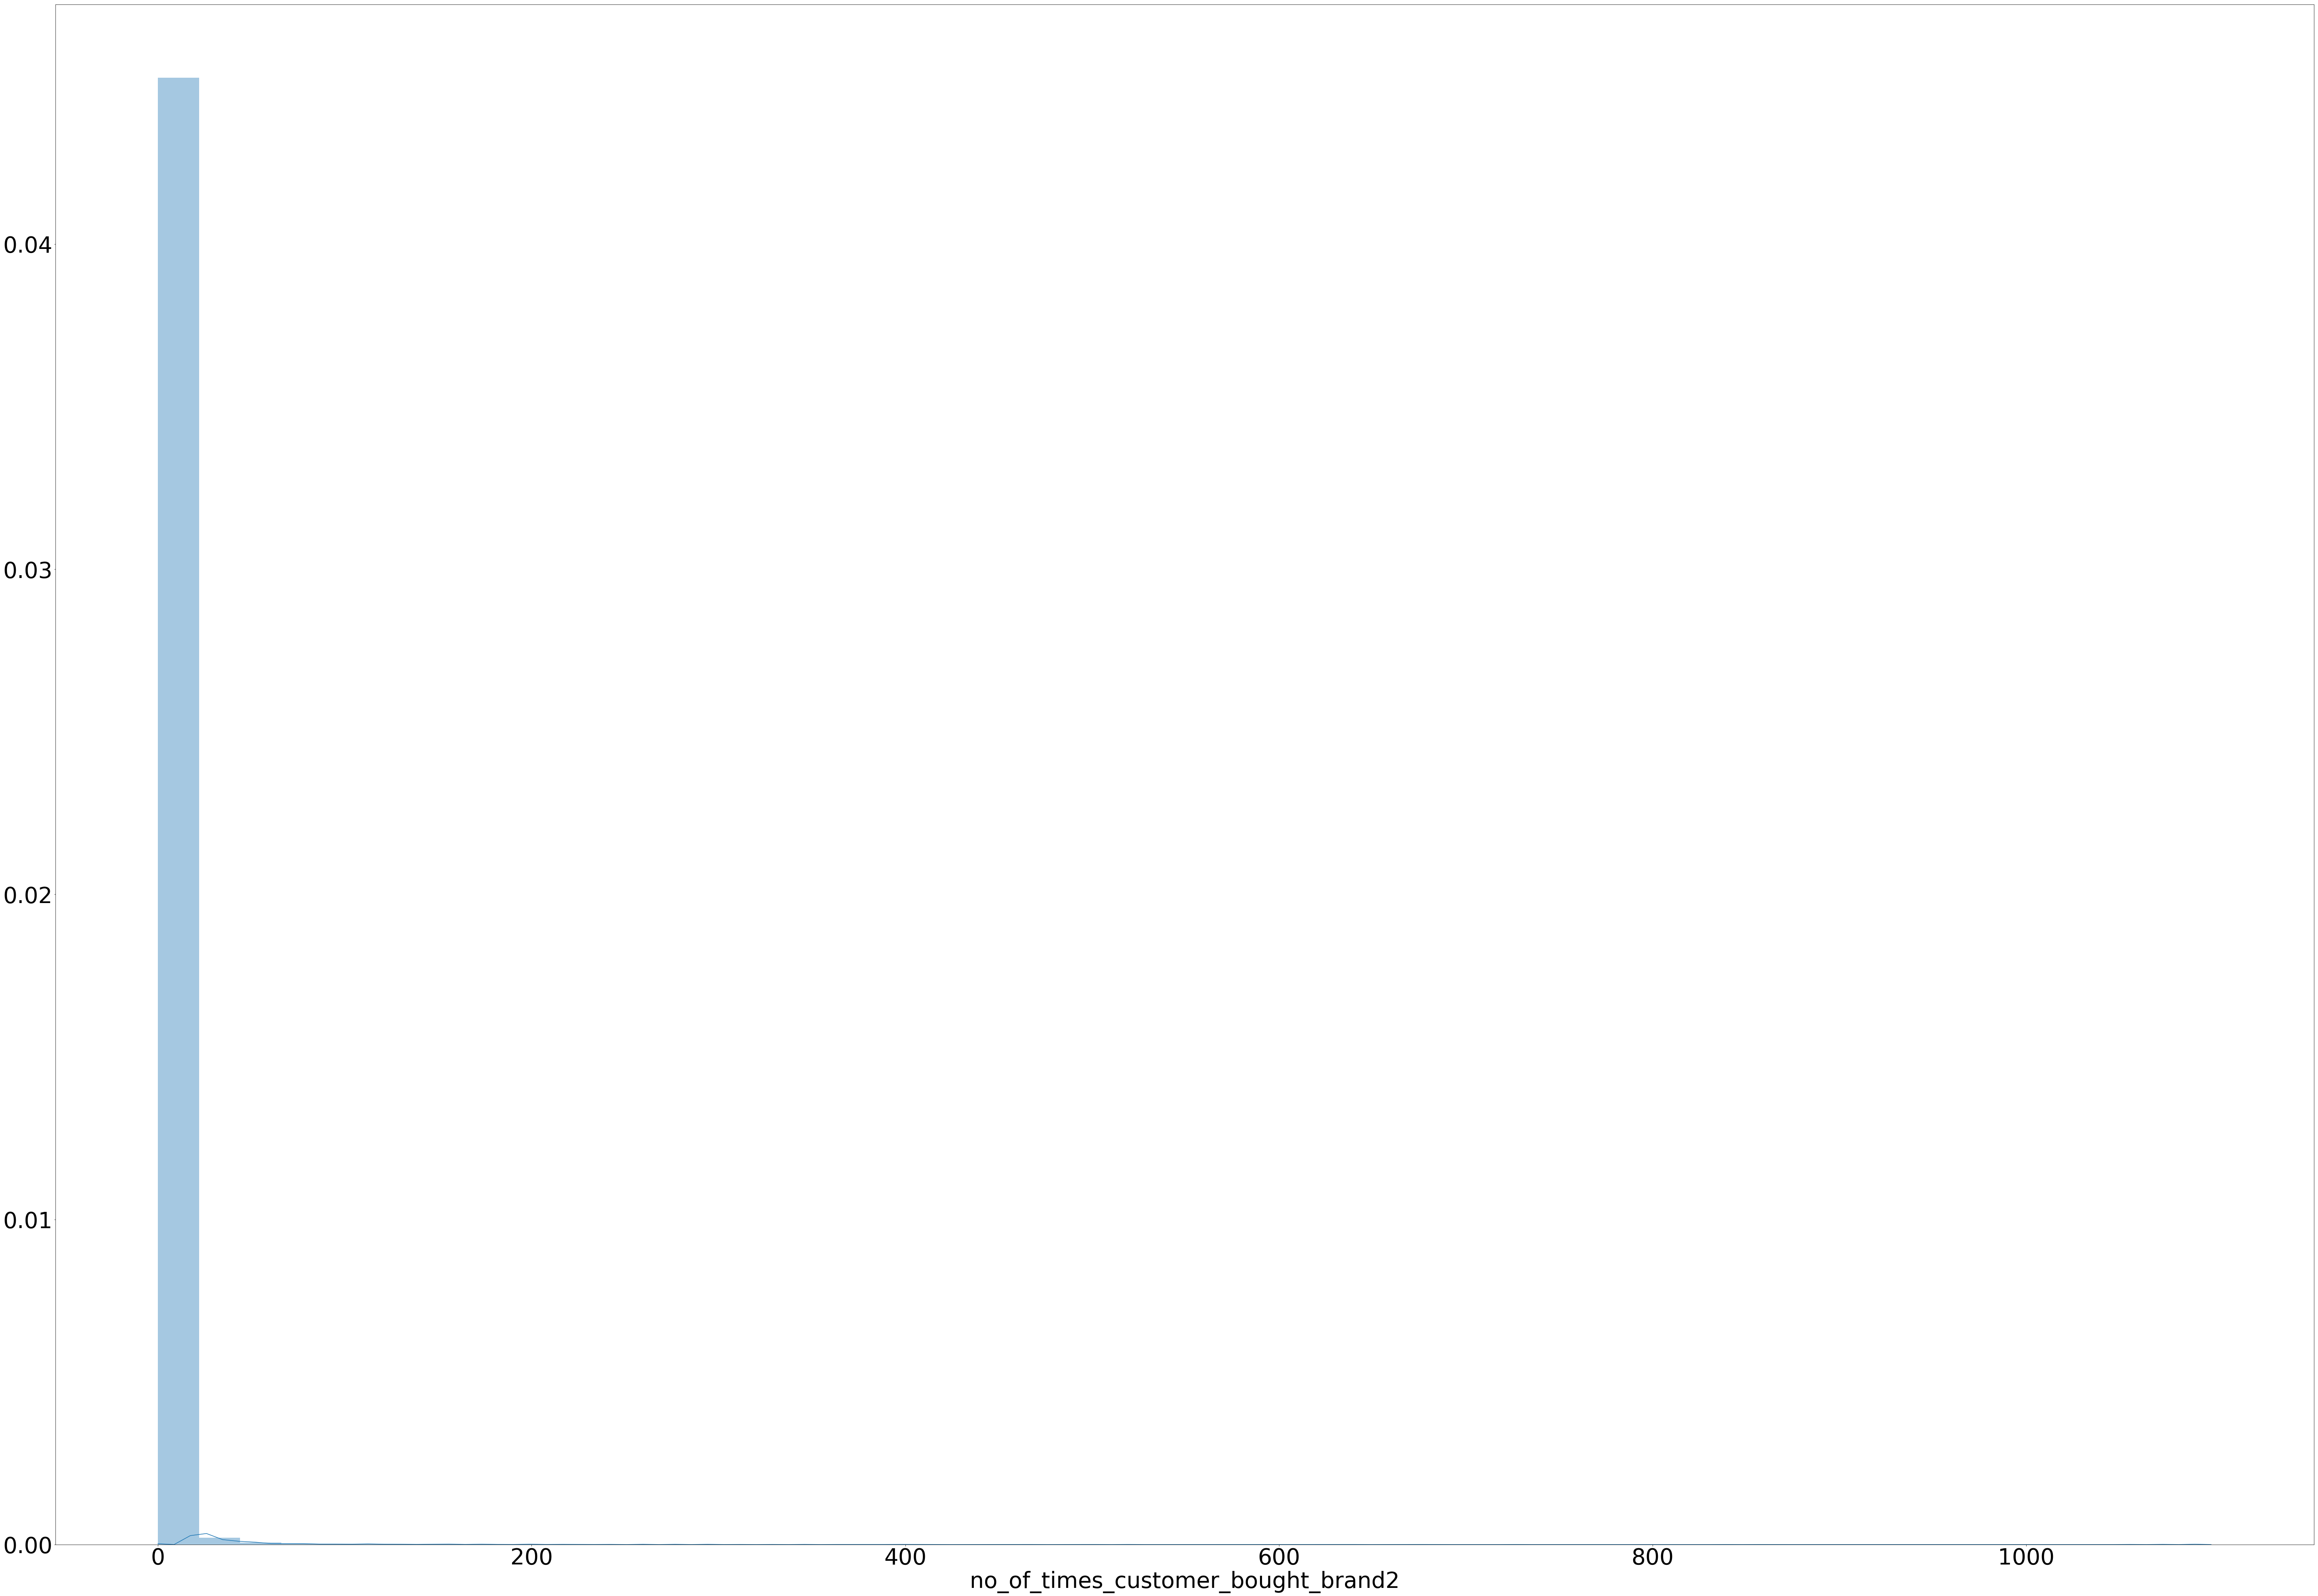

In [250]:
def get_customer_buying_brand2(row):
    try:
        return s1[row.customer_id, row.coupon_available_on_brand_2]
    except:
        return 0
merged_data['no_of_times_customer_bought_brand2'] = merged_data.apply(get_customer_buying_brand2, axis=1)

sns.distplot(merged_data['no_of_times_customer_bought_brand2'])

no_of_times_customer_bought_category1_in_discount

In [251]:
discounted_transaction_data = customer_transaction_data[customer_transaction_data.total_discount > 0]
gs = discounted_transaction_data.groupby(by=['customer_id', 'category'])['category'].agg('count')


In [252]:
%%time
def get_category1_count_in_discount(row):
    try:
        return (gs[row.customer_id, row.coupon_available_on_category_1])
    except:
        return 0
        
    
    
merged_data['no_of_times_customer_bought_category1_in_discount'] = merged_data.apply(get_category1_count_in_discount, axis =1)

CPU times: user 16.8 s, sys: 230 ms, total: 17 s
Wall time: 22.7 s


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


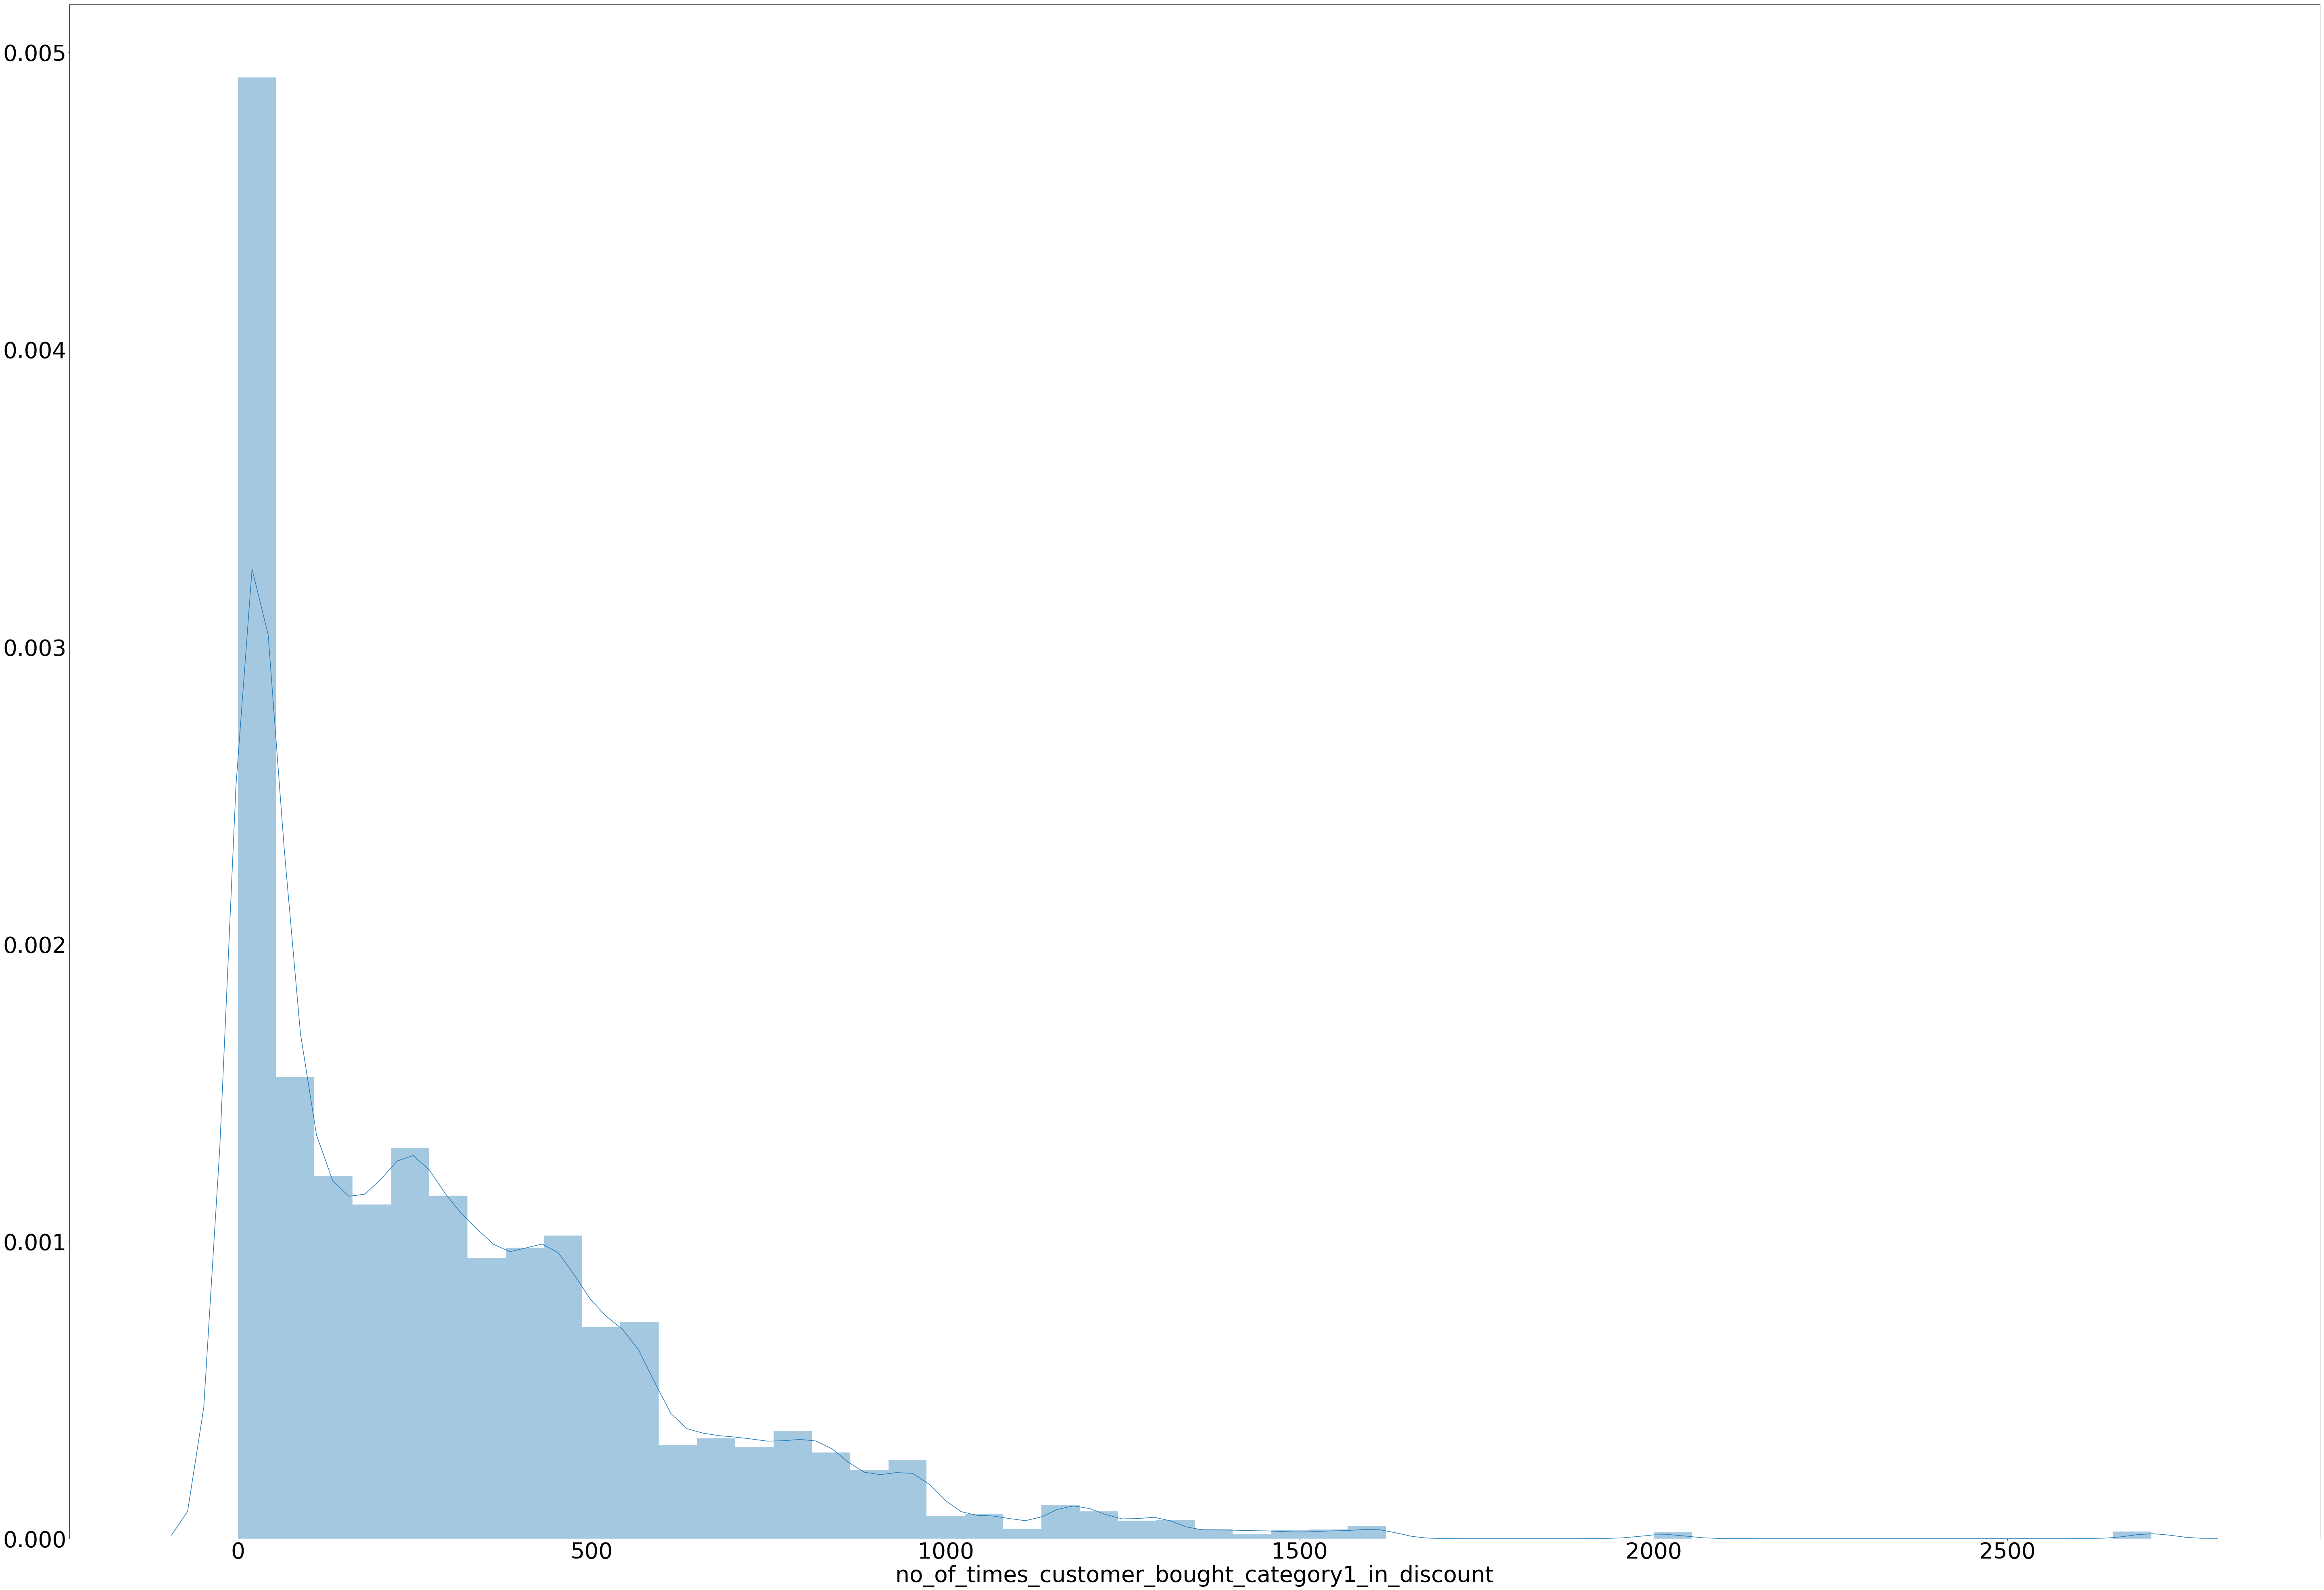

In [253]:
sns.distplot(merged_data['no_of_times_customer_bought_category1_in_discount'])

no_of_times_customer_bought_category2_in_discount

In [254]:
%%time
def get_category2_count_in_discount(row):
    try:
        return (gs[row.customer_id, row.coupon_available_on_category_2])
    except:
        return 0
        
    
    
merged_data['no_of_times_customer_bought_category2_in_discount'] = merged_data.apply(get_category2_count_in_discount, axis =1)

CPU times: user 29.1 s, sys: 265 ms, total: 29.4 s
Wall time: 38.5 s


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


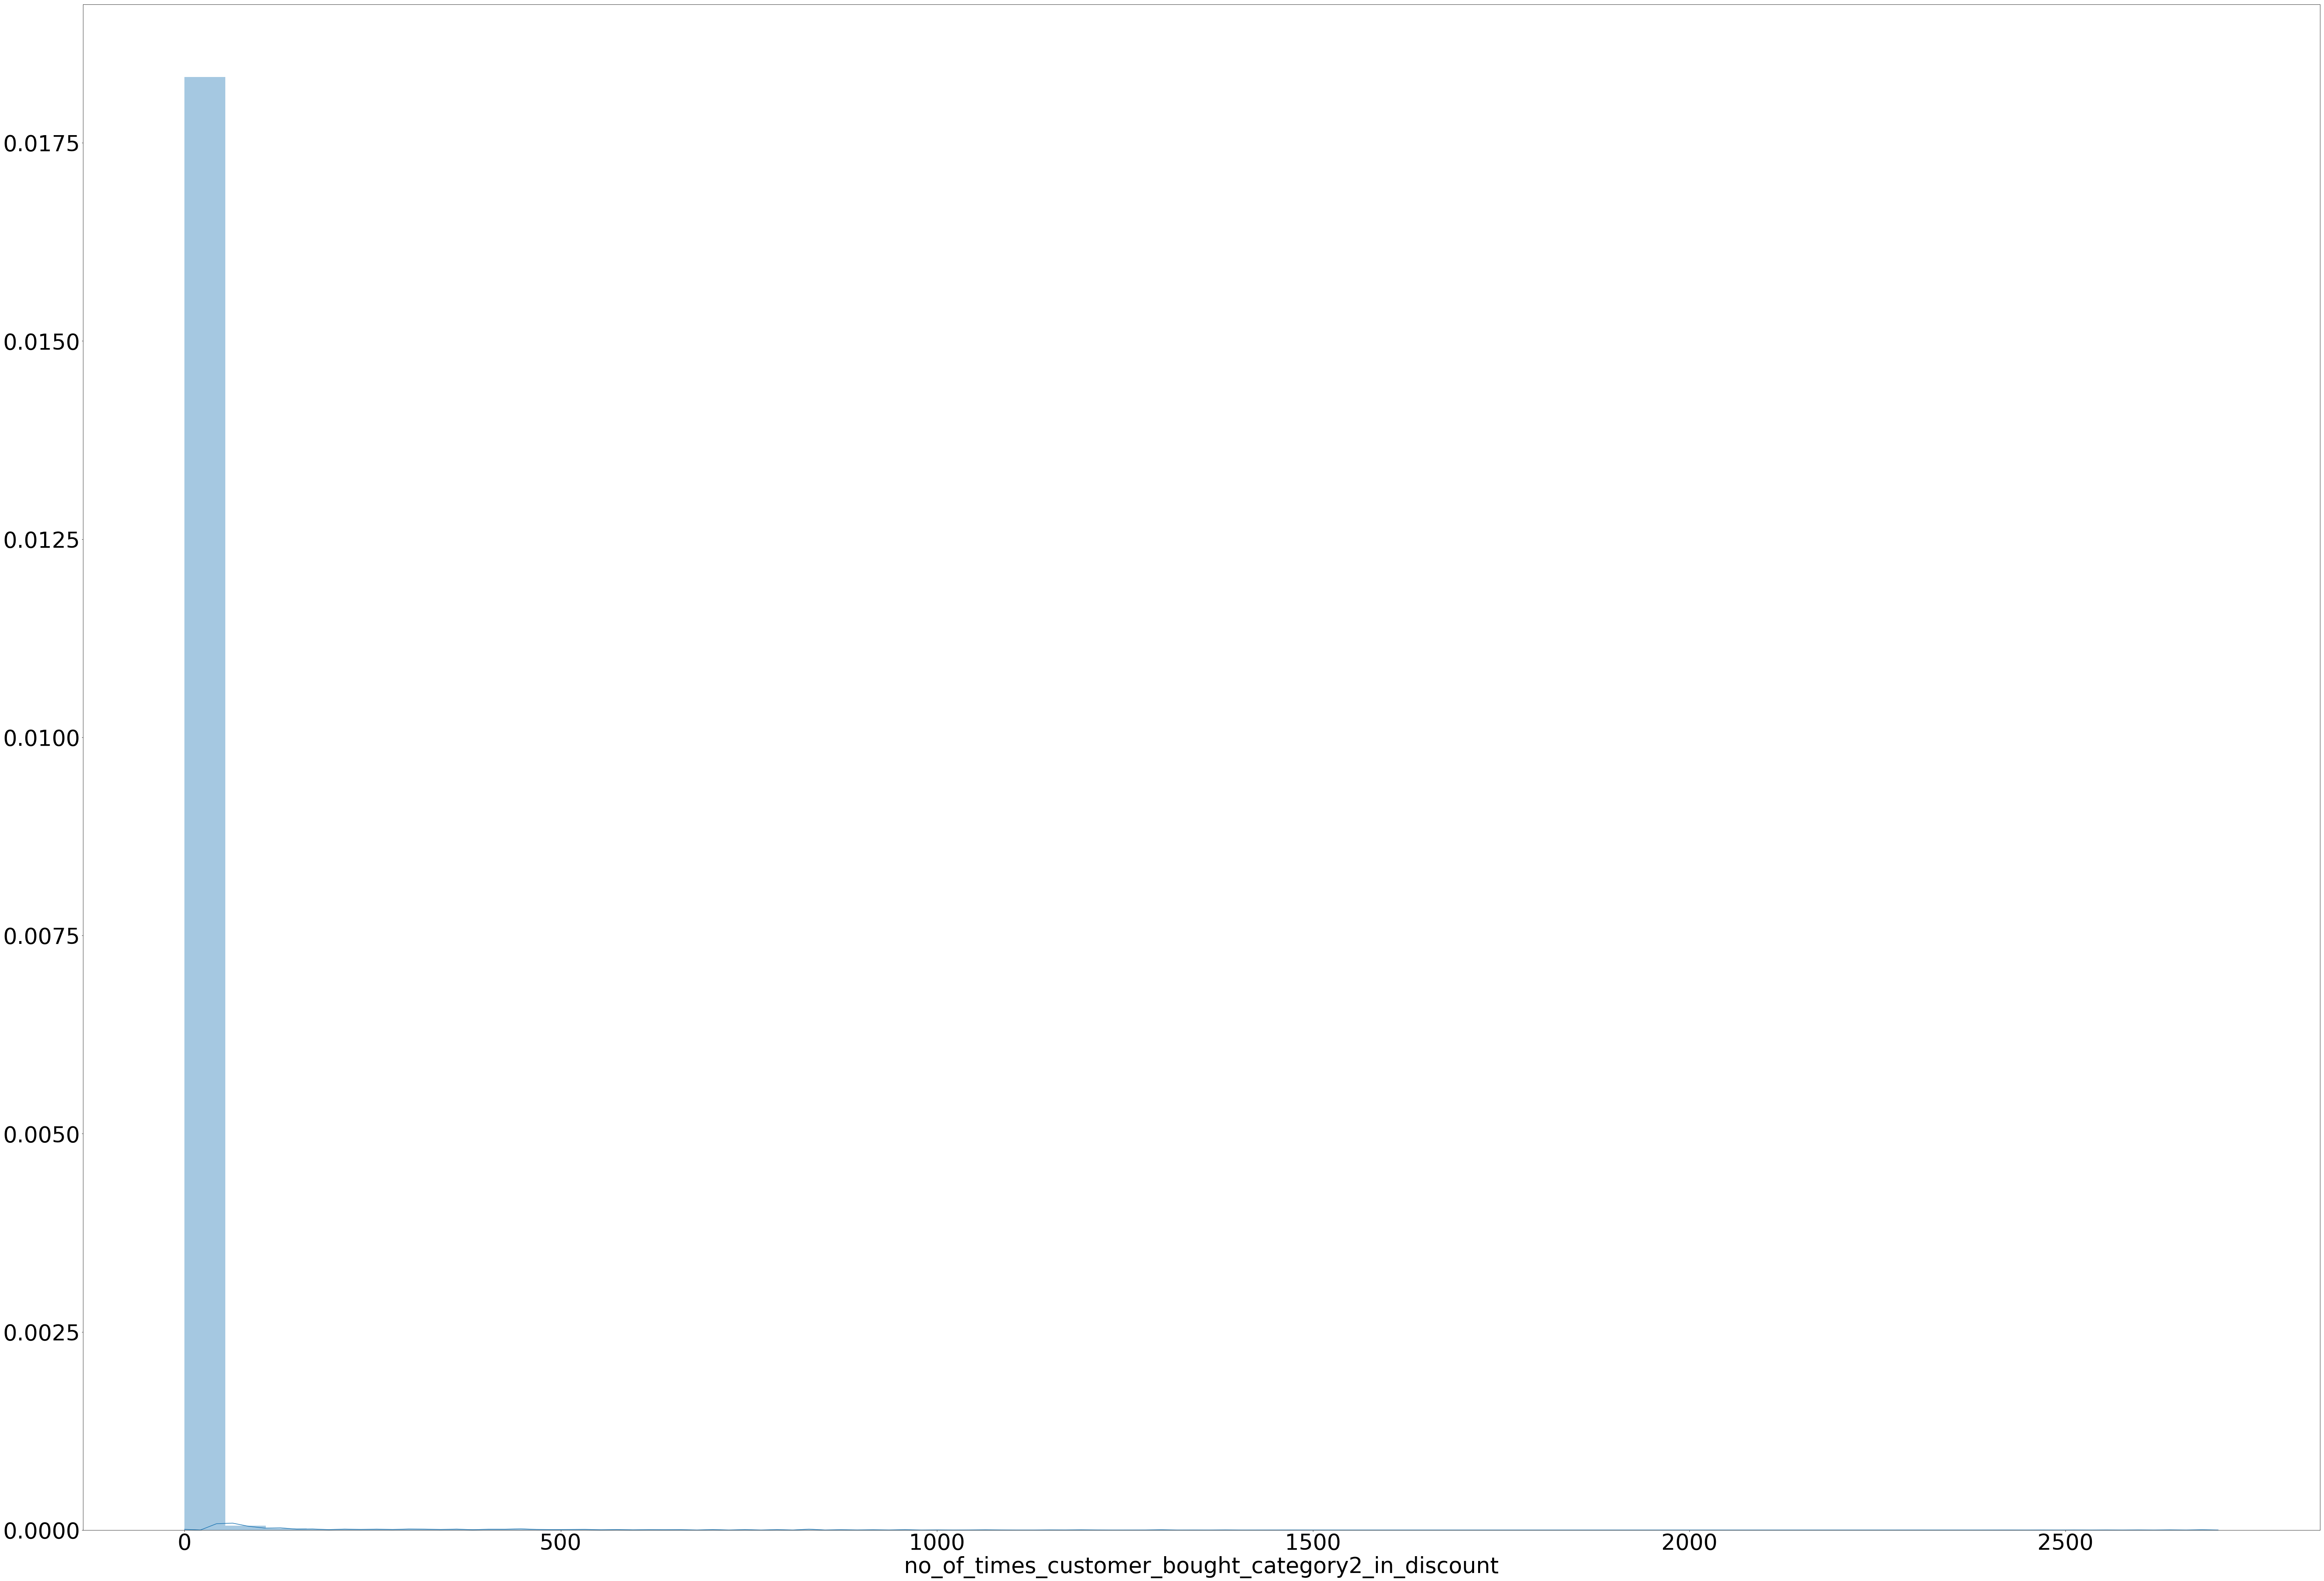

In [255]:
sns.distplot(merged_data['no_of_times_customer_bought_category2_in_discount'])

no_of_times_customer_bought_brand1_in_discount

In [256]:
discounted_transaction_data = customer_transaction_data[customer_transaction_data.total_discount > 0]
bgs = discounted_transaction_data.groupby(by=['customer_id', 'brand'])['brand'].agg('count')


In [257]:
%%time
def get_brand1_count_in_discount(row):
    try:
        return (bgs[row.customer_id, row.coupon_available_on_brand_1])
    except:
        return 0
        
    
    
merged_data['no_of_times_customer_bought_brand1_in_discount'] = merged_data.apply(get_brand1_count_in_discount, axis =1)

CPU times: user 28.3 s, sys: 291 ms, total: 28.6 s
Wall time: 38.5 s


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


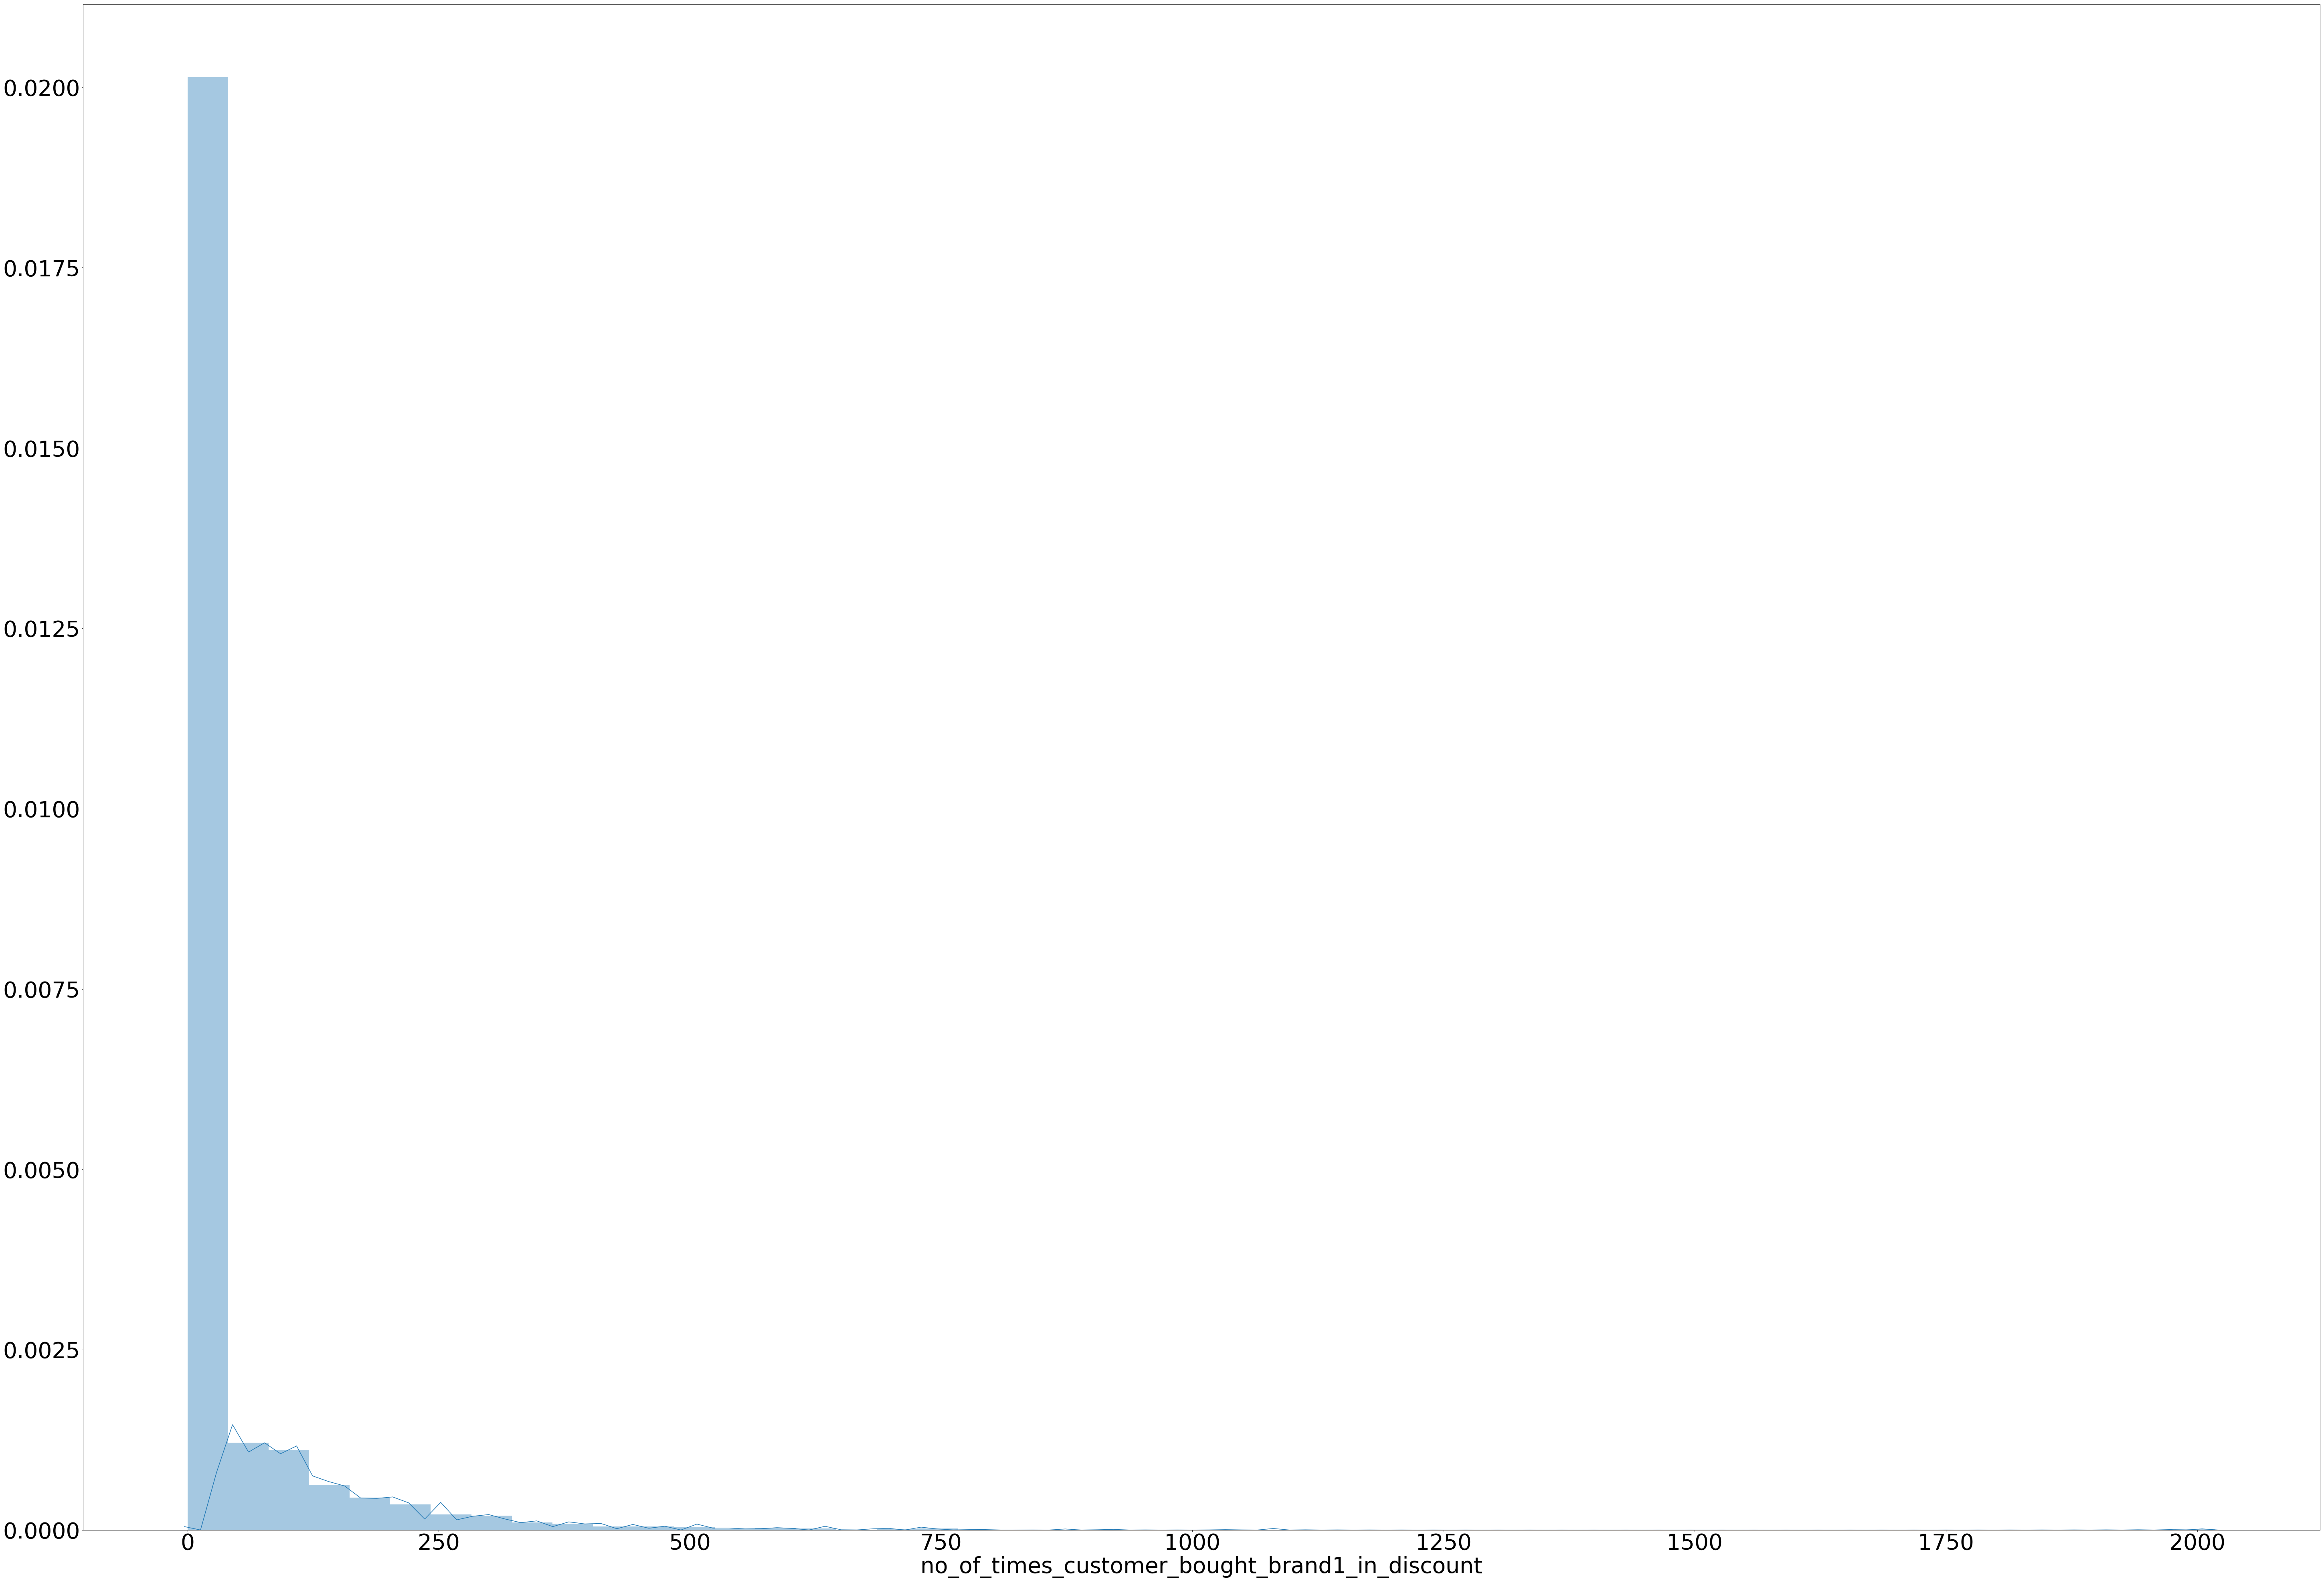

In [258]:
sns.distplot(merged_data['no_of_times_customer_bought_brand1_in_discount'])

no_of_times_customer_bought_brand2_in_discount

In [259]:
%%time
def get_brand2_count_in_discount(row):
    try:
        return (bgs[row.customer_id, row.coupon_available_on_brand_2])
    except:
        return 0
        
    
    
merged_data['no_of_times_customer_bought_brand2_in_discount'] = merged_data.apply(get_brand2_count_in_discount, axis =1)

CPU times: user 33.3 s, sys: 501 ms, total: 33.8 s
Wall time: 54.5 s


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


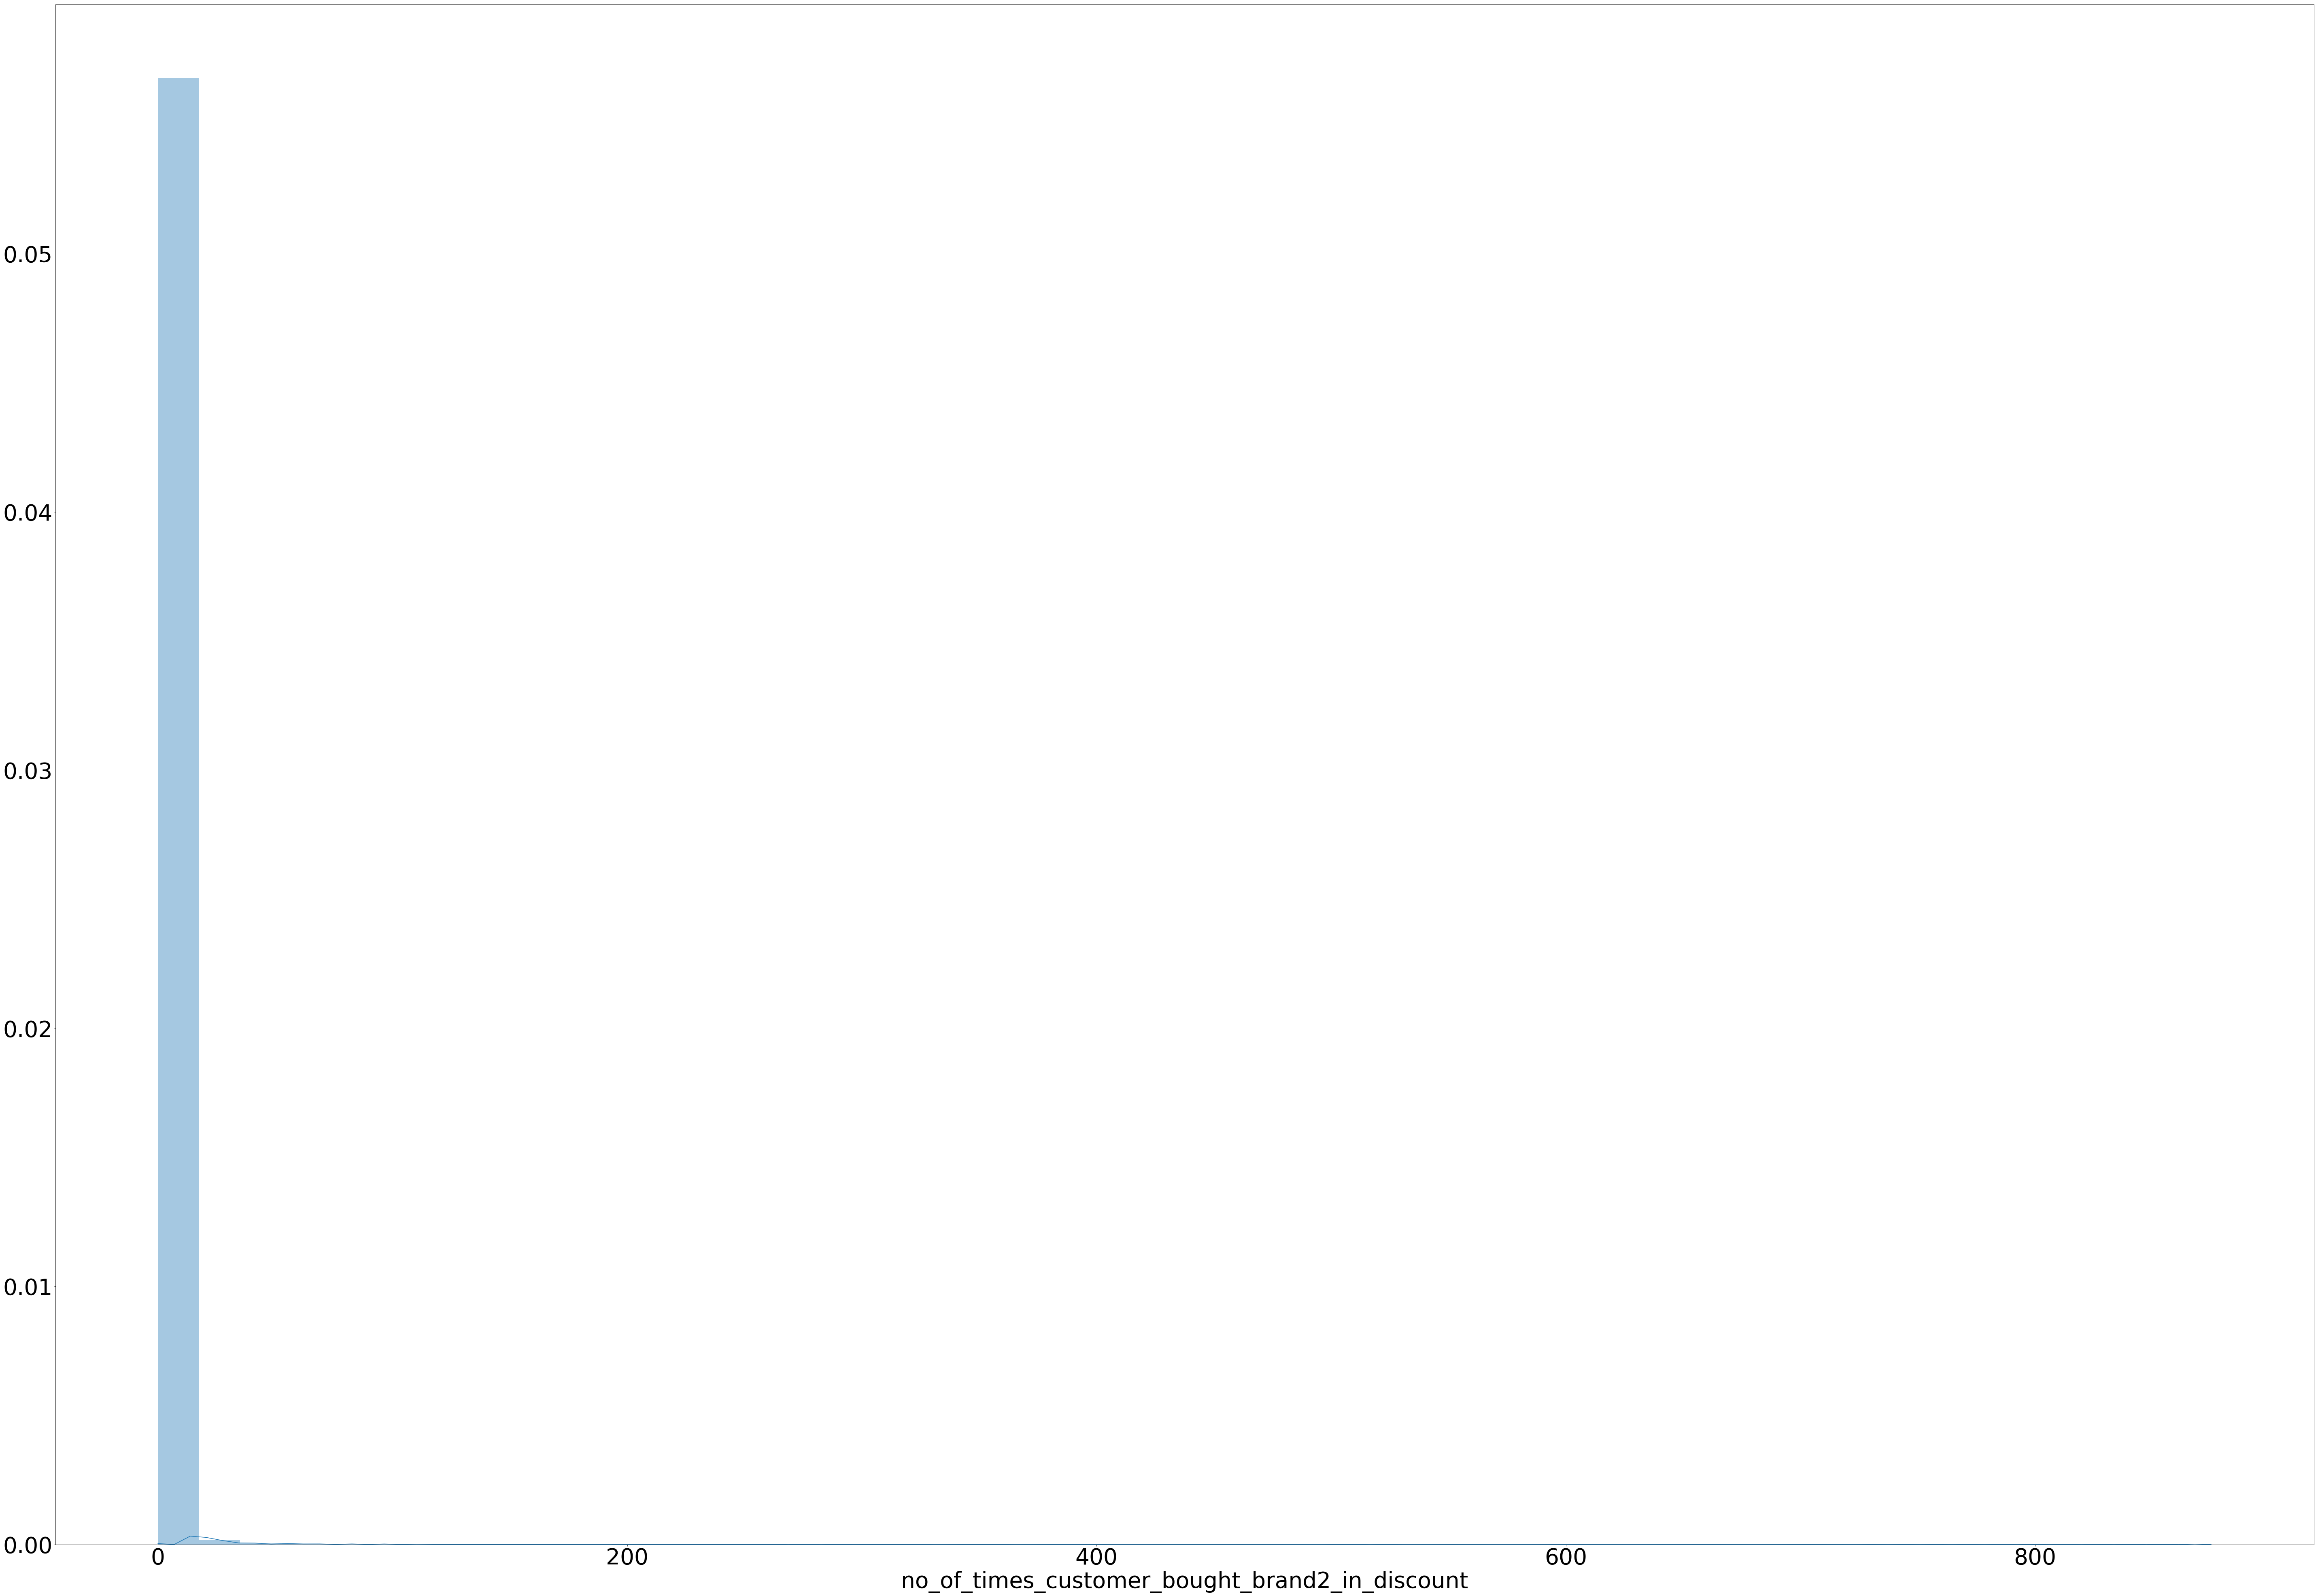

In [260]:
sns.distplot(merged_data['no_of_times_customer_bought_brand2_in_discount'])

has_customer_ever_bought_category1

In [261]:
merged_data['has_customer_ever_bought_category1'] = merged_data['no_of_times_customer_bought_category1'].apply(lambda x: 1 if (x>0) else 0)

has_customer_ever_bought_category2

In [262]:
merged_data['has_customer_ever_bought_category2'] = merged_data['no_of_times_customer_bought_category2'].apply(lambda x: 1 if (x>0) else 0)

has_customer_ever_bought_brand1

In [263]:
merged_data['has_customer_ever_bought_brand1'] = merged_data['no_of_times_customer_bought_brand1'].apply(lambda x: 1 if (x>0) else 0)

has_customer_ever_bought_brand2

In [264]:
merged_data['has_customer_ever_bought_brand2'] = merged_data['no_of_times_customer_bought_brand2'].apply(lambda x: 1 if (x>0) else 0)

has_customer_ever_bought_category1_in_discount

In [265]:
merged_data['has_customer_ever_bought_category1_in_discount'] = merged_data['no_of_times_customer_bought_category1_in_discount'].apply(lambda x: 1 if (x>0) else 0)

has_customer_ever_bought_category2_in_discount

In [266]:
merged_data['has_customer_ever_bought_category2_in_discount'] = merged_data['no_of_times_customer_bought_category2_in_discount'].apply(lambda x: 1 if (x>0) else 0)

has_customer_ever_bought_brand1_in_discount

In [267]:
merged_data['has_customer_ever_bought_brand1_in_discount'] = merged_data['no_of_times_customer_bought_brand1_in_discount'].apply(lambda x: 1 if (x>0) else 0)

has_customer_ever_bought_brand2_in_discount

In [268]:
merged_data['has_customer_ever_bought_brand2_in_discount'] = merged_data['no_of_times_customer_bought_brand2_in_discount'].apply(lambda x: 1 if (x>0) else 0)

average_selling_price_per_unit_of_category1_brand1_combination

In [269]:
avg_sp_df = customer_transaction_data.groupby(by=['category', 'brand']).agg('mean')

avg_sp_df['avg_sp_per_item'] = avg_sp_df['selling_price']/avg_sp_df['quantity']

avg_sp = avg_sp_df['avg_sp_per_item']
avg_sp

category         brand
Alcohol          1         31.700000
                 284      427.080000
                 301      676.425000
                 978      479.090000
                 1103     555.708889
                             ...    
Travel and Fuel  1         52.616000
                 56         0.085688
                 548       53.430000
                 2069      87.670295
                 4700      28.496000
Name: avg_sp_per_item, Length: 6120, dtype: float64

In [270]:
%%time
def get_average_sp_1(row):
    try:
        return (avg_sp[row.coupon_available_on_category_1, row.coupon_available_on_brand_1])
    except:
        return -1
        

merged_data['average_selling_price_per_unit_of_category1_brand1_combination'] = merged_data.apply(get_average_sp_1, axis =1)

CPU times: user 18.2 s, sys: 373 ms, total: 18.6 s
Wall time: 29.8 s


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


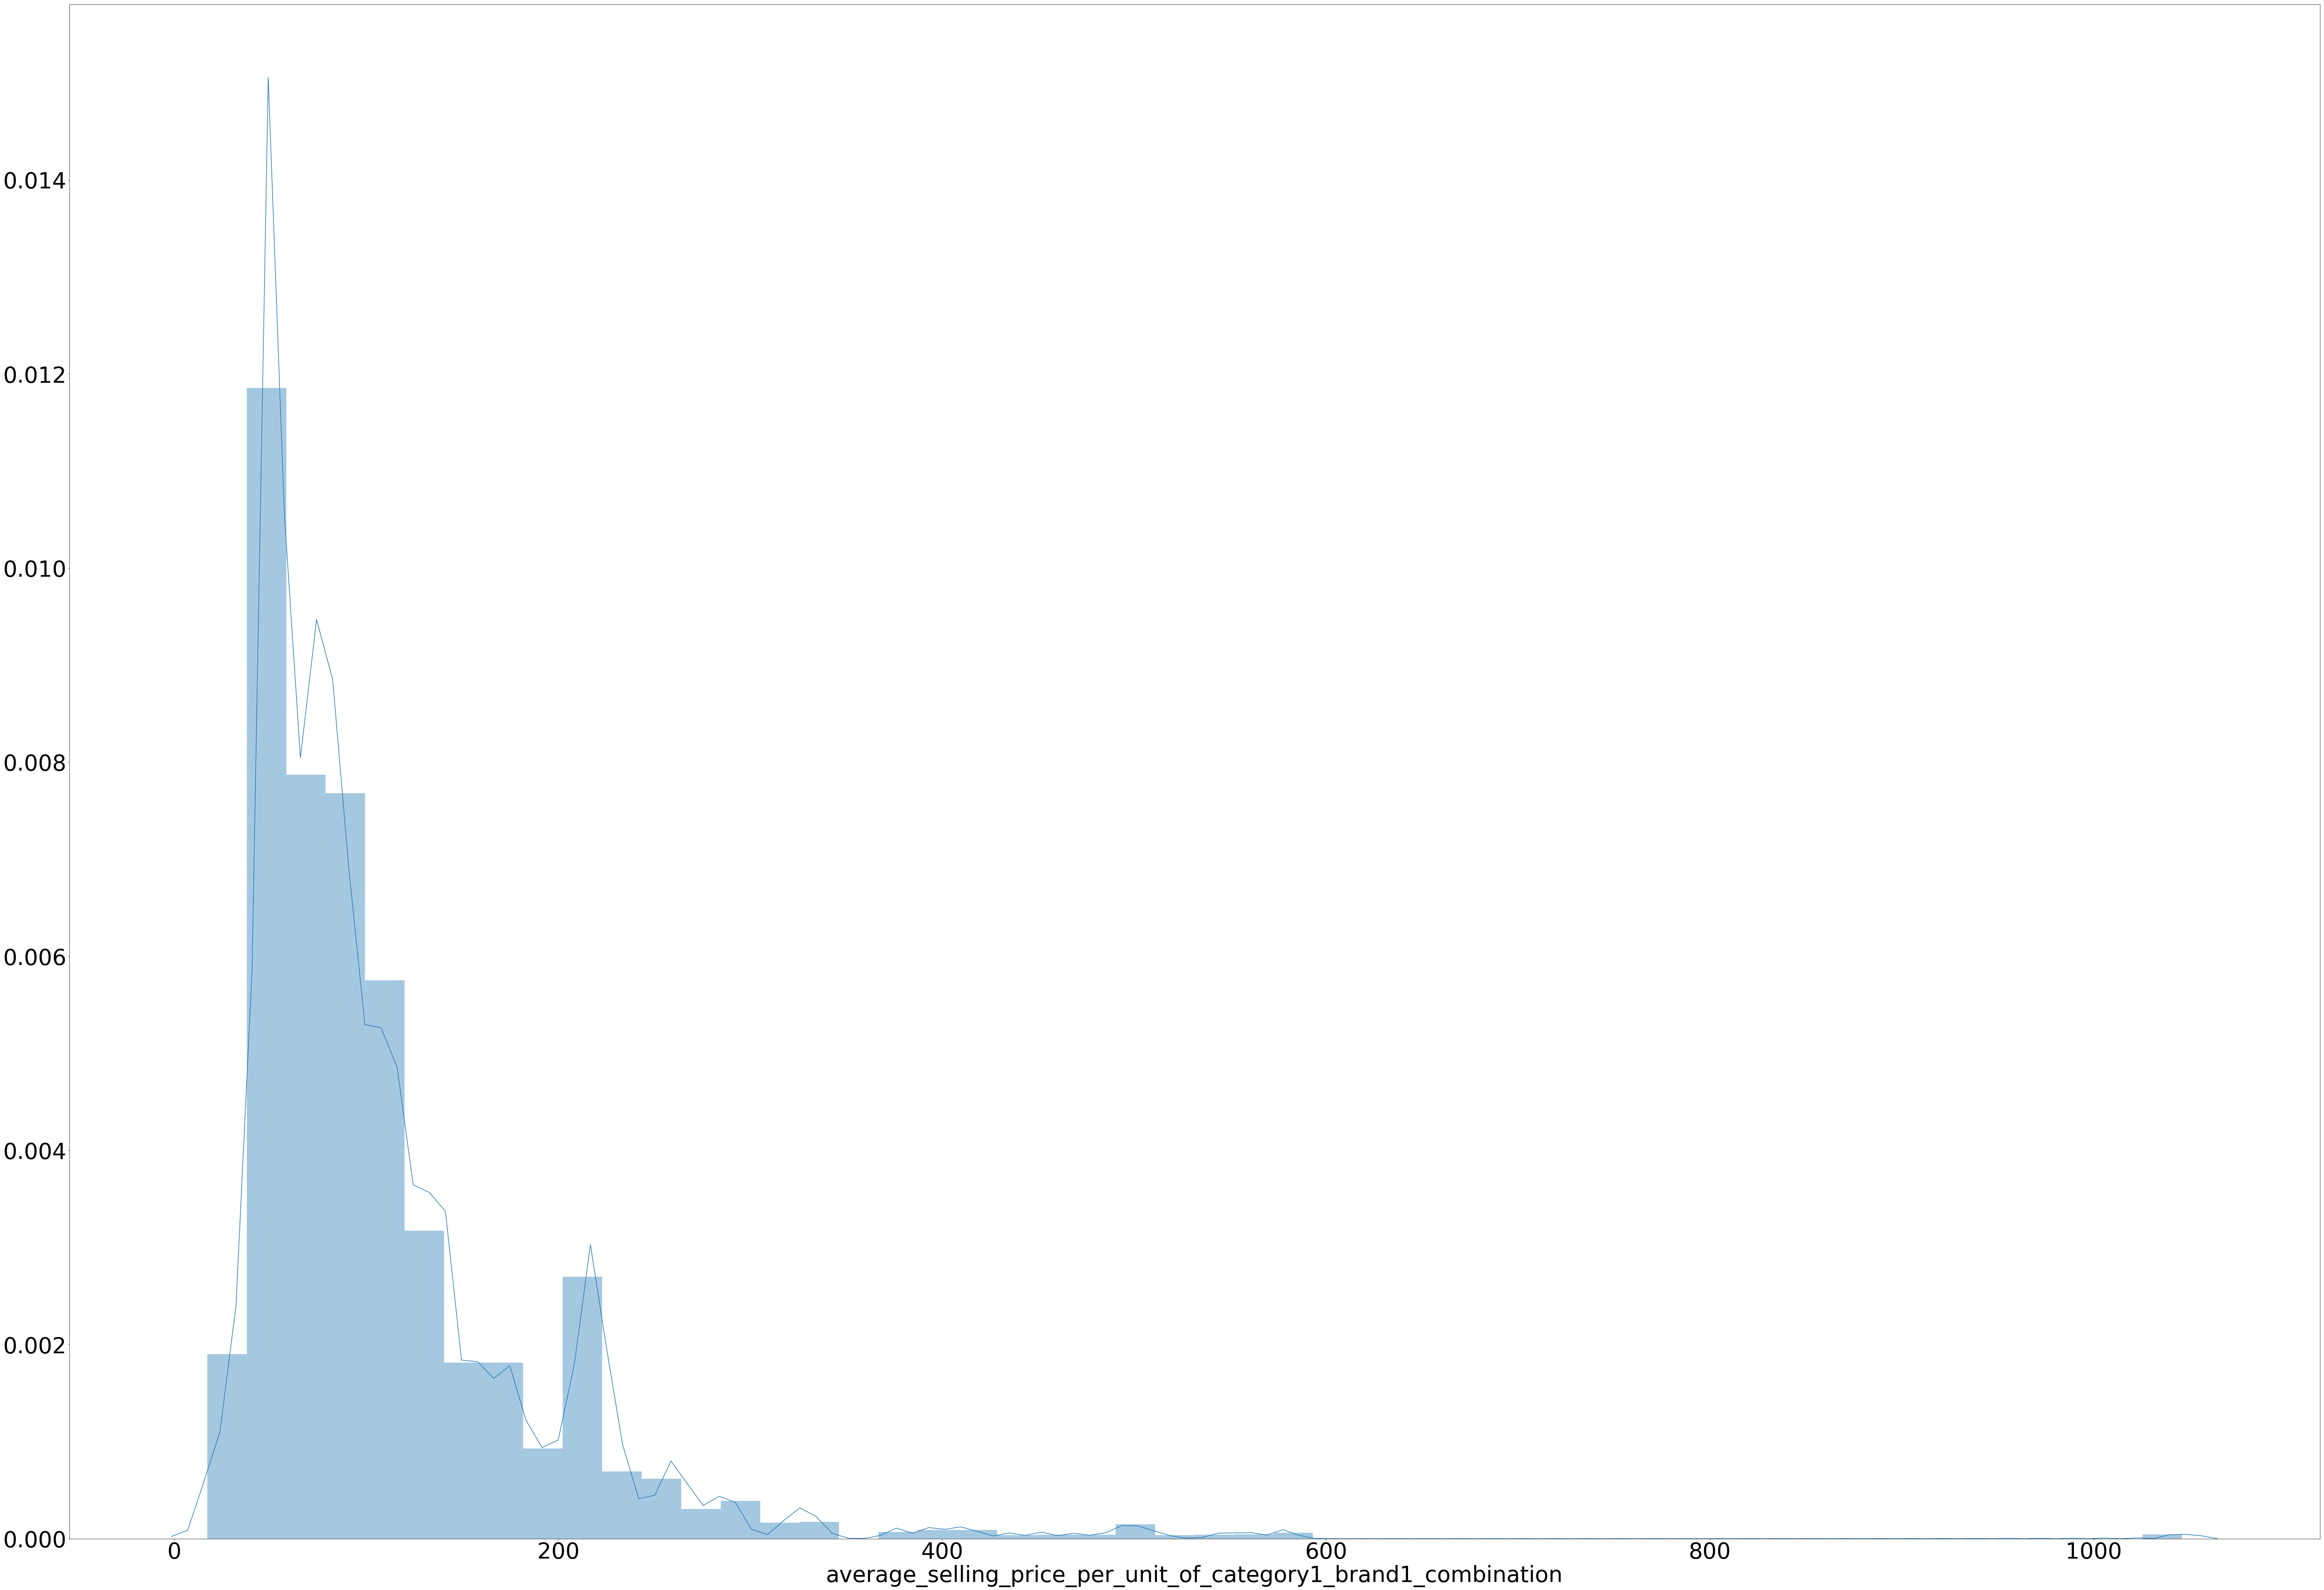

In [271]:
sns.distplot(merged_data['average_selling_price_per_unit_of_category1_brand1_combination'])

average_selling_price_per_unit_of_category2_brand2_combination

In [272]:
%%time
def get_average_sp_2(row):
    try:
        return (avg_sp[row.coupon_available_on_category_2, row.coupon_available_on_brand_2])
    except:
        return -1
        

merged_data['average_selling_price_per_unit_of_category2_brand2_combination'] = merged_data.apply(get_average_sp_2, axis =1)

CPU times: user 29.9 s, sys: 427 ms, total: 30.4 s
Wall time: 48.3 s


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


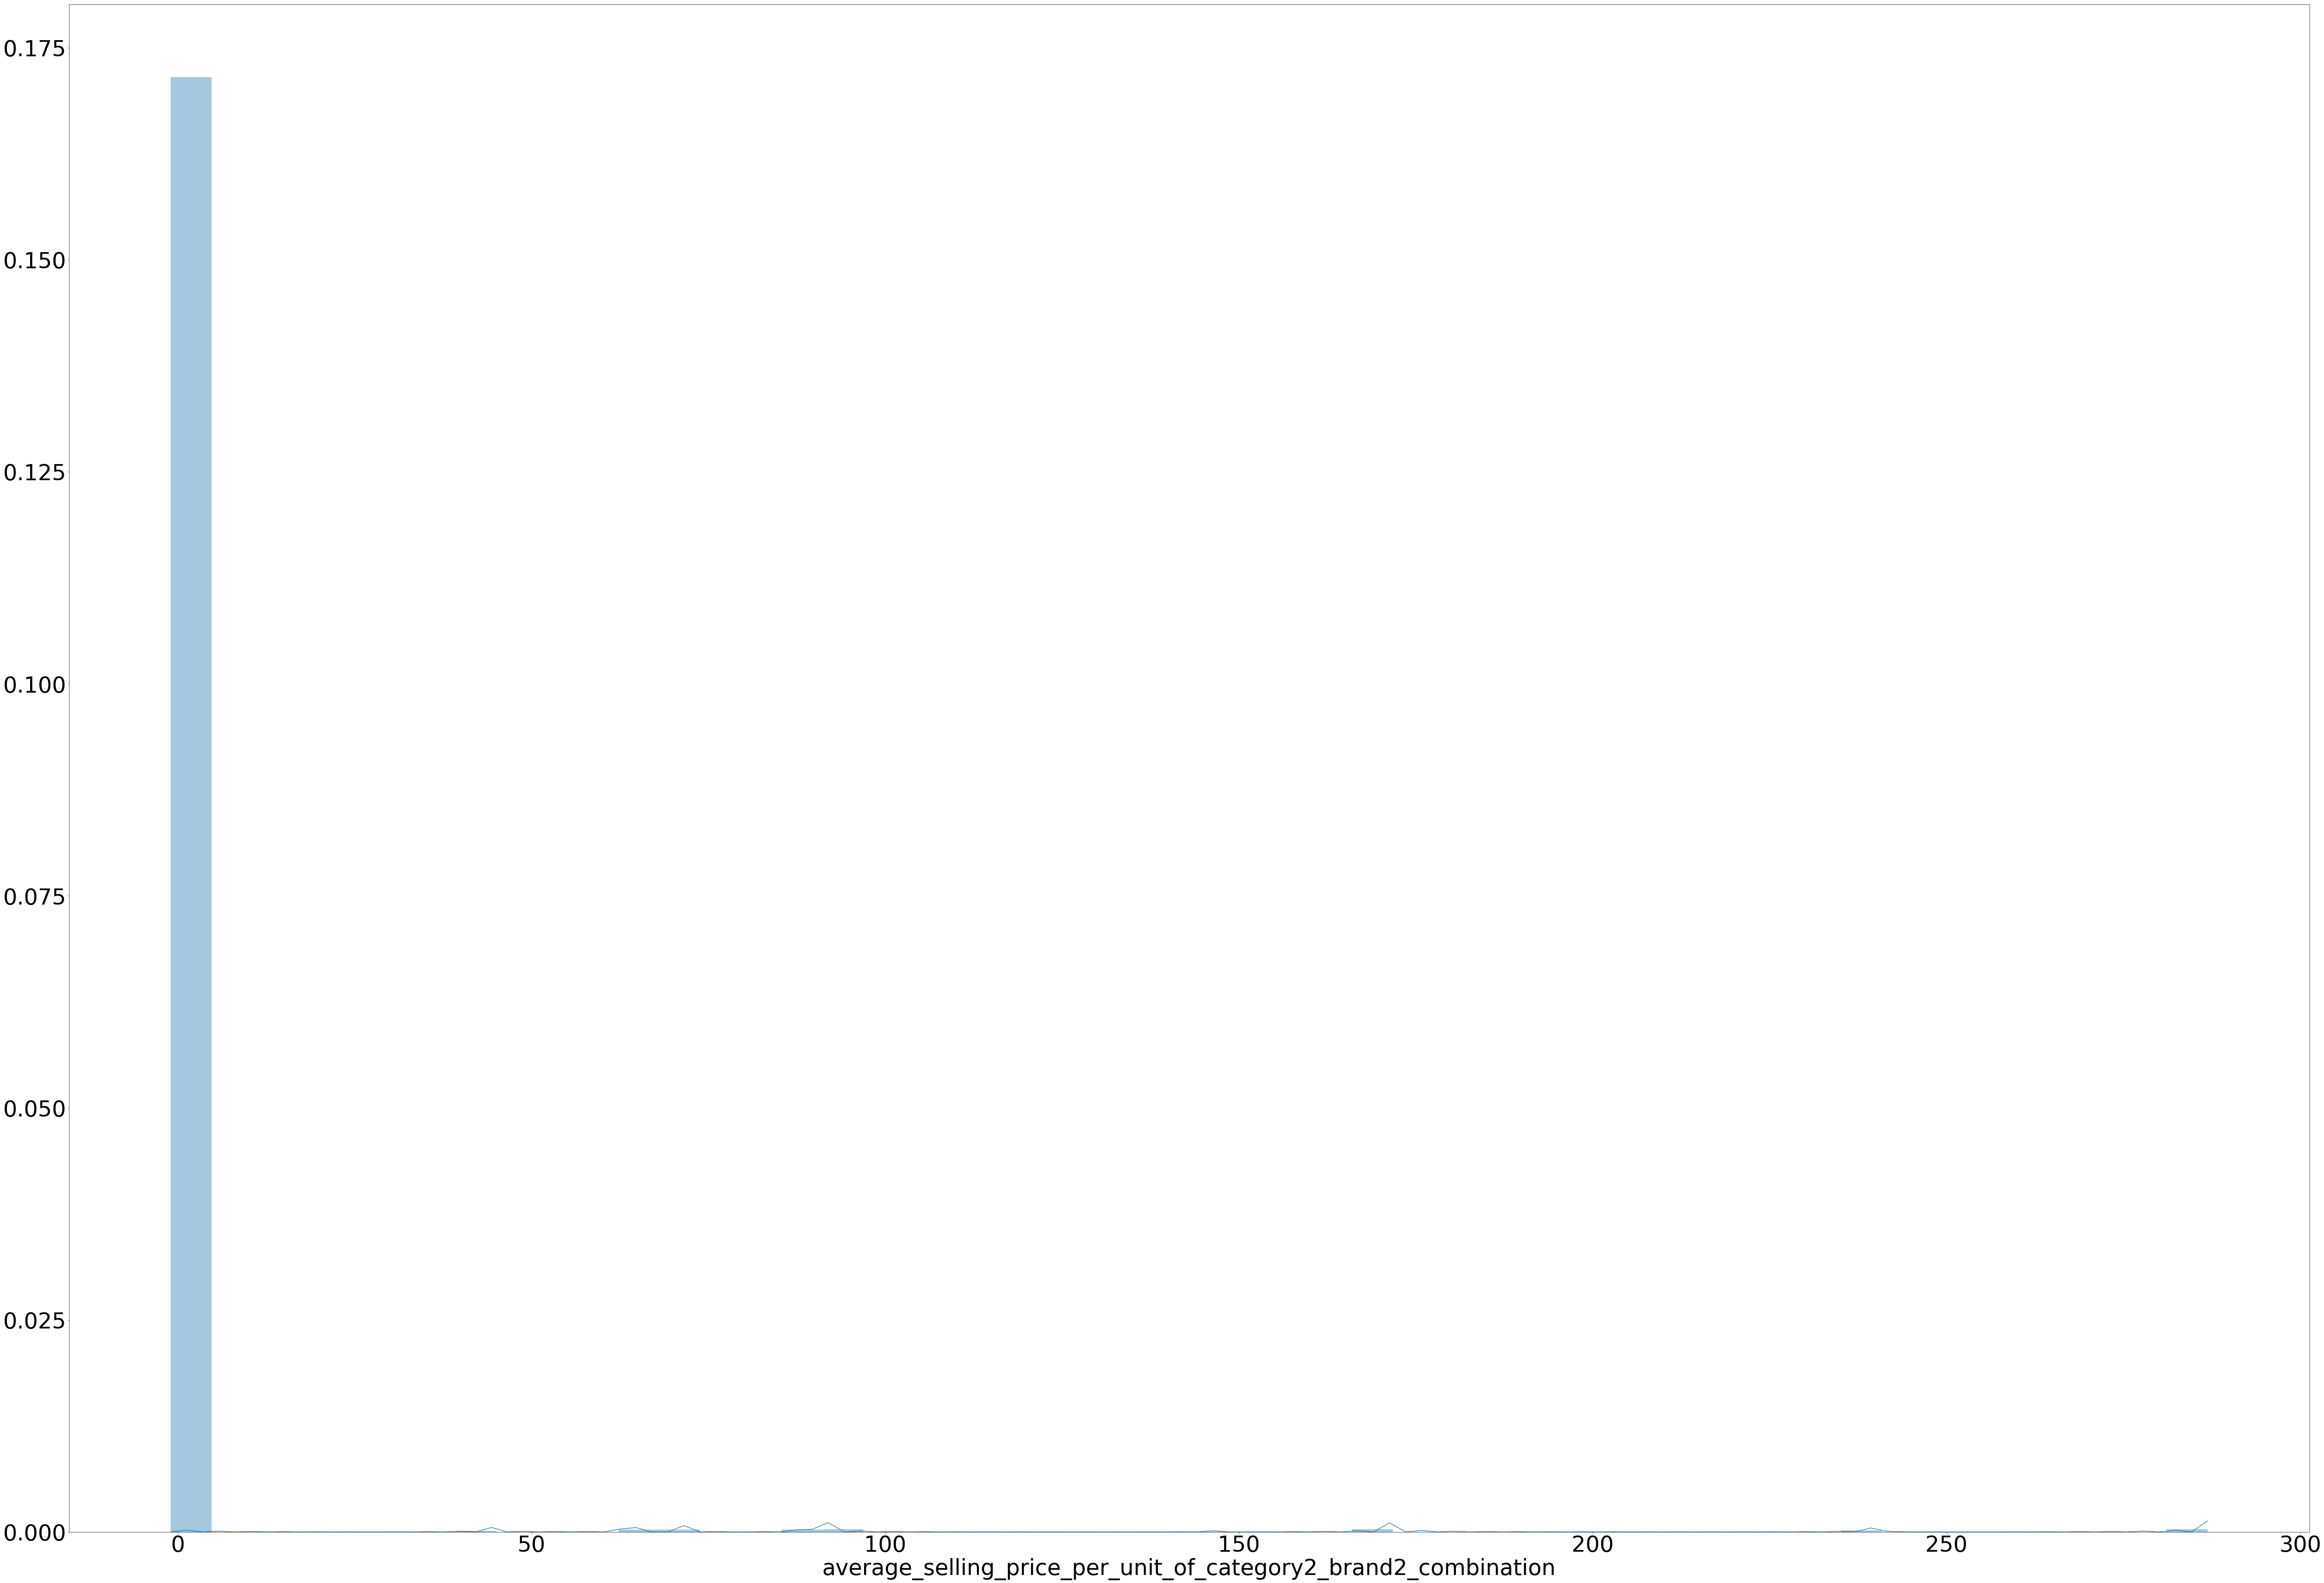

In [273]:
sns.distplot(merged_data['average_selling_price_per_unit_of_category2_brand2_combination'])

average_transaction_amount_for_customer_per_item_of_category1

In [274]:
avg_ta_df = customer_transaction_data.groupby(by=['customer_id', 'category']).agg('mean')


avg_ta_df['avg_ta_per_item'] = avg_ta_df['selling_price']/avg_ta_df['quantity']

avg_ta = avg_ta_df['avg_ta_per_item']
avg_ta

customer_id  category              
1            Bakery                     72.471282
             Dairy, Juices & Snacks     90.501429
             Grocery                    76.513484
             Meat and poultry          102.801889
             Natural Products           80.754286
                                          ...    
1582         Natural Products           81.435833
             Pharmaceutical             90.160623
             Skin & Hair Care          147.823333
             Takeouts or Eating out    118.373333
             Travel and Fuel             0.097525
Name: avg_ta_per_item, Length: 14130, dtype: float64

In [275]:
%%time
def get_average_ta_1(row):
    try:
        return (avg_ta[row.customer_id, row.coupon_available_on_category_1])
    except:
        return 0
        

merged_data['average_transaction_amount_for_customer_per_item_of_category1'] = merged_data.apply(get_average_ta_1, axis =1)

CPU times: user 17.4 s, sys: 253 ms, total: 17.6 s
Wall time: 25.3 s


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


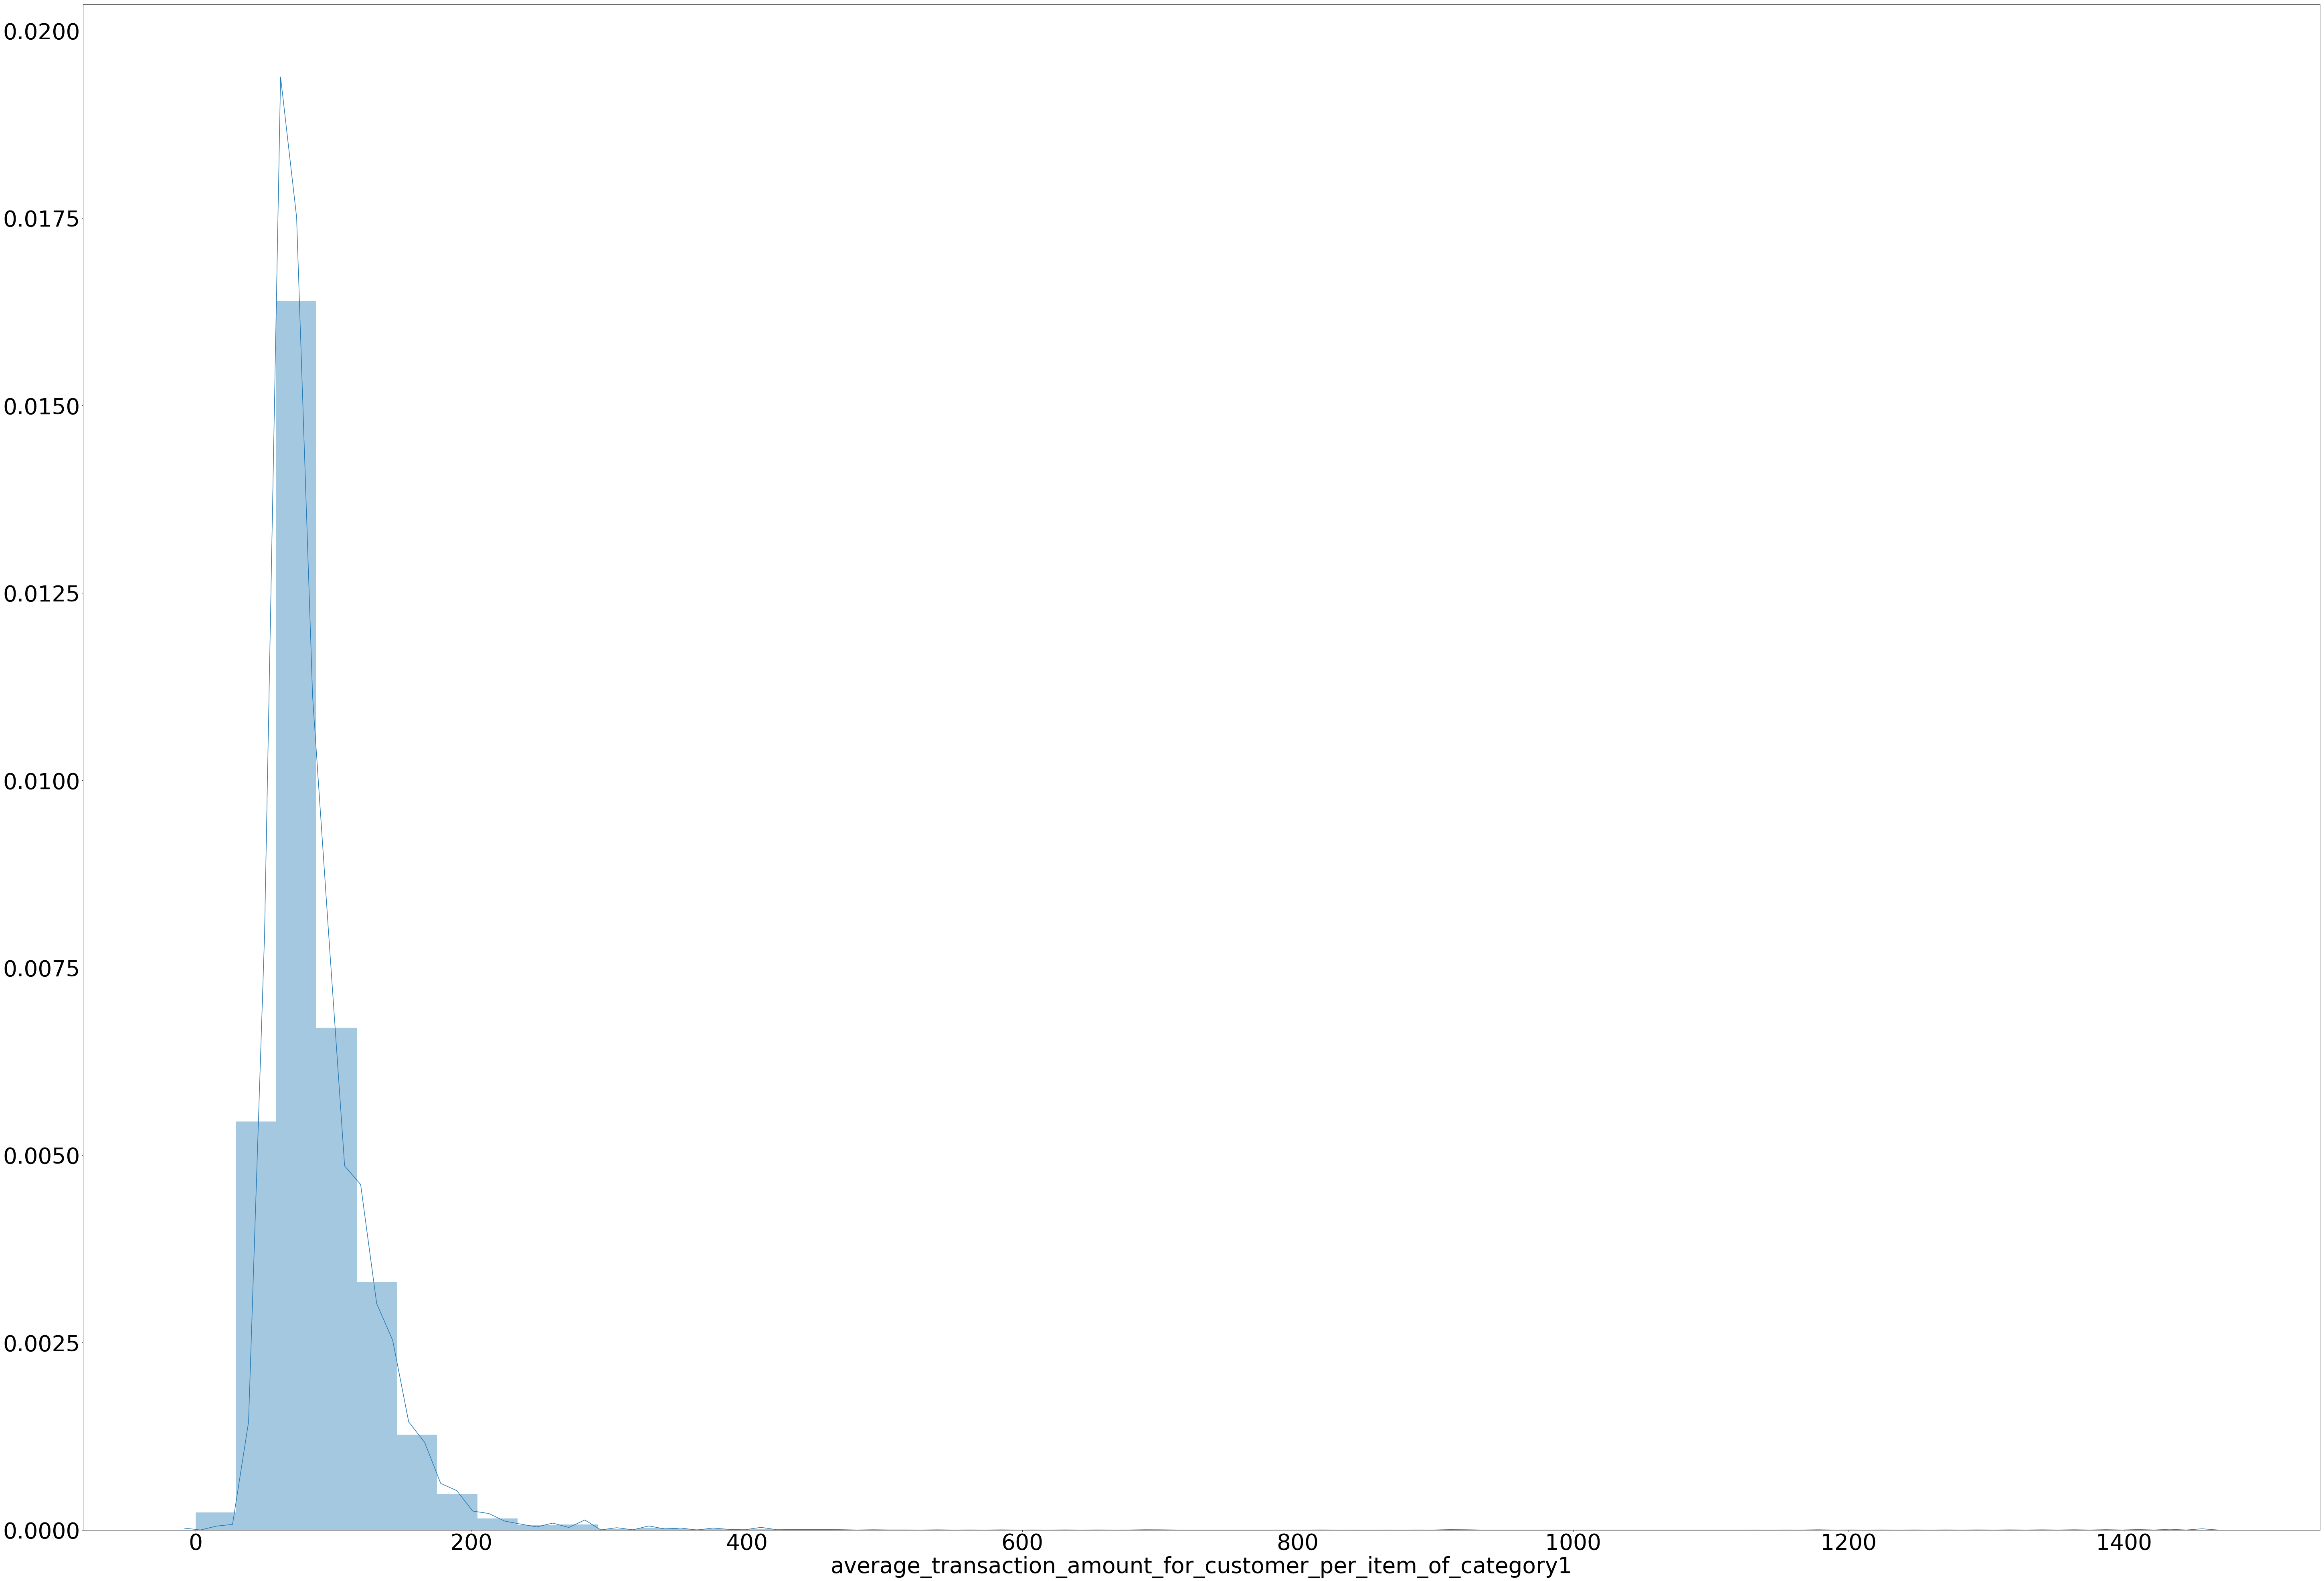

In [276]:
sns.distplot(merged_data['average_transaction_amount_for_customer_per_item_of_category1'])

average_transaction_amount_for_customer_per_item_of_category2

In [277]:
%%time
def get_average_ta_2(row):
    try:
        return (avg_ta[row.customer_id, row.coupon_available_on_category_2])
    except:
        return 0
        

merged_data['average_transaction_amount_for_customer_per_item_of_category2'] = merged_data.apply(get_average_ta_2, axis =1)

CPU times: user 30.1 s, sys: 362 ms, total: 30.5 s
Wall time: 43.8 s


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


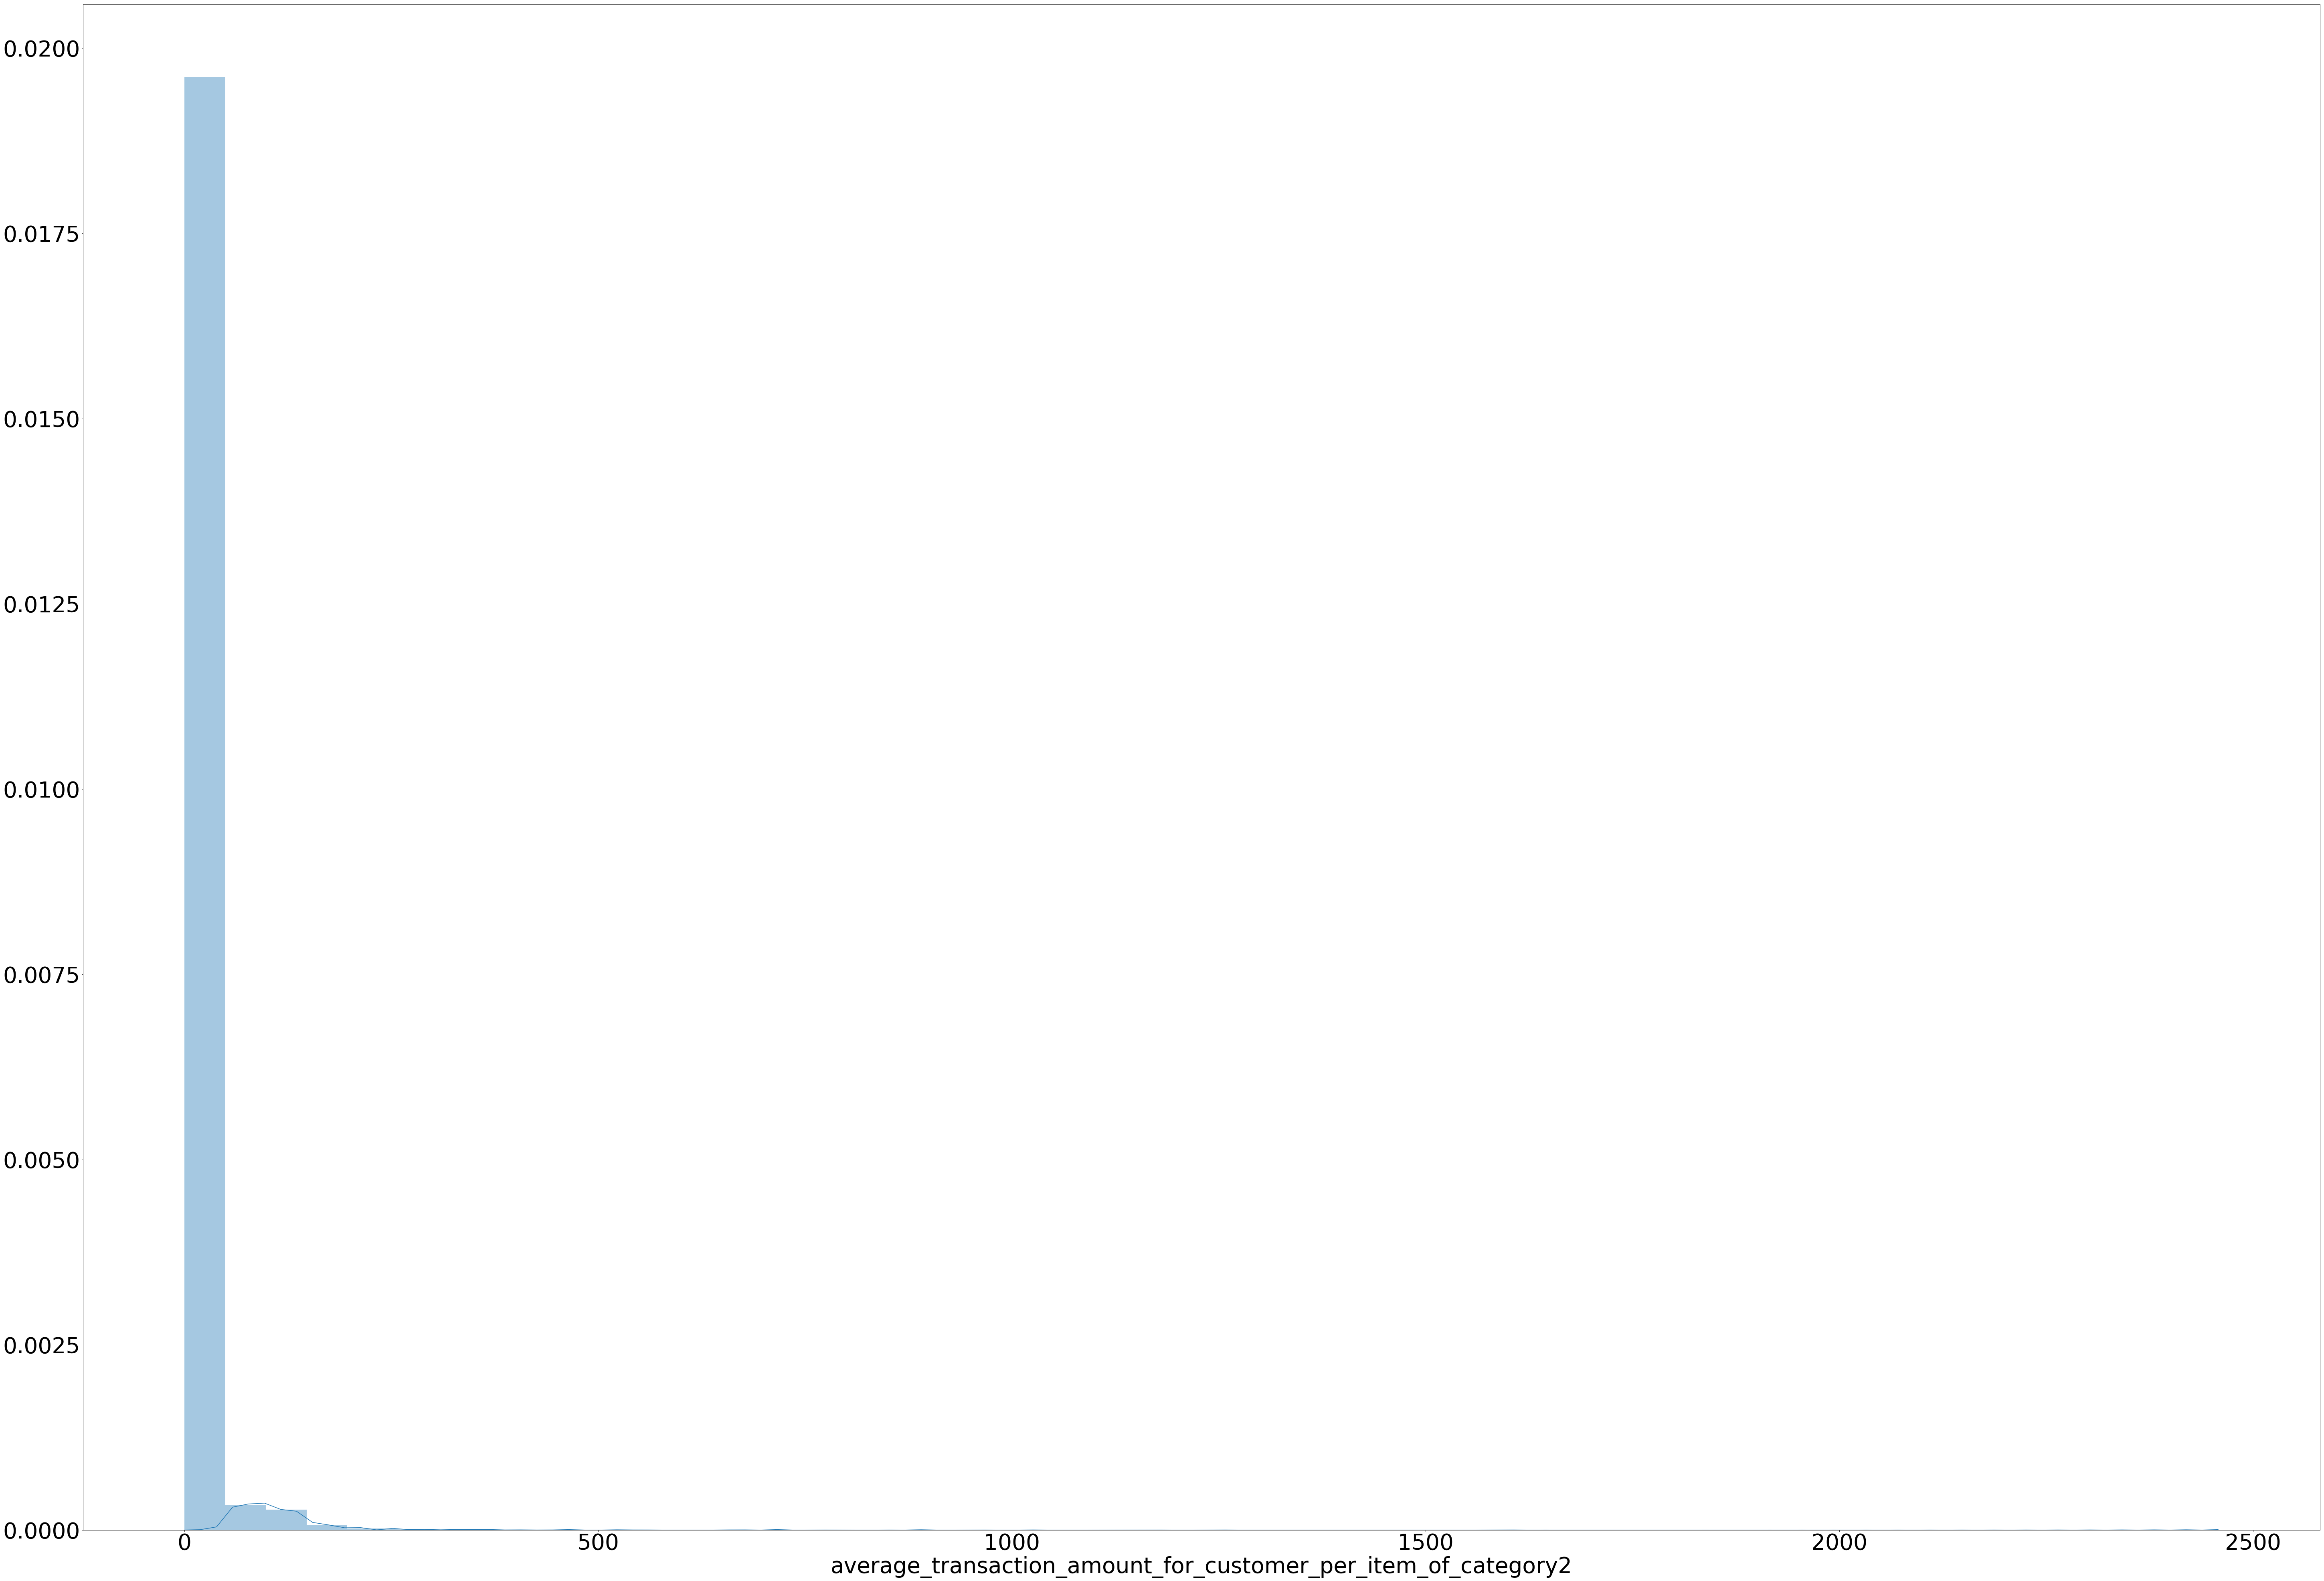

In [278]:
sns.distplot(merged_data['average_transaction_amount_for_customer_per_item_of_category2'])

is_customers_spending_habit_on_category1_in_favour_of_category1_brand1_combo

In [279]:
merged_data['is_customers_spending_habit_on_category1_in_favour_of_category1_brand1_combo'] =merged_data.apply(lambda row: 1 if (row.average_transaction_amount_for_customer_per_item_of_category1 >row.average_selling_price_per_unit_of_category1_brand1_combination) else 0, axis =1)

merged_data['is_customers_spending_habit_on_category1_in_favour_of_category1_brand1_combo'].value_counts()

0    71158
1    57437
Name: is_customers_spending_habit_on_category1_in_favour_of_category1_brand1_combo, dtype: int64

is_customers_spending_habit_on_category1_in_favour_of_category2_brand2_combo

In [280]:
merged_data['is_customers_spending_habit_on_category1_in_favour_of_category2_brand2_combo'] =merged_data.apply(lambda row: 1 if (row.average_transaction_amount_for_customer_per_item_of_category2 >row.average_selling_price_per_unit_of_category2_brand2_combination) else 0, axis =1)

merged_data['is_customers_spending_habit_on_category1_in_favour_of_category2_brand2_combo'].value_counts()

1    127695
0       900
Name: is_customers_spending_habit_on_category1_in_favour_of_category2_brand2_combo, dtype: int64

campaign_duration_in_days

In [281]:
merged_data

campaign_id  coupon_id  customer_id      id  is_test  \
0                22        869          967       3        1   
1                20        389         1566       4        1   
2                22        981          510       5        1   
3                25       1069          361       8        1   
4                17        498          811      10        1   
...             ...        ...          ...     ...      ...   
128590            8         71         1523  128587        0   
128591           30        547          937  128589        0   
128592            8        754         1004  128590        0   
128593           13        134           71  128592        0   
128594           13        681          623  128595        0   

        redemption_status campaign_type campaign_start_date campaign_end_date  \
0                     NaN             X            16/09/13          18/10/13   
1                     NaN             Y            07/09/13          16/11/13   
2                     NaN             X            16/09/13          18/10/13   
3                     NaN             Y            21/10/13          22/11/13   
4                     NaN             Y            29/07/13          30/08/13   
...                   ...           ...                 ...               ...   
128590                0.0             X            16/02/13          05/04/13   
128591                0.0             X            19/11/12          04/01/13   
128592                0.0             X            16/02/13          05/04/13   
128593                0.0             X            19/05/13          05/07/13   
128594                0.0             X            19/05/13          05/07/13   

                             coupon_available_on_item_ids  customer_age_range  \
0       1124,1185,39835,46911,3514,1033,45271,56179,40...                   3   
1       47705,45063,19431,56517,1479,68534,56523,1144,...                   2   
2       1690,7061,58004,22631,6577,2398,41769,21773,33...                   2   
3       10284,70009,57994,11281,44510,35356,29737,6994...                   1   
4       45021,54805,14259,37463,48668,16481,4078,19852...                  -1   
...                                                   ...                 ...   
128590                             17029,1657,30155,12762                   6   
128591            2596,18777,53061,42386,43044,3318,39336                   6   
128592  70460,70534,9060,27164,58588,20849,5608,24948,...                  -1   
128593            62219,1357,38776,41148,32563,62457,4047                   3   
128594  44676,33551,16298,28879,40280,18577,13290,7323...                  -1   

        customer_marital_status  is_customer_rented  customer_family_size  \
0                             0                 0.0                     1   
1                             1                 0.0                     2   
2                             1                 0.0                     2   
3                             0                 0.0                     1   
4                            -1                -1.0                    -1   
...                         ...                 ...                   ...   
128590                        1                 0.0                     2   
128591                        1                 0.0                     2   
128592                       -1                -1.0                    -1   
128593                        1                 0.0                     5   
128594                       -1                -1.0                    -1   

        customer_no_of_children  customer_income_bracket  \
0                             0                      5.0   
1                             0                      9.0   
2                             1                      1.0   
3                             0                      3.0   
4                            -1                     -1.0   
...     

In [291]:
merged_data['campaign_start_date'] = pd.to_datetime(merged_data['campaign_start_date'].astype(str), format='%d/%m/%y')
merged_data['campaign_end_date'] = pd.to_datetime(merged_data['campaign_end_date'].astype(str), format='%d/%m/%y')
customer_transaction_data['date'] = pd.to_datetime(customer_transaction_data['date'].astype(str), format='%Y/%m/%d')
merged_data

campaign_id  coupon_id  customer_id      id  is_test  \
0                22        869          967       3        1   
1                20        389         1566       4        1   
2                22        981          510       5        1   
3                25       1069          361       8        1   
4                17        498          811      10        1   
...             ...        ...          ...     ...      ...   
128590            8         71         1523  128587        0   
128591           30        547          937  128589        0   
128592            8        754         1004  128590        0   
128593           13        134           71  128592        0   
128594           13        681          623  128595        0   

        redemption_status campaign_type campaign_start_date campaign_end_date  \
0                     NaN             X          2013-09-16        2013-10-18   
1                     NaN             Y          2013-09-07        2013-11-16   
2                     NaN             X          2013-09-16        2013-10-18   
3                     NaN             Y          2013-10-21        2013-11-22   
4                     NaN             Y          2013-07-29        2013-08-30   
...                   ...           ...                 ...               ...   
128590                0.0             X          2013-02-16        2013-04-05   
128591                0.0             X          2012-11-19        2013-01-04   
128592                0.0             X          2013-02-16        2013-04-05   
128593                0.0             X          2013-05-19        2013-07-05   
128594                0.0             X          2013-05-19        2013-07-05   

                             coupon_available_on_item_ids  customer_age_range  \
0       1124,1185,39835,46911,3514,1033,45271,56179,40...                   3   
1       47705,45063,19431,56517,1479,68534,56523,1144,...                   2   
2       1690,7061,58004,22631,6577,2398,41769,21773,33...                   2   
3       10284,70009,57994,11281,44510,35356,29737,6994...                   1   
4       45021,54805,14259,37463,48668,16481,4078,19852...                  -1   
...                                                   ...                 ...   
128590                             17029,1657,30155,12762                   6   
128591            2596,18777,53061,42386,43044,3318,39336                   6   
128592  70460,70534,9060,27164,58588,20849,5608,24948,...                  -1   
128593            62219,1357,38776,41148,32563,62457,4047                   3   
128594  44676,33551,16298,28879,40280,18577,13290,7323...                  -1   

        customer_marital_status  is_customer_rented  customer_family_size  \
0                             0                 0.0                     1   
1                             1                 0.0                     2   
2                             1                 0.0                     2   
3                             0                 0.0                     1   
4                            -1                -1.0                    -1   
...                         ...                 ...                   ...   
128590                        1                 0.0                     2   
128591                        1                 0.0                     2   
128592                       -1                -1.0                    -1   
128593                        1                 0.0                     5   
128594                       -1                -1.0                    -1   

        customer_no_of_children  customer_income_bracket  \
0                             0                      5.0   
1                             0                      9.0   
2                             1                      1.0   
3                             0                      3.0   
4                            -1                     -1.0   
...     

In [292]:
merged_data['campaign_duration_in_days'] = (merged_data['campaign_end_date'] - merged_data['campaign_start_date']).dt.days


In [293]:
merged_data[merged_data.campaign_duration_in_days < 0]

Empty DataFrame
Columns: [campaign_id, coupon_id, customer_id, id, is_test, redemption_status, campaign_type, campaign_start_date, campaign_end_date, coupon_available_on_item_ids, customer_age_range, customer_marital_status, is_customer_rented, customer_family_size, customer_no_of_children, customer_income_bracket, is_common_demographic_info_available_for_customer, no_of_items_coupon_is_available_for, is_coupon_available_for_multiple_item_ids, no_of_categories_of_items_available_under_coupon, coupon_available_on_category_1, coupon_available_on_category_2, coupon_available_on_brand_1, coupon_available_on_brand_2, coupon_more_focussed_on_brand_type, popularity_of_category1, popularity_of_category2, popularity_of_brand1, popularity_of_brand2, mean_discount_on_category1, mean_discount_on_category2, mean_discount_on_brand1, mean_discount_on_brand2, no_of_times_customer_bought_category1, no_of_times_customer_bought_category2, no_of_times_customer_bought_brand1, no_of_times_customer_bought_brand2, no_of_times_customer_bought_category1_in_discount, no_of_times_customer_bought_category2_in_discount, no_of_times_customer_bought_brand1_in_discount, no_of_times_customer_bought_brand2_in_discount, has_customer_ever_bought_category1, has_customer_ever_bought_category2, has_customer_ever_bought_brand1, has_customer_ever_bought_brand2, has_customer_ever_bought_category1_in_discount, has_customer_ever_bought_category2_in_discount, has_customer_ever_bought_brand1_in_discount, has_customer_ever_bought_brand2_in_discount, average_selling_price_per_unit_of_category1_brand1_combination, average_selling_price_per_unit_of_category2_brand2_combination, average_transaction_amount_for_customer_per_item_of_category1, average_transaction_amount_for_customer_per_item_of_category2, is_customers_spending_habit_on_category1_in_favour_of_category1_brand1_combo, is_customers_spending_habit_on_category1_in_favour_of_category2_brand2_combo, campaign_duration_in_days]
Index: []

was_user_active_during_campaign_period

In [300]:
last_activity_dates = customer_transaction_data[['customer_id','date']].groupby(by=['customer_id'])['date'].agg('max')
last_activity_dates

customer_id
1      2013-06-30
2      2013-06-26
3      2013-06-16
4      2013-05-11
5      2013-06-29
          ...    
1578   2013-06-13
1579   2013-07-02
1580   2013-07-01
1581   2013-06-28
1582   2013-06-25
Name: date, Length: 1582, dtype: datetime64[ns]

In [301]:
%%time
def get_was_user_active(row):
    #print ("Handled row:", row.id)
    last_active_date = last_activity_dates[row.customer_id]
    
    difference = last_active_date - row.campaign_start_date
    #print ("last_active_date: ",last_active_date,"row.campaign_start_date: ", row.campaign_start_date,
    #       "difference: ",difference.days)
    if (difference.days > 0):
        return 1
    else:
        return 0

merged_data['was_user_active_during_campaign_period'] = merged_data.apply(get_was_user_active, axis =1)

CPU times: user 14.3 s, sys: 154 ms, total: 14.5 s
Wall time: 14.5 s


In [302]:
merged_data['was_user_active_during_campaign_period'].value_counts()

1    77449
0    51146
Name: was_user_active_during_campaign_period, dtype: int64

## Saving the dataset

In [303]:
merged_data.dtypes

campaign_id                                                                              int64
coupon_id                                                                                int64
customer_id                                                                              int64
id                                                                                       int64
is_test                                                                                  int64
redemption_status                                                                      float64
campaign_type                                                                           object
campaign_start_date                                                             datetime64[ns]
campaign_end_date                                                               datetime64[ns]
coupon_available_on_item_ids                                                            object
customer_age_range                                

In [304]:
columns_with_other_dtype = merged_data.select_dtypes(include=['object', 'datetime64[ns]']).columns
columns_with_numeric_dtype = merged_data.select_dtypes(exclude='object').columns
columns_with_numeric_dtype

Index(['campaign_id', 'coupon_id', 'customer_id', 'id', 'is_test',
       'redemption_status', 'campaign_start_date', 'campaign_end_date',
       'customer_age_range', 'customer_marital_status', 'is_customer_rented',
       'customer_family_size', 'customer_no_of_children',
       'customer_income_bracket',
       'is_common_demographic_info_available_for_customer',
       'no_of_items_coupon_is_available_for',
       'is_coupon_available_for_multiple_item_ids',
       'no_of_categories_of_items_available_under_coupon',
       'coupon_available_on_brand_1', 'coupon_available_on_brand_2',
       'popularity_of_category1', 'popularity_of_category2',
       'popularity_of_brand1', 'popularity_of_brand2',
       'mean_discount_on_category1', 'mean_discount_on_category2',
       'mean_discount_on_brand1', 'mean_discount_on_brand2',
       'no_of_times_customer_bought_category1',
       'no_of_times_customer_bought_category2',
       'no_of_times_customer_bought_brand1',
       'no_of_times_

In [305]:
categorical_columns = columns_with_other_datatype_dtype.drop(labels=['campaign_start_date', 'campaign_end_date', 'coupon_available_on_item_ids'])
numerical_columns = columns_with_numeric_dtype.drop(labels=['coupon_id', 'customer_id', 'id', 'campaign_start_date', 'campaign_end_date'])
features = numerical_columns.append(categorical_columns)
features

Index(['campaign_id', 'is_test', 'redemption_status', 'customer_age_range',
       'customer_marital_status', 'is_customer_rented', 'customer_family_size',
       'customer_no_of_children', 'customer_income_bracket',
       'is_common_demographic_info_available_for_customer',
       'no_of_items_coupon_is_available_for',
       'is_coupon_available_for_multiple_item_ids',
       'no_of_categories_of_items_available_under_coupon',
       'coupon_available_on_brand_1', 'coupon_available_on_brand_2',
       'popularity_of_category1', 'popularity_of_category2',
       'popularity_of_brand1', 'popularity_of_brand2',
       'mean_discount_on_category1', 'mean_discount_on_category2',
       'mean_discount_on_brand1', 'mean_discount_on_brand2',
       'no_of_times_customer_bought_category1',
       'no_of_times_customer_bought_category2',
       'no_of_times_customer_bought_brand1',
       'no_of_times_customer_bought_brand2',
       'no_of_times_customer_bought_category1_in_discount',
       

### LabelEncoding all categorical features

In [306]:
labelEncoder = LabelEncoder()


for feature in categorical_columns:
    print("Handling: ", feature)
    merged_data[feature] = labelEncoder.fit_transform(merged_data[feature])


merged_data

campaign_id  coupon_id  customer_id      id  is_test  \
0                22        869          967       3        1   
1                20        389         1566       4        1   
2                22        981          510       5        1   
3                25       1069          361       8        1   
4                17        498          811      10        1   
...             ...        ...          ...     ...      ...   
128590            8         71         1523  128587        0   
128591           30        547          937  128589        0   
128592            8        754         1004  128590        0   
128593           13        134           71  128592        0   
128594           13        681          623  128595        0   

        redemption_status campaign_type campaign_start_date campaign_end_date  \
0                     NaN             X          2013-09-16        2013-10-18   
1                     NaN             Y          2013-09-07        2013-11-16   
2                     NaN             X          2013-09-16        2013-10-18   
3                     NaN             Y          2013-10-21        2013-11-22   
4                     NaN             Y          2013-07-29        2013-08-30   
...                   ...           ...                 ...               ...   
128590                0.0             X          2013-02-16        2013-04-05   
128591                0.0             X          2012-11-19        2013-01-04   
128592                0.0             X          2013-02-16        2013-04-05   
128593                0.0             X          2013-05-19        2013-07-05   
128594                0.0             X          2013-05-19        2013-07-05   

                             coupon_available_on_item_ids  customer_age_range  \
0       1124,1185,39835,46911,3514,1033,45271,56179,40...                   3   
1       47705,45063,19431,56517,1479,68534,56523,1144,...                   2   
2       1690,7061,58004,22631,6577,2398,41769,21773,33...                   2   
3       10284,70009,57994,11281,44510,35356,29737,6994...                   1   
4       45021,54805,14259,37463,48668,16481,4078,19852...                  -1   
...                                                   ...                 ...   
128590                             17029,1657,30155,12762                   6   
128591            2596,18777,53061,42386,43044,3318,39336                   6   
128592  70460,70534,9060,27164,58588,20849,5608,24948,...                  -1   
128593            62219,1357,38776,41148,32563,62457,4047                   3   
128594  44676,33551,16298,28879,40280,18577,13290,7323...                  -1   

        customer_marital_status  is_customer_rented  customer_family_size  \
0                             0                 0.0                     1   
1                             1                 0.0                     2   
2                             1                 0.0                     2   
3                             0                 0.0                     1   
4                            -1                -1.0                    -1   
...                         ...                 ...                   ...   
128590                        1                 0.0                     2   
128591                        1                 0.0                     2   
128592                       -1                -1.0                    -1   
128593                        1                 0.0                     5   
128594                       -1                -1.0                    -1   

        customer_no_of_children  customer_income_bracket  \
0                             0                      5.0   
1                             0                      9.0   
2                             1                      1.0   
3                             0                      3.0   
4                            -1                     -1.0   
...     

## Saving all Features

In [307]:
name = "../data/train/merged_data_after_feature_engineering"+".csv"
merged_data.to_csv( name,index=False)
print ("File Saved!")

File Saved!
